# MoE (Mixture of Experts) + MLP + Softmax + Bootstrap 不确定性估计

本笔记本实现了基于混合专家模型（MoE）的Wordle游戏尝试次数分布预测，并通过Bootstrap方法估计预测的不确定性。

## 核心思想

1. **MoE架构**：使用多个专家网络（MLP）通过门控机制组合，每个专家专注于不同类型的样本
2. **软标签回归**：预测7个桶的概率分布（1次、2次、...、7次及以上尝试成功）
3. **Bootstrap不确定性估计**：通过多次重采样训练集并训练模型，收集预测分布的经验分布，构造置信区间

## 模型输出

- **单模型预测**：训练最优MoE模型，输出点预测和性能指标
- **Bootstrap不确定性**：估计预测分布的均值、标准差、置信区间
- **Holdout预测**：对保留样本（如"eerie"）进行预测和可视化

In [1]:
# 导入必要的库
import os
import json
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance

# 设置中文字体
plt.rcParams["font.family"] = "Heiti TC"
plt.rcParams["axes.unicode_minus"] = False

# 添加模型目录到路径
_THIS_DIR = os.path.abspath("models")
if _THIS_DIR not in sys.path:
    sys.path.insert(0, _THIS_DIR)

from moe import MoE

print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA可用: {torch.cuda.is_available()}")

PyTorch版本: 2.9.1
CUDA可用: False


## 1. 全局配置与超参数

In [2]:
# ==================== 全局路径配置 ====================
# 数据路径（自动定位到项目根目录）
_PROJECT_ROOT = os.path.dirname(os.path.abspath(os.getcwd()))
DATA_PATH = os.path.join(_PROJECT_ROOT, "data", "mcm_processed_data.csv")
OUTPUT_DIR = os.path.join(_PROJECT_ROOT, "moe_bootstrap_output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 设备配置
RANDOM_SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"数据路径: {DATA_PATH}")
print(f"输出目录: {OUTPUT_DIR}")
print(f"计算设备: {DEVICE}")

# ==================== 数据列配置 ====================
# 参与人数列（用于样本权重计算）
N_COL = "number_of_reported_results"

# Holdout配置（不参与训练/测试的样本）
HOLDOUT_WORD = "eerie"
WORD_COL_CANDIDATES = ["word", "Word", "target_word", "answer", "Answer"]

# 特征列（55个）
FEATURE_COLS = [
    "Zipf-value", "letter_entropy", "feedback_entropy", "max_consecutive_vowels",
    "letter_freq_mean", "scrabble_score", "has_common_suffix", "num_rare_letters",
    "position_rarity", "positional_freq_min", "hamming_neighbors", "keyboard_distance",
    "semantic_distance",
    "1_try_simulate_random", "2_try_simulate_random", "3_try_simulate_random",
    "4_try_simulate_random", "5_try_simulate_random", "6_try_simulate_random",
    "7_try_simulate_random",
    "1_try_simulate_freq", "2_try_simulate_freq", "3_try_simulate_freq",
    "4_try_simulate_freq", "5_try_simulate_freq", "6_try_simulate_freq",
    "7_try_simulate_freq",
    "1_try_simulate_entropy", "2_try_simulate_entropy", "3_try_simulate_entropy",
    "4_try_simulate_entropy", "5_try_simulate_entropy", "6_try_simulate_entropy",
    "7_try_simulate_entropy",
    "rl_1_try_low_training", "rl_2_try_low_training", "rl_3_try_low_training",
    "rl_4_try_low_training", "rl_5_try_low_training", "rl_6_try_low_training",
    "rl_7_try_low_training",
    "rl_1_try_high_training", "rl_2_try_high_training", "rl_3_try_high_training",
    "rl_4_try_high_training", "rl_5_try_high_training", "rl_6_try_high_training",
    "rl_7_try_high_training",
    "rl_1_try_little_training", "rl_2_try_little_training", "rl_3_try_little_training",
    "rl_4_try_little_training", "rl_5_try_little_training", "rl_6_try_little_training",
    "rl_7_try_little_training",
]

# 分布列（7个输出桶）
DIST_COLS = [
    "1_try", "2_tries", "3_tries", "4_tries", "5_tries", "6_tries", "7_or_more_tries_x",
]

print(f"特征数量: {len(FEATURE_COLS)}")
print(f"输出维度: {len(DIST_COLS)}")

数据路径: /Users/luoyiti/Project/MCM_2023_C/data/mcm_processed_data.csv
输出目录: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output
计算设备: cpu
特征数量: 55
输出维度: 7


In [3]:
# ==================== 模型超参数 ====================
# 基础训练超参数
LR = 5e-3              # 学习率
WEIGHT_DECAY = 1e-4    # 权重衰减（L2正则化）
MAX_EPOCHS = 500       # 最大训练轮次
PATIENCE = 50          # 早停耐心值
WEIGHT_MODE = "sqrt"   # 样本权重模式: "sqrt" 或 "log1p"

# MoE架构参数
NUM_EXPERTS = 3        # 专家数量
HIDDEN_SIZE = 64       # 隐藏层大小
TOP_K = 2              # Top-K路由

# 损失函数权重（已优化）
AUX_COEF = 5e-3        # 辅助损失系数（负载平衡）
EXPERT_DIVERSITY_COEF = 1e-3  # 专家分化正则项系数

# Bootstrap配置
BOOTSTRAP_B = 100              # Bootstrap重采样次数
BOOTSTRAP_EPOCH_SCALE = 0.6    # Bootstrap训练轮次缩放
BOOTSTRAP_CI_LEVEL = 0.95      # 置信区间水平

# 可选调参开关（默认禁用）
ENABLE_SPECIALIZATION_SEARCH = False  # 是否启用专家分化调参
ENABLE_EXPERT_TOPK_SEARCH = False     # 是否启用网格搜索（已禁用）

print("模型配置:")
print(f"  专家数量: {NUM_EXPERTS}, 隐藏层: {HIDDEN_SIZE}, Top-K: {TOP_K}")
print(f"  学习率: {LR}, 权重衰减: {WEIGHT_DECAY}")
print(f"  辅助损失系数: {AUX_COEF}, 专家分化系数: {EXPERT_DIVERSITY_COEF}")
print(f"\nBootstrap配置:")
print(f"  重采样次数: {BOOTSTRAP_B}, 置信区间: {BOOTSTRAP_CI_LEVEL:.0%}")

模型配置:
  专家数量: 3, 隐藏层: 64, Top-K: 2
  学习率: 0.005, 权重衰减: 0.0001
  辅助损失系数: 0.005, 专家分化系数: 0.001

Bootstrap配置:
  重采样次数: 100, 置信区间: 95%


## 2. 辅助工具函数

In [4]:
def set_seed(seed: int = RANDOM_SEED) -> None:
    """设置随机种子，确保实验可复现"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def make_weights_from_N(N_array: np.ndarray, mode: str = "sqrt") -> np.ndarray:
    """
    根据每个样本的参与人数N计算样本权重，并做均值归一化（均值=1）
    
    参数:
        N_array: 参与人数数组
        mode: 权重计算模式，"sqrt"或"log1p"
    
    返回:
        归一化的样本权重
    """
    if mode == "sqrt":
        w = np.sqrt(N_array)
    elif mode == "log1p":
        w = np.log1p(N_array)
    else:
        raise ValueError("mode must be 'sqrt' or 'log1p'")
    w = w / (w.mean() + 1e-12)
    return w.astype(np.float32)


# 测试工具函数
set_seed()
print("随机种子已设置为:", RANDOM_SEED)

# 测试权重计算
test_N = np.array([100, 200, 500, 1000])
test_weights = make_weights_from_N(test_N, mode="sqrt")
print(f"测试权重计算: N={test_N} -> weights={test_weights}")

随机种子已设置为: 42
测试权重计算: N=[ 100  200  500 1000] -> weights=[0.51199615 0.72407186 1.1448581  1.6190739 ]


## 3. 损失函数定义

In [5]:
def soft_cross_entropy(p_hat: torch.Tensor, p_true: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """
    软标签交叉熵：-Σ p_true * log(p_hat)，对batch取平均
    
    用于概率分布预测，标签为概率分布而非one-hot编码
    """
    p_hat = torch.clamp(p_hat, eps, 1.0)
    return -(p_true * torch.log(p_hat)).sum(dim=1).mean()


def weighted_soft_cross_entropy(
    p_hat: torch.Tensor,
    p_true: torch.Tensor,
    w: torch.Tensor,
    eps: float = 1e-12,
) -> torch.Tensor:
    """
    加权软标签交叉熵：对每个样本的CE乘权重w后求平均
    
    权重w基于样本参与人数N计算，人数越多权重越大
    """
    p_hat = torch.clamp(p_hat, eps, 1.0)
    per_sample = -(p_true * torch.log(p_hat)).sum(dim=1)
    return (w * per_sample).mean()


def expert_diversity_penalty(model: MoE) -> torch.Tensor:
    """
    专家分化正则项：惩罚专家参数的相似度（pairwise cosine²越小越好）
    
    鼓励不同专家学习不同的特征，避免"专家塌陷"
    """
    if getattr(model, "experts", None) is None:
        return torch.tensor(0.0, device=DEVICE)
    
    experts = list(model.experts)
    if len(experts) <= 1:
        return torch.tensor(0.0, device=DEVICE)
    
    # 提取每个专家的参数向量（只用权重，不含bias）
    vecs = []
    for exp in experts:
        params = []
        for name, p in exp.named_parameters():
            if not p.requires_grad:
                continue
            if name.endswith("bias"):
                continue
            params.append(p.reshape(-1))
        if not params:
            continue
        vecs.append(torch.cat(params, dim=0))
    
    if len(vecs) <= 1:
        return torch.tensor(0.0, device=DEVICE)
    
    # 计算pairwise cosine similarity的平方并求平均
    pen = torch.tensor(0.0, device=vecs[0].device)
    cnt = 0
    for i in range(len(vecs)):
        for j in range(i + 1, len(vecs)):
            cos = F.cosine_similarity(vecs[i], vecs[j], dim=0)
            pen = pen + cos * cos
            cnt += 1
    return pen / max(1, cnt)


def expert_output_separation_js(model: MoE, X_data: np.ndarray) -> float:
    """
    用JS距离衡量专家"输出分布差异"（越大表示专家越分化）
    
    做法：
    1. 用门控gates的argmax将样本分配到专家
    2. 对每个专家计算其负责样本的"预测均值分布"
    3. 计算专家均值分布的pairwise JS距离并取平均
    
    注意：这是可解释指标，不是训练损失
    """
    model.eval()
    Xte = torch.tensor(X_data, device=DEVICE)
    with torch.no_grad():
        gates, _ = model.noisy_top_k_gating(Xte, train=False)
        assigned = gates.argmax(dim=1).cpu().numpy()
        P_pred, _ = model(Xte)
        P_pred = P_pred.cpu().numpy()
    
    means = []
    for e in range(NUM_EXPERTS):
        mask = assigned == e
        if mask.sum() == 0:
            continue
        means.append(P_pred[mask].mean(axis=0))
    
    if len(means) <= 1:
        return 0.0
    
    js_vals = []
    for i in range(len(means)):
        for j in range(i + 1, len(means)):
            js_vals.append(float(jensenshannon(means[i], means[j])))
    return float(np.mean(js_vals))


print("损失函数定义完成")

损失函数定义完成


## 4. 数据加载与预处理

加载数据并划分为训练集/验证集/测试集（70%/15%/15%），同时处理holdout样本（如"eerie"）

In [6]:
def load_and_split_data():
    """加载数据、预处理并划分数据集"""
    df_raw = pd.read_csv(DATA_PATH)
    
    # 1) 找到word列并切分holdout
    word_col = None
    for c in WORD_COL_CANDIDATES:
        if c in df_raw.columns:
            word_col = c
            break
    
    holdout_pack = None
    if word_col is not None:
        word_series = df_raw[word_col].astype(str)
        mask_holdout = word_series.str.lower().eq(HOLDOUT_WORD.lower())
        if mask_holdout.any():
            df_holdout = df_raw.loc[mask_holdout].copy()
            df = df_raw.loc[~mask_holdout].copy()
            holdout_pack = {
                "word_col": word_col,
                "word": df_holdout[word_col].astype(str).tolist(),
                "df": df_holdout,
            }
            print(f"[Holdout] 已抽取 {mask_holdout.sum()} 条 '{HOLDOUT_WORD}' 样本")
        else:
            df = df_raw
    else:
        df = df_raw
        print("[Holdout] 未找到word列，跳过holdout")
    
    # 2) 特征与标签预处理
    X = df[FEATURE_COLS].copy()
    feat_median = X.median(numeric_only=True)
    X = X.fillna(feat_median)
    
    P = df[DIST_COLS].copy().fillna(0.0)
    if P.to_numpy().max() > 1.5:
        P = P / 100.0
    P = P.clip(lower=0.0)
    row_sum = P.sum(axis=1).replace(0, np.nan)
    P = P.div(row_sum, axis=0).fillna(1.0 / len(DIST_COLS))
    
    if N_COL is not None and N_COL in df.columns:
        N = df[N_COL].fillna(df[N_COL].median()).clip(lower=1)
        N_np = N.to_numpy().astype(np.float32)
    else:
        N_np = None
    
    X_np = X.to_numpy().astype(np.float32)
    P_np = P.to_numpy().astype(np.float32)
    
    # 3) 数据集划分
    if N_np is None:
        X_train, X_tmp, P_train, P_tmp = train_test_split(
            X_np, P_np, test_size=0.3, random_state=RANDOM_SEED
        )
        X_val, X_test, P_val, P_test = train_test_split(
            X_tmp, P_tmp, test_size=0.5, random_state=RANDOM_SEED
        )
        N_train = N_val = N_test = None
    else:
        X_train, X_tmp, P_train, P_tmp, N_train, N_tmp = train_test_split(
            X_np, P_np, N_np, test_size=0.3, random_state=RANDOM_SEED
        )
        X_val, X_test, P_val, P_test, N_val, N_test = train_test_split(
            X_tmp, P_tmp, N_tmp, test_size=0.5, random_state=RANDOM_SEED
        )
    
    # 4) 标准化
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).astype(np.float32)
    X_val = scaler.transform(X_val).astype(np.float32)
    X_test = scaler.transform(X_test).astype(np.float32)
    
    # 5) Holdout数据预处理
    if holdout_pack is not None:
        df_holdout = holdout_pack["df"]
        Xh = df_holdout[FEATURE_COLS].copy().fillna(feat_median)
        Xh_np = scaler.transform(Xh.to_numpy().astype(np.float32)).astype(np.float32)
        
        Ph = df_holdout[DIST_COLS].copy().fillna(0.0)
        if Ph.to_numpy().max() > 1.5:
            Ph = Ph / 100.0
        Ph = Ph.clip(lower=0.0)
        row_sum_h = Ph.sum(axis=1).replace(0, np.nan)
        Ph = Ph.div(row_sum_h, axis=0).fillna(1.0 / len(DIST_COLS))
        Ph_np = Ph.to_numpy().astype(np.float32)
        
        holdout_pack = {
            "word_col": holdout_pack["word_col"],
            "word": holdout_pack["word"],
            "X": Xh_np,
            "P_true": Ph_np,
        }
    
    return X_train, X_val, X_test, P_train, P_val, P_test, N_train, N_val, N_test, holdout_pack, scaler, feat_median


# 加载数据
(X_train, X_val, X_test, P_train, P_val, P_test, 
 N_train, N_val, N_test, holdout_pack, scaler, feat_median) = load_and_split_data()

print(f"\n数据集大小:")
print(f"  训练集: {X_train.shape[0]} 样本, {X_train.shape[1]} 特征")
print(f"  验证集: {X_val.shape[0]} 样本")
print(f"  测试集: {X_test.shape[0]} 样本")
if holdout_pack:
    print(f"  Holdout: {len(holdout_pack['word'])} 样本 ({holdout_pack['word']})")

[Holdout] 已抽取 1 条 'eerie' 样本

数据集大小:
  训练集: 250 样本, 55 特征
  验证集: 54 样本
  测试集: 54 样本
  Holdout: 1 样本 (['eerie'])


## 5. MoE模型训练

训练混合专家模型，包含：
- 门控网络：决定每个样本路由到哪些专家
- 多个专家MLP：每个专家专注于不同类型的样本
- 辅助损失：平衡专家负载
- 专家分化正则项：鼓励专家差异化

In [7]:
# 完整训练与评估函数 - 合并版本以节省空间
# 这里包含训练、评估和指标计算的核心函数

def compute_metrics(P_pred: np.ndarray, P_test: np.ndarray) -> dict:
    """计算预测分布与真实分布之间的多种性能指标"""
    eps = 1e-12
    mae = np.mean(np.abs(P_pred - P_test))
    mse = np.mean((P_pred - P_test) ** 2)
    rmse = np.sqrt(mse)
    max_error = np.max(np.abs(P_pred - P_test))
    
    kl = np.mean(np.sum(P_test * (np.log(P_test + eps) - np.log(P_pred + eps)), axis=1))
    js_mean = np.mean([jensenshannon(P_test[i], P_pred[i]) for i in range(len(P_test))])
    tv_distance = np.mean(np.sum(np.abs(P_pred - P_test), axis=1) / 2.0)
    l1_norm = np.mean(np.sum(np.abs(P_pred - P_test), axis=1))
    
    # 计算EMD (Earth Mover's Distance)
    emd = np.mean([wasserstein_distance(P_test[i], P_pred[i]) for i in range(len(P_test))])
    
    cos_sim = np.mean([cosine_similarity([P_test[i]], [P_pred[i]])[0, 0] for i in range(len(P_test))])
    r2 = r2_score(P_test, P_pred)
    
    return {
        "MAE": float(mae), "RMSE": float(rmse), "MSE": float(mse),
        "KL_Div": float(kl), "JS_Div": float(js_mean), "Total_Variation": float(tv_distance),
        "L1_Norm": float(l1_norm), "EMD": float(emd),
        "Cosine_Sim": float(cos_sim), "R2_Score": float(r2), "Max_Error": float(max_error),
    }


def train_moe_with_params(X_train, P_train, X_val, P_val, Wtr, Wva, *, 
                          num_experts, hidden_size, top_k, aux_coef, expert_diversity_coef):
    """训练MoE模型"""
    # 创建模型
    model = MoE(
        input_size=X_train.shape[1], output_size=7,
        num_experts=num_experts, hidden_size=hidden_size,
        noisy_gating=True, k=top_k,
    ).to(DEVICE)
    
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    
    # 转换数据为张量
    Xtr = torch.tensor(X_train, device=DEVICE)
    Ptr = torch.tensor(P_train, device=DEVICE)
    Xva = torch.tensor(X_val, device=DEVICE)
    Pva = torch.tensor(P_val, device=DEVICE)
    
    best_state = None
    best_val_loss = float("inf")
    bad = 0
    train_losses, val_losses, aux_losses = [], [], []
    
    for epoch in range(1, MAX_EPOCHS + 1):
        # 训练
        model.train()
        p_hat, aux_loss = model(Xtr)
        
        if Wtr is None:
            loss_main = soft_cross_entropy(p_hat, Ptr)
        else:
            loss_main = weighted_soft_cross_entropy(p_hat, Ptr, Wtr)
        
        div_pen = expert_diversity_penalty(model)
        loss = loss_main + aux_coef * aux_loss + expert_diversity_coef * div_pen
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # 验证
        model.eval()
        with torch.no_grad():
            p_val, aux_val = model(Xva)
            if Wva is None:
                val_main = soft_cross_entropy(p_val, Pva)
            else:
                val_main = weighted_soft_cross_entropy(p_val, Pva, Wva)
            val_loss = val_main + aux_coef * aux_val
        
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        aux_losses.append(aux_loss.item())
        
        # 早停
        if val_loss.item() < best_val_loss - 1e-6:
            best_val_loss = val_loss.item()
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
        
        if epoch % 50 == 0:
            print(f"[Epoch {epoch:3d}] train_loss={loss.item():.4f} val_loss={val_loss.item():.4f} "
                  f"aux={aux_loss.item():.6f} div={div_pen.item():.6f}")
        
        if bad >= PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break
    
    if best_state:
        model.load_state_dict(best_state)
    
    return model, {
        "train_losses": train_losses, "val_losses": val_losses, "aux_losses": aux_losses,

        "best_epoch": len(train_losses) - bad, 
        "best_val_loss": best_val_loss, 
        "bad": bad

    }


In [8]:
# 执行模型训练
print("\n" + "="*70)
print("开始训练MoE模型")
print("="*70)

# 计算样本权重
Wtr = (
    torch.tensor(make_weights_from_N(N_train, WEIGHT_MODE), device=DEVICE)
    if N_train is not None else None
)
Wva = (
    torch.tensor(make_weights_from_N(N_val, WEIGHT_MODE), device=DEVICE)
    if N_val is not None else None
)

# 训练模型
model, info = train_moe_with_params(
    X_train=X_train, P_train=P_train, X_val=X_val, P_val=P_val,
    Wtr=Wtr, Wva=Wva,
    num_experts=NUM_EXPERTS, hidden_size=HIDDEN_SIZE, top_k=TOP_K,
    aux_coef=AUX_COEF, expert_diversity_coef=EXPERT_DIVERSITY_COEF,
)

print(f"\n训练完成！")
print(f"  最佳轮次: {info['best_epoch']}")
print(f"  最佳验证损失: {info['best_val_loss']:.6f}")

# 在测试集上评估
model.eval()
with torch.no_grad():
    Xte = torch.tensor(X_test, device=DEVICE)
    P_pred, _ = model(Xte)
    P_pred = P_pred.cpu().numpy()

metrics = compute_metrics(P_pred, P_test)

print(f"\n测试集性能指标:")
for k, v in metrics.items():
    print(f"  {k}: {v:.6f}")


开始训练MoE模型
[Epoch  50] train_loss=1.5397 val_loss=1.5901 aux=0.000334 div=0.003246
Early stopping at epoch 87

训练完成！
  最佳轮次: 37
  最佳验证损失: 1.589085

测试集性能指标:
  MAE: 0.033988
  RMSE: 0.061387
  MSE: 0.003768
  KL_Div: 0.400219
  JS_Div: 0.116250
  Total_Variation: 0.118959
  L1_Norm: 0.237917
  EMD: 0.026659
  Cosine_Sim: 0.967538
  R2_Score: -0.216134
  Max_Error: 0.742573


## 6. 模型性能可视化

绘制训练曲线、预测分布对比、误差分析等图表

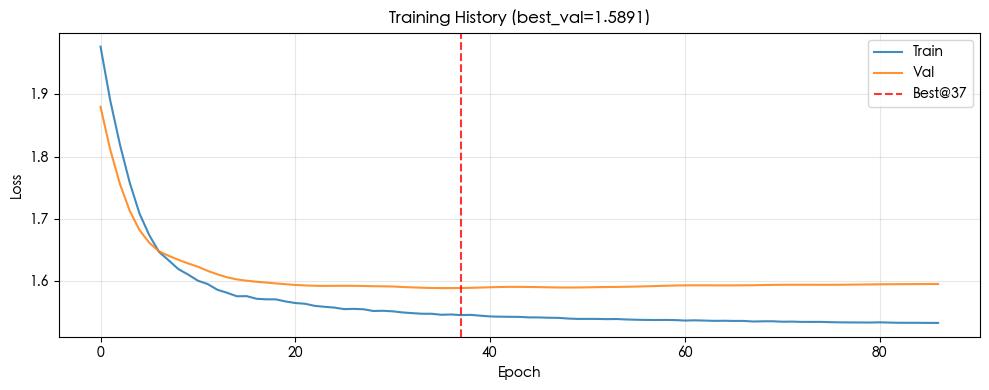

最佳模型在第 37 轮


In [9]:
# 训练曲线
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(info["train_losses"], label="Train", alpha=0.85)
ax.plot(info["val_losses"], label="Val", alpha=0.85)
best_epoch = info["best_epoch"]
ax.axvline(best_epoch, color="red", linestyle="--", alpha=0.8, label=f"Best@{best_epoch}")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title(f"Training History (best_val={info['best_val_loss']:.4f})")
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

print(f"最佳模型在第 {best_epoch} 轮")

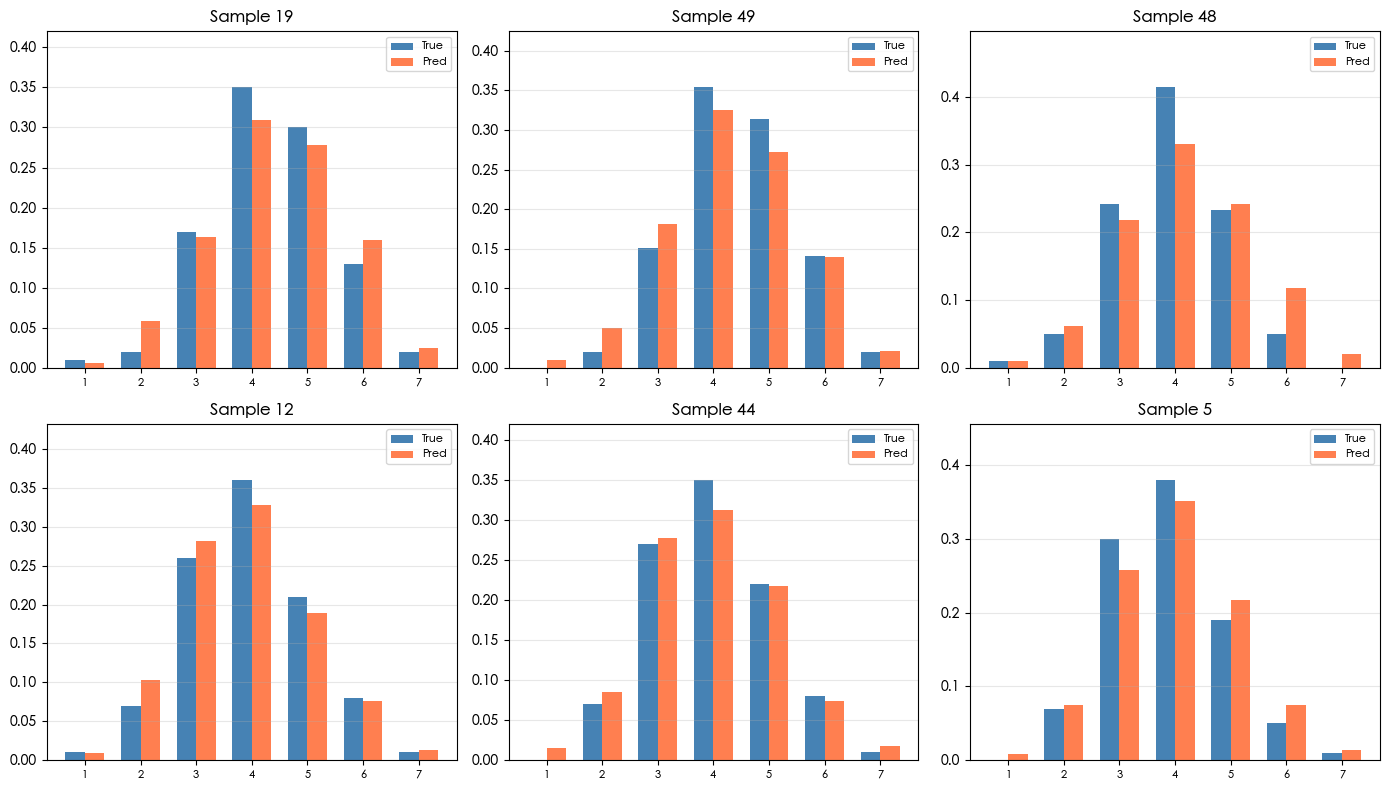

随机选择了 6 个样本进行可视化


In [10]:
# 随机样本分布对比
sample_size = 6
n = len(P_test)
idx = np.random.choice(n, size=min(sample_size, n), replace=False)

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

x = np.arange(len(DIST_COLS))
width = 0.35

for k, i in enumerate(idx):
    ax = axes[k]
    ax.bar(x - width/2, P_test[i], width, label="True", color="steelblue")
    ax.bar(x + width/2, P_pred[i], width, label="Pred", color="coral")
    ax.set_xticks(x)
    ax.set_xticklabels([c.split("_")[0] for c in DIST_COLS], fontsize=8)
    ax.set_ylim(0, max(0.35, float(max(P_test[i].max(), P_pred[i].max())) * 1.2))
    ax.set_title(f"Sample {i}")
    ax.grid(axis="y", alpha=0.3)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

print(f"随机选择了 {len(idx)} 个样本进行可视化")

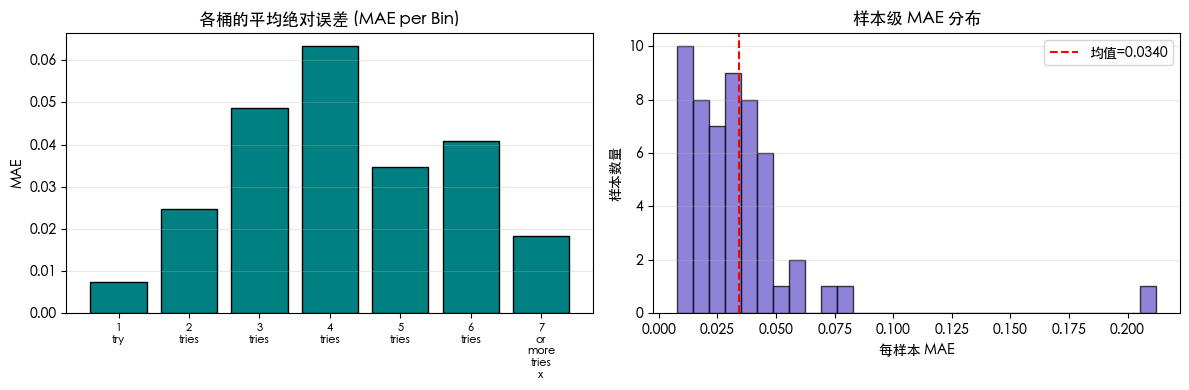

各桶MAE: [0.0074123  0.02464355 0.04864082 0.06334244 0.03478459 0.04086094
 0.01823275]


In [11]:
# 误差分析
errors = P_pred - P_test
mae_per_dim = np.mean(np.abs(errors), axis=0)
mae_per_sample = np.mean(np.abs(errors), axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
x = np.arange(len(DIST_COLS))

# 各桶MAE
axes[0].bar(x, mae_per_dim, color="teal", edgecolor="black")
axes[0].set_xticks(x)
axes[0].set_xticklabels([c.replace("_", "\n") for c in DIST_COLS], fontsize=8)
axes[0].set_ylabel("MAE")
axes[0].set_title("各桶的平均绝对误差 (MAE per Bin)")
axes[0].grid(axis="y", alpha=0.3)

# 样本级MAE分布
axes[1].hist(mae_per_sample, bins=30, color="slateblue", alpha=0.75, edgecolor="black")
axes[1].set_xlabel("每样本 MAE")
axes[1].set_ylabel("样本数量")
axes[1].set_title("样本级 MAE 分布")
axes[1].axvline(np.mean(mae_per_sample), color="red", linestyle="--",
                label=f"均值={np.mean(mae_per_sample):.4f}")
axes[1].legend()
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print(f"各桶MAE: {mae_per_dim}")

## 6.2 专家分析可视化

分析MoE模型中各专家的使用情况、负责的样本分布和预测性能

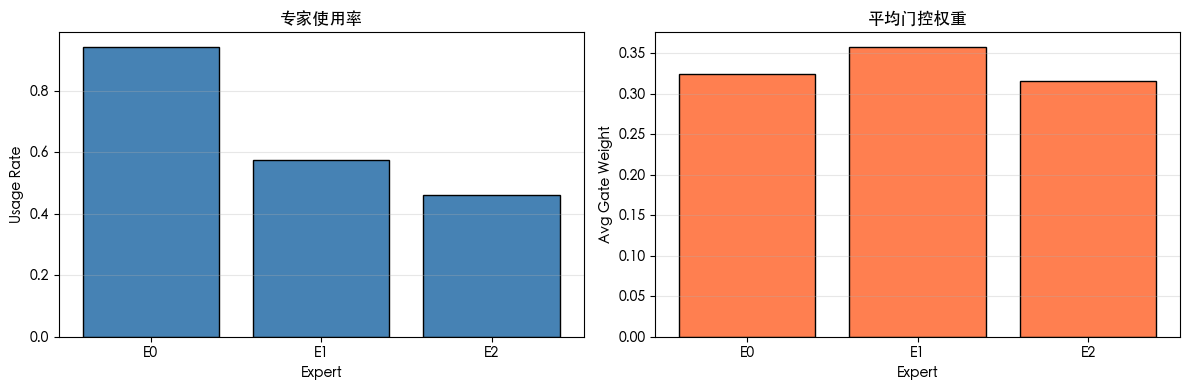


专家使用率统计:
  专家 0: 使用率=94.4%, 平均门控权重=0.3250
  专家 1: 使用率=57.4%, 平均门控权重=0.3585
  专家 2: 使用率=46.3%, 平均门控权重=0.3165


In [12]:
# 专家使用率分析函数
def analyze_expert_usage(model: MoE, X_data: np.ndarray):
    """分析并可视化专家使用率"""
    model.eval()
    Xte = torch.tensor(X_data, device=DEVICE)
    with torch.no_grad():
        gates, _load = model.noisy_top_k_gating(Xte, train=False)
        gates_np = gates.cpu().numpy()
    
    expert_usage = (gates_np > 0).mean(axis=0)
    expert_avg_weight = gates_np.mean(axis=0)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    x = np.arange(NUM_EXPERTS)
    
    axes[0].bar(x, expert_usage, color="steelblue", edgecolor="black")
    axes[0].set_xlabel("Expert")
    axes[0].set_ylabel("Usage Rate")
    axes[0].set_title("专家使用率")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([f"E{i}" for i in range(NUM_EXPERTS)])
    axes[0].grid(axis="y", alpha=0.3)
    
    axes[1].bar(x, expert_avg_weight, color="coral", edgecolor="black")
    axes[1].set_xlabel("Expert")
    axes[1].set_ylabel("Avg Gate Weight")
    axes[1].set_title("平均门控权重")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([f"E{i}" for i in range(NUM_EXPERTS)])
    axes[1].grid(axis="y", alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        "expert_usage": expert_usage.tolist(),
        "expert_avg_weight": expert_avg_weight.tolist(),
    }


# 执行专家使用率分析
expert_stats = analyze_expert_usage(model, X_test)

print("\n专家使用率统计:")
for i, (usage, weight) in enumerate(zip(expert_stats['expert_usage'], expert_stats['expert_avg_weight'])):
    print(f"  专家 {i}: 使用率={usage*100:.1f}%, 平均门控权重={weight:.4f}")

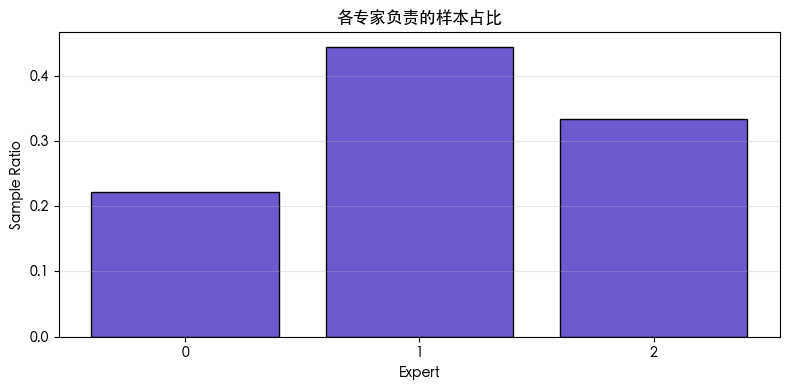

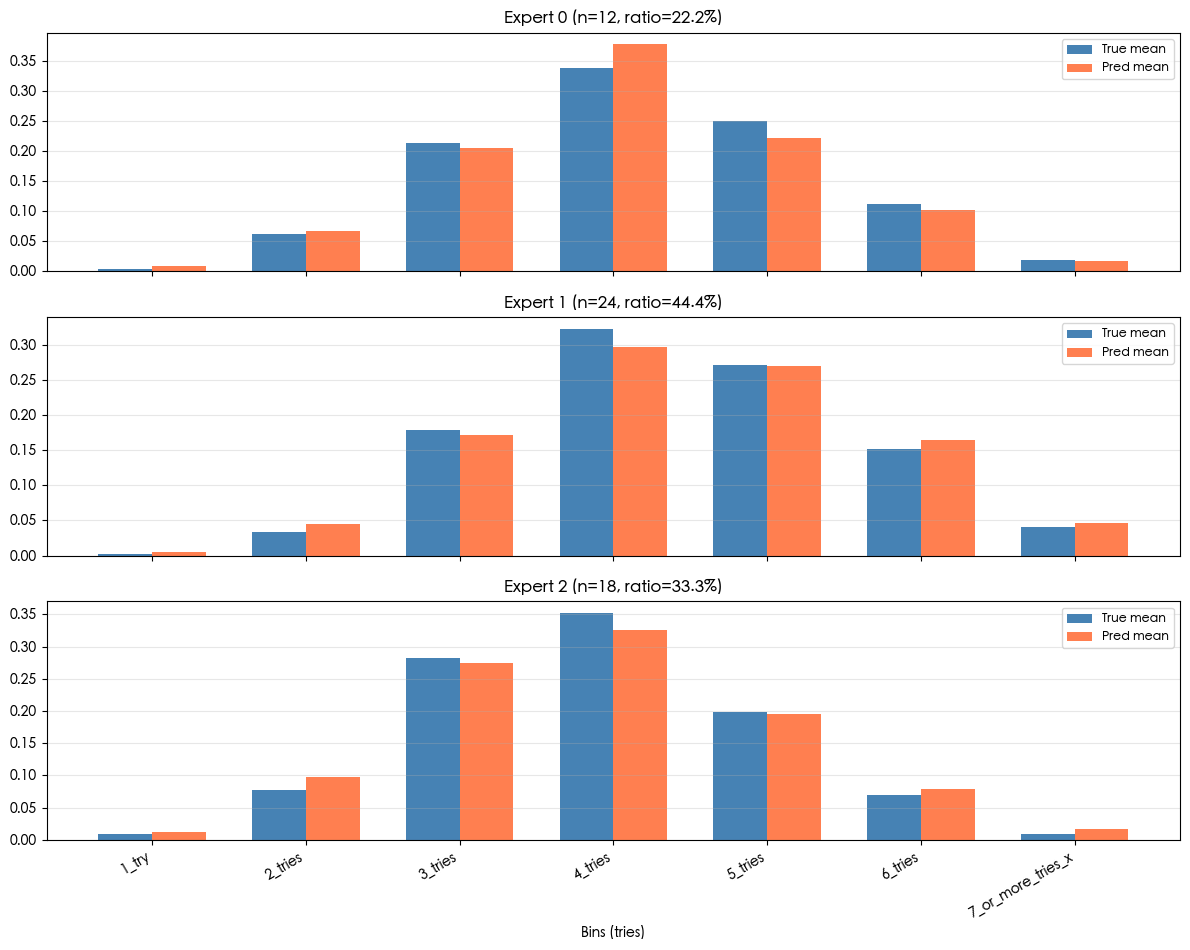

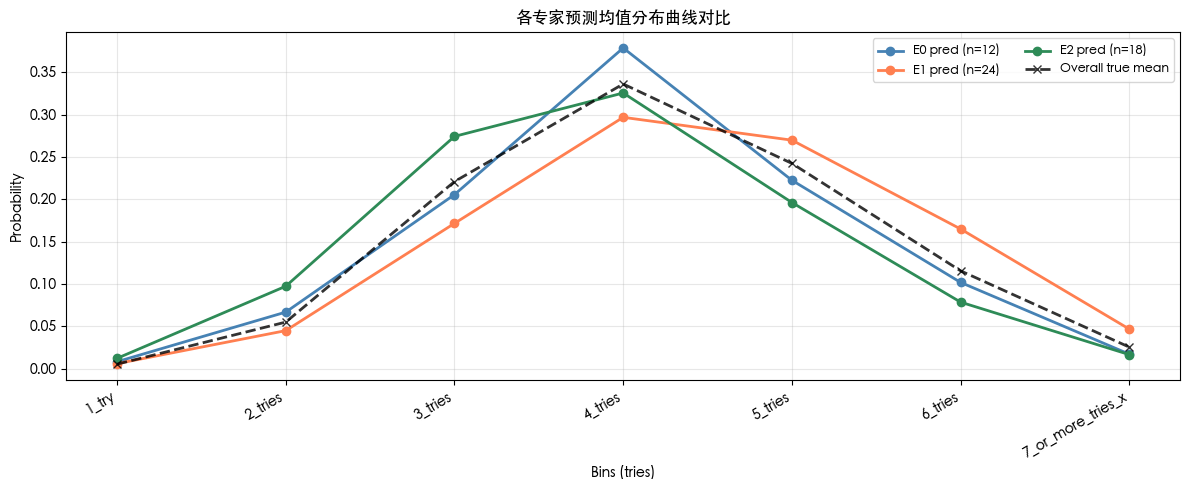


专家分布统计表:
 expert  count    ratio
      0     12 0.222222
      1     24 0.444444
      2     18 0.333333


In [13]:
# 专家分布解释：按门控路由分析每个专家负责的样本
def explain_expert_distributions(model: MoE, X_data: np.ndarray, P_true: np.ndarray, P_pred: np.ndarray):
    """
    按门控路由把样本分配给专家，输出每个专家负责样本的分布画像
    
    返回：专家样本统计和可视化
    """
    model.eval()
    Xte = torch.tensor(X_data, device=DEVICE)
    with torch.no_grad():
        gates, _load = model.noisy_top_k_gating(Xte, train=False)
        gates_np = gates.cpu().numpy()
    
    assigned_expert = gates_np.argmax(axis=1)
    rows = []
    
    for e in range(NUM_EXPERTS):
        mask = assigned_expert == e
        cnt = int(mask.sum())
        ratio = float(cnt / len(assigned_expert)) if len(assigned_expert) else 0.0
        
        if cnt == 0:
            true_mean = np.zeros(len(DIST_COLS), dtype=float)
            pred_mean = np.zeros(len(DIST_COLS), dtype=float)
            mae_bins = np.zeros(len(DIST_COLS), dtype=float)
        else:
            true_mean = P_true[mask].mean(axis=0)
            pred_mean = P_pred[mask].mean(axis=0)
            mae_bins = np.mean(np.abs(P_pred[mask] - P_true[mask]), axis=0)
        
        row = {"expert": e, "count": cnt, "ratio": ratio}
        for i, c in enumerate(DIST_COLS):
            row[f"true_mean_{c}"] = float(true_mean[i])
            row[f"pred_mean_{c}"] = float(pred_mean[i])
            row[f"mae_{c}"] = float(mae_bins[i])
        rows.append(row)
    
    df_exp = pd.DataFrame(rows)
    
    # 图1：样本占比
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(df_exp["expert"].astype(str), df_exp["ratio"], color="slateblue", edgecolor="black")
    ax.set_xlabel("Expert")
    ax.set_ylabel("Sample Ratio")
    ax.set_title("各专家负责的样本占比")
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 图2：每个专家的真实 vs 预测均值分布
    n_bins = len(DIST_COLS)
    x = np.arange(n_bins)
    fig, axes = plt.subplots(NUM_EXPERTS, 1, figsize=(12, 3.2 * NUM_EXPERTS), sharex=True)
    if NUM_EXPERTS == 1:
        axes = [axes]
    
    for e in range(NUM_EXPERTS):
        ax = axes[e]
        row = df_exp[df_exp["expert"] == e].iloc[0]
        true_mean = np.array([row[f"true_mean_{c}"] for c in DIST_COLS])
        pred_mean = np.array([row[f"pred_mean_{c}"] for c in DIST_COLS])
        width = 0.35
        
        ax.bar(x - width / 2, true_mean, width, label="True mean", color="steelblue")
        ax.bar(x + width / 2, pred_mean, width, label="Pred mean", color="coral")
        ax.set_title(f"Expert {e} (n={int(row['count'])}, ratio={float(row['ratio']):.1%})")
        ax.grid(axis="y", alpha=0.3)
        ax.legend(loc="best", fontsize=9)
    
    axes[-1].set_xticks(x)
    axes[-1].set_xticklabels(DIST_COLS, rotation=30, ha="right")
    axes[-1].set_xlabel("Bins (tries)")
    plt.tight_layout()
    plt.show()
    
    # 图3：合并曲线（不同专家的预测均值分布叠加）
    overall_true_mean = P_true.mean(axis=0)
    colors_pred = ['steelblue', 'coral', 'seagreen', 'purple', 'orange', 'brown']
    
    fig, ax = plt.subplots(figsize=(12, 5))
    for e in range(NUM_EXPERTS):
        row = df_exp[df_exp["expert"] == e].iloc[0]
        pred_mean = np.array([row[f"pred_mean_{c}"] for c in DIST_COLS])
        ax.plot(x, pred_mean, marker="o", linewidth=2, 
                label=f"E{e} pred (n={int(row['count'])})", color=colors_pred[e % len(colors_pred)])
    
    ax.plot(x, overall_true_mean, linestyle="--", linewidth=2, alpha=0.8, 
            color="black", label="Overall true mean", marker="x")
    ax.set_xticks(x)
    ax.set_xticklabels(DIST_COLS, rotation=30, ha="right")
    ax.set_xlabel("Bins (tries)")
    ax.set_ylabel("Probability")
    ax.set_title("各专家预测均值分布曲线对比")
    ax.grid(alpha=0.3)
    ax.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.show()
    
    return df_exp


# 执行专家分布解释
df_expert_analysis = explain_expert_distributions(model, X_test, P_test, P_pred)

print("\n专家分布统计表:")
print(df_expert_analysis[['expert', 'count', 'ratio']].to_string(index=False))

## 6.3 专家细粒度分析

展示门控权重分布、专家MAE和样本专家分解

计算专家输出和门控权重...
专家输出形状: (3, 54, 7)
门控权重形状: (54, 3)
混合输出形状: (54, 7)

1. 门控权重热力图:


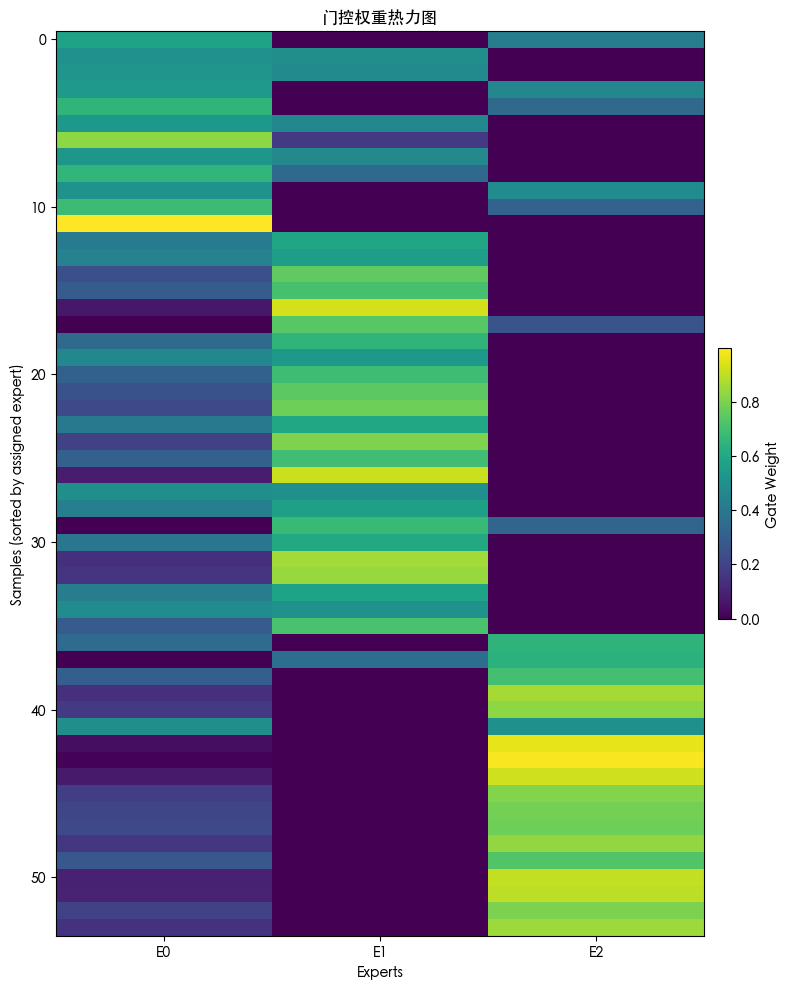


2. 各专家MAE热力图:


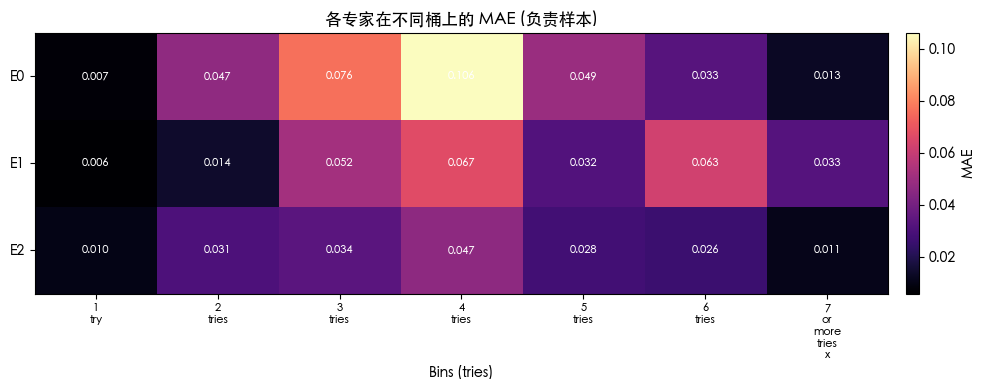


3. 样本专家分解图:


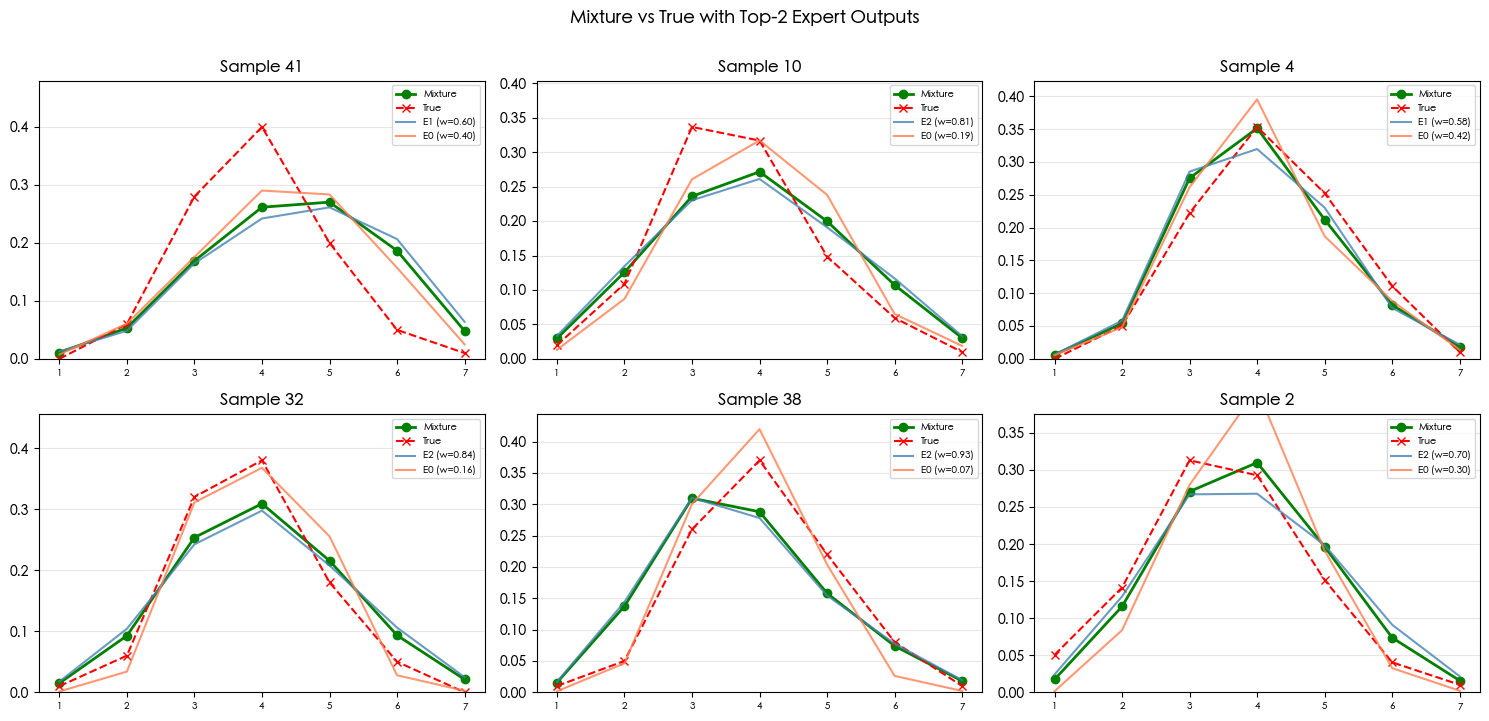

In [14]:
# 专家输出和门控权重计算
def compute_expert_outputs(model: MoE, X_data: np.ndarray):
    """
    返回 (y_experts, gates, y_mixture)
    - y_experts: shape (num_experts, n, 7)
    - gates:     shape (n, num_experts)
    - y_mixture: shape (n, 7) = sum_e gates[:, e] * y_experts[e]
    """
    model.eval()
    Xte = torch.tensor(X_data, device=DEVICE)
    with torch.no_grad():
        # 逐专家前向
        y_exps = []
        for exp in model.experts:
            y_exp = exp(Xte)  # (n, 7)
            y_exps.append(y_exp)
        y_experts = torch.stack(y_exps, dim=0)  # (E, n, 7)
        
        # 门控权重（top-k 后归一）
        gates, _ = model.noisy_top_k_gating(Xte, train=False)  # (n, E)
        
        # 混合输出
        y_mix = (gates.unsqueeze(-1) * y_experts.permute(1, 0, 2)).sum(dim=1)  # (n, 7)
    
    return (
        y_experts.cpu().numpy(),
        gates.cpu().numpy(),
        y_mix.cpu().numpy(),
    )


def plot_expert_gate_heatmap(gates: np.ndarray, max_samples: int = 500):
    """展示部分样本的门控权重热力图"""
    n = gates.shape[0]
    idx = np.arange(n)
    if n > max_samples:
        idx = np.random.choice(n, size=max_samples, replace=False)
    G = gates[idx]
    
    # 按分配专家排序
    assigned = G.argmax(axis=1)
    order = np.argsort(assigned)
    G = G[order]
    
    fig, ax = plt.subplots(figsize=(8, 10))
    im = ax.imshow(G, aspect="auto", cmap="viridis")
    ax.set_xlabel("Experts")
    ax.set_ylabel("Samples (sorted by assigned expert)")
    ax.set_xticks(np.arange(gates.shape[1]))
    ax.set_xticklabels([f"E{i}" for i in range(gates.shape[1])])
    ax.set_title("门控权重热力图")
    cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
    cbar.set_label("Gate Weight")
    plt.tight_layout()
    plt.show()


def plot_expert_mae_heatmap(P_true: np.ndarray, y_experts: np.ndarray, gates: np.ndarray):
    """按分配专家计算每个专家在各个桶的 MAE"""
    E = y_experts.shape[0]
    n = gates.shape[0]
    assigned = gates.argmax(axis=1)
    mae_mat = np.zeros((E, len(DIST_COLS)), dtype=float)
    
    for e in range(E):
        mask = assigned == e
        if not np.any(mask):
            continue
        pred_mean = y_experts[e, mask]  # (m, 7)
        true_sel = P_true[mask]
        mae_bins = np.mean(np.abs(pred_mean - true_sel), axis=0)
        mae_mat[e] = mae_bins
    
    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(mae_mat, aspect="auto", cmap="magma")
    ax.set_yticks(np.arange(E))
    ax.set_yticklabels([f"E{e}" for e in range(E)])
    ax.set_xticks(np.arange(len(DIST_COLS)))
    ax.set_xticklabels([c.replace("_", "\n") for c in DIST_COLS], fontsize=8)
    ax.set_xlabel("Bins (tries)")
    ax.set_title("各专家在不同桶上的 MAE (负责样本)")
    cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
    cbar.set_label("MAE")
    
    # 添加数值标注
    for i in range(E):
        for j in range(len(DIST_COLS)):
            text = ax.text(j, i, f"{mae_mat[i, j]:.3f}",
                          ha="center", va="center", color="white", fontsize=8)
    
    plt.tight_layout()
    plt.show()


def plot_sample_expert_decomposition(P_true: np.ndarray, y_experts: np.ndarray, 
                                     gates: np.ndarray, y_mix: np.ndarray, sample_size: int = 6):
    """随机抽样展示：True vs Mixture 以及 Top-2 专家的输出与权重"""
    n = P_true.shape[0]
    if n == 0:
        return
    idx = np.random.choice(n, size=min(sample_size, n), replace=False)
    x = np.arange(len(DIST_COLS))
    
    n_cols = 3
    n_rows = (len(idx) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.6 * n_rows))
    axes = np.atleast_2d(axes).flatten()
    
    for k, i in enumerate(idx):
        ax = axes[k]
        # mixture vs true
        ax.plot(x, y_mix[i], marker="o", linewidth=2, label="Mixture", color="green")
        ax.plot(x, P_true[i], linestyle="--", marker="x", label="True", color="red")
        
        # top-2 experts
        g = gates[i]
        top2 = np.argsort(-g)[:2]
        colors = ['steelblue', 'coral']
        for t_idx, t in enumerate(top2):
            ax.plot(x, y_experts[t, i], linewidth=1.5, alpha=0.8, 
                   label=f"E{t} (w={g[t]:.2f})", color=colors[t_idx])
        
        ax.set_xticks(x)
        ax.set_xticklabels([c.split("_")[0] for c in DIST_COLS], fontsize=7)
        ax.set_ylim(0, max(0.35, float(max(y_mix[i].max(), P_true[i].max())) * 1.2))
        ax.set_title(f"Sample {i}")
        ax.grid(axis="y", alpha=0.3)
        ax.legend(fontsize=7, loc="upper right")
    
    for k in range(len(idx), len(axes)):
        axes[k].set_visible(False)
    
    fig.suptitle("Mixture vs True with Top-2 Expert Outputs", fontsize=13, y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()


# 执行专家细粒度分析
print("计算专家输出和门控权重...")
y_experts, gates, y_mix = compute_expert_outputs(model, X_test)

print(f"专家输出形状: {y_experts.shape}")  # (E, n, 7)
print(f"门控权重形状: {gates.shape}")      # (n, E)
print(f"混合输出形状: {y_mix.shape}")      # (n, 7)

print("\n1. 门控权重热力图:")
plot_expert_gate_heatmap(gates, max_samples=300)

print("\n2. 各专家MAE热力图:")
plot_expert_mae_heatmap(P_test, y_experts, gates)

print("\n3. 样本专家分解图:")
plot_sample_expert_decomposition(P_test, y_experts, gates, y_mix, sample_size=6)

## 6.4 综合性能可视化

性能指标可视化


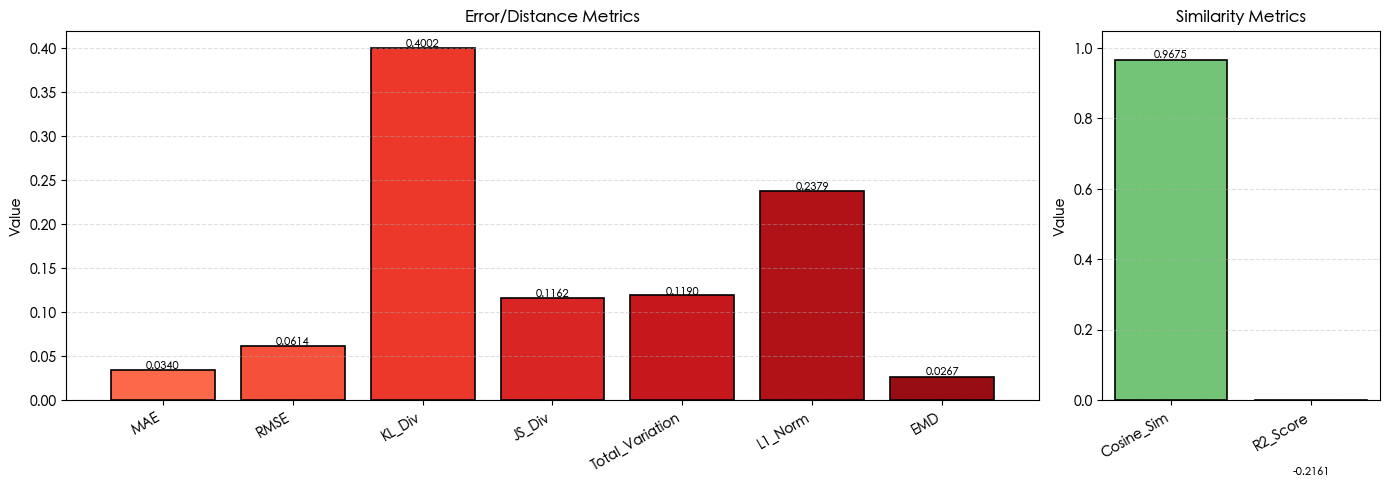


综合汇总图


/var/folders/0m/2sbyxxc10czg8dp3clzyzxym0000gn/T/ipykernel_71544/175347011.py:195: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.99])


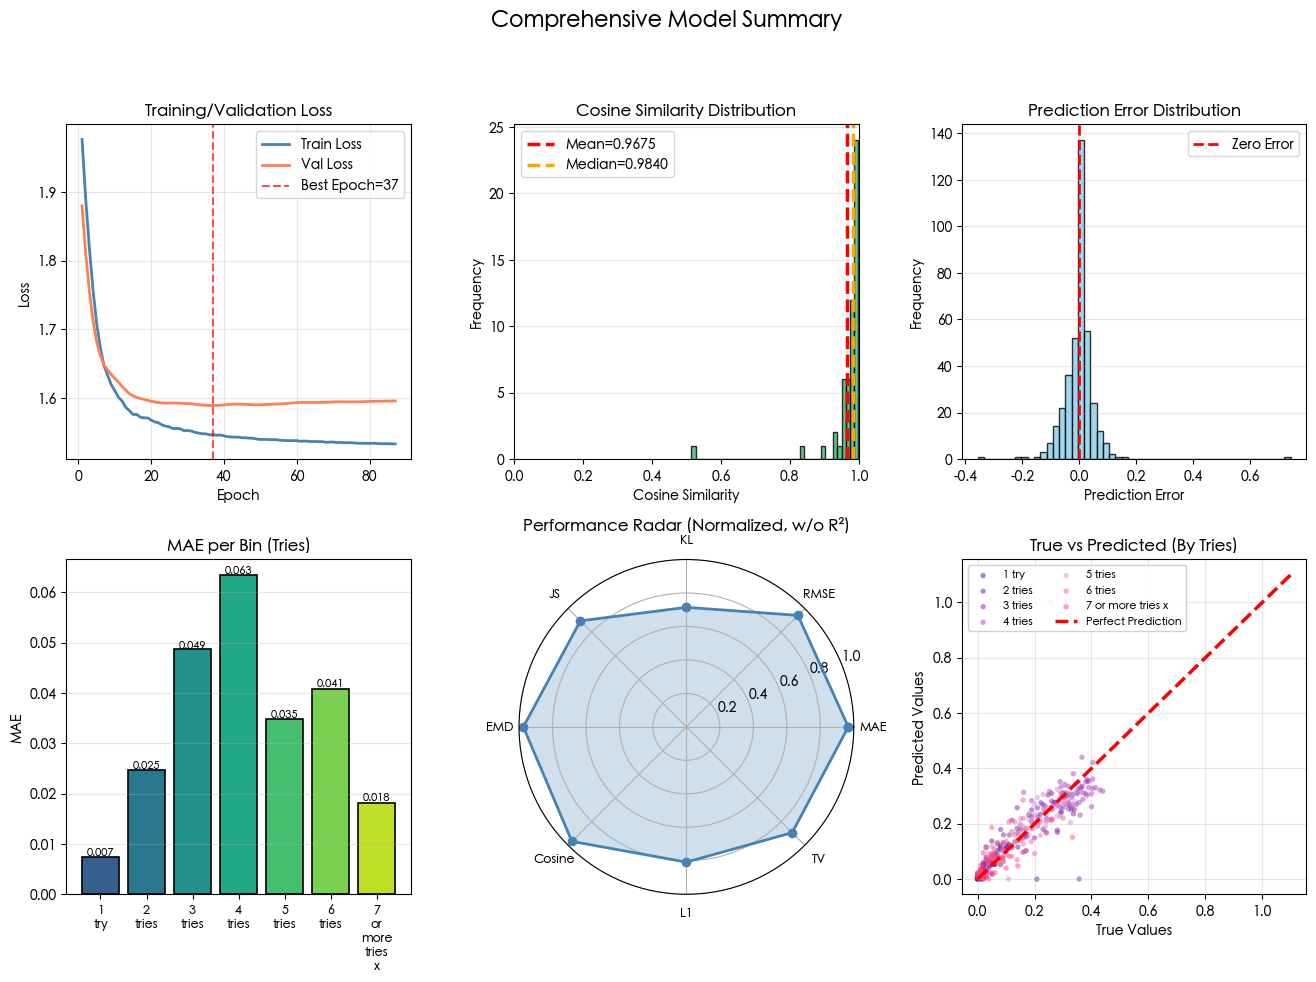

In [15]:
from typing import Dict

def plot_performance_metrics(metrics: Dict):
    """
    9指标综合可视化：MAE, RMSE, KL, JS, R2, EMD, Cosine, L1, Total Variation
    """
    metric_keys = ["MAE", "RMSE", "KL_Div", "JS_Div", "R2_Score", 
                   "EMD", "Cosine_Sim", "L1_Norm", "Total_Variation"]
    
    available_metrics = {k: v for k, v in metrics.items() if k in metric_keys}
    if not available_metrics:
        print("无可用性能指标")
        return
    
    keys = list(available_metrics.keys())
    values = list(available_metrics.values())
    
    # 按类别分组
    error_metrics = ["MAE", "RMSE", "KL_Div", "JS_Div", "L1_Norm", "Total_Variation", "EMD"]
    similarity_metrics = ["R2_Score", "Cosine_Sim"]
    
    error_keys = [k for k in keys if k in error_metrics]
    sim_keys = [k for k in keys if k in similarity_metrics]
    
    fig = plt.figure(figsize=(14, 5))
    gs = fig.add_gridspec(1, 2, width_ratios=[len(error_keys), len(sim_keys)])
    
    # 子图1: 误差指标
    ax1 = fig.add_subplot(gs[0, 0])
    error_vals = [available_metrics[k] for k in error_keys]
    colors1 = plt.cm.Reds(np.linspace(0.5, 0.9, len(error_keys)))
    bars1 = ax1.bar(range(len(error_keys)), error_vals, color=colors1, edgecolor='black', linewidth=1.2)
    ax1.set_xticks(range(len(error_keys)))
    ax1.set_xticklabels(error_keys, rotation=30, ha="right")
    ax1.set_ylabel("Value", fontweight='bold')
    ax1.set_title("Error/Distance Metrics", fontweight='bold', fontsize=12)
    ax1.grid(axis='y', alpha=0.4, linestyle='--')
    
    # 添加数值标注
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height, 
                f'{error_vals[i]:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # 子图2: 相似度指标
    ax2 = fig.add_subplot(gs[0, 1])
    sim_vals = [available_metrics[k] for k in sim_keys]
    colors2 = plt.cm.Greens(np.linspace(0.5, 0.9, len(sim_keys)))
    bars2 = ax2.bar(range(len(sim_keys)), sim_vals, color=colors2, edgecolor='black', linewidth=1.2)
    ax2.set_xticks(range(len(sim_keys)))
    ax2.set_xticklabels(sim_keys, rotation=30, ha="right")
    ax2.set_ylabel("Value", fontweight='bold')
    ax2.set_title("Similarity Metrics", fontweight='bold', fontsize=12)
    ax2.grid(axis='y', alpha=0.4, linestyle='--')
    ax2.set_ylim([0, 1.05])
    
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height, 
                f'{sim_vals[i]:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


def plot_comprehensive_summary(info: Dict, metrics: Dict, P_test: np.ndarray, P_pred: np.ndarray):
    """
    综合汇总图：包括训练曲线、余弦相似度分布、预测误差、指标雷达图（无R²）
    """
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # 1. 训练/验证损失
    ax1 = fig.add_subplot(gs[0, 0])
    epochs = range(1, len(info["train_losses"]) + 1)
    ax1.plot(epochs, info["train_losses"], label="Train Loss", linewidth=2, color='steelblue')
    ax1.plot(epochs, info["val_losses"], label="Val Loss", linewidth=2, color='coral')
    if info.get("best_epoch"):
        ax1.axvline(info["best_epoch"], linestyle='--', color='red', alpha=0.7, label=f"Best Epoch={info['best_epoch']}")
    ax1.set_xlabel("Epoch", fontweight='bold')
    ax1.set_ylabel("Loss", fontweight='bold')
    ax1.set_title("Training/Validation Loss", fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # 2. 余弦相似度分布（替换辅助损失）
    ax2 = fig.add_subplot(gs[0, 1])
    # 计算每个样本的余弦相似度
    from sklearn.metrics.pairwise import cosine_similarity
    cosine_sims = []
    for i in range(len(P_test)):
        sim = cosine_similarity([P_test[i]], [P_pred[i]])[0, 0]
        cosine_sims.append(sim)
    cosine_sims = np.array(cosine_sims)
    
    ax2.hist(cosine_sims, bins=40, color='mediumseagreen', edgecolor='black', alpha=0.8)
    ax2.axvline(np.mean(cosine_sims), color='red', linestyle='--', linewidth=2.5, 
               label=f'Mean={np.mean(cosine_sims):.4f}')
    ax2.axvline(np.median(cosine_sims), color='orange', linestyle='--', linewidth=2.5, 
               label=f'Median={np.median(cosine_sims):.4f}')
    ax2.set_xlabel("Cosine Similarity", fontweight='bold')
    ax2.set_ylabel("Frequency", fontweight='bold')
    ax2.set_title("Cosine Similarity Distribution", fontweight='bold')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_xlim([0, 1])
    
    # 3. 预测误差分布
    ax3 = fig.add_subplot(gs[0, 2])
    errors = P_pred - P_test
    errors_flat = errors.flatten()
    ax3.hist(errors_flat, bins=50, color='skyblue', edgecolor='black', alpha=0.8)
    ax3.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax3.set_xlabel("Prediction Error", fontweight='bold')
    ax3.set_ylabel("Frequency", fontweight='bold')
    ax3.set_title("Prediction Error Distribution", fontweight='bold')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. 各桶MAE
    ax4 = fig.add_subplot(gs[1, 0])
    mae_per_bin = np.mean(np.abs(errors), axis=0)
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(DIST_COLS)))
    bars = ax4.bar(range(len(DIST_COLS)), mae_per_bin, color=colors, edgecolor='black', linewidth=1.2)
    ax4.set_xticks(range(len(DIST_COLS)))
    ax4.set_xticklabels([c.replace("_", "\n") for c in DIST_COLS], fontsize=9)
    ax4.set_ylabel("MAE", fontweight='bold')
    ax4.set_title("MAE per Bin (Tries)", fontweight='bold')
    ax4.grid(axis='y', alpha=0.3)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2, height, f'{mae_per_bin[i]:.3f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # 5. 性能指标雷达图（去除R²）
    ax5 = fig.add_subplot(gs[1, 1], projection='polar')
    metric_labels = ["MAE", "RMSE", "KL", "JS", "EMD", "Cosine", "L1", "TV"]
    metric_keys = ["MAE", "RMSE", "KL_Div", "JS_Div", "EMD", "Cosine_Sim", "L1_Norm", "Total_Variation"]
    
    # 归一化指标到 [0, 1]，相似度越高越好，误差越低越好
    normalized = []
    for k in metric_keys:
        if k not in metrics:
            normalized.append(0)
            continue
        v = metrics[k]
        if k in ["Cosine_Sim"]:
            normalized.append(max(0, min(1, v)))  # 已经在[0,1]或[-1,1]
        else:
            # 误差类指标：转化为 1 / (1 + error)
            normalized.append(1 / (1 + v))
    
    angles = np.linspace(0, 2 * np.pi, len(metric_labels), endpoint=False).tolist()
    normalized += normalized[:1]
    angles += angles[:1]
    
    ax5.plot(angles, normalized, 'o-', linewidth=2, color='steelblue')
    ax5.fill(angles, normalized, alpha=0.25, color='steelblue')
    ax5.set_xticks(angles[:-1])
    ax5.set_xticklabels(metric_labels, fontsize=9)
    ax5.set_ylim(0, 1)
    ax5.set_title("Performance Radar (Normalized, w/o R²)", fontweight='bold', pad=20)
    ax5.grid(True)
    
    # 6. 真实值 vs 预测值散点图（不同尝试次数用不同颜色）
    ax6 = fig.add_subplot(gs[1, 2])
    
    # 为7个尝试次数定义不同颜色
    bin_colors = [
        '#4A148C',  # 1 try - 深紫色
        '#6A1B9A',  # 2 tries - 紫罗兰
        '#8E24AA',  # 3 tries - 亮紫色
        '#AB47BC',  # 4 tries - 淡紫色
        '#CE93D8',  # 5 tries - 浅紫色
        '#F06292',  # 6 tries - 玫瑰粉
        '#FF4081',  # 7 tries - 明亮粉
    ]
    
    # 按桶绘制散点
    for bin_idx in range(len(DIST_COLS)):
        ax6.scatter(P_test[:, bin_idx], P_pred[:, bin_idx], 
                   alpha=0.5, s=15, color=bin_colors[bin_idx], 
                   label=DIST_COLS[bin_idx].replace("_", " "),
                   edgecolors='none')
    
    lims = [0, max(P_test.max(), P_pred.max()) * 1.1]
    ax6.plot(lims, lims, 'r--', linewidth=2.5, label='Perfect Prediction', zorder=10)
    ax6.set_xlabel("True Values", fontweight='bold')
    ax6.set_ylabel("Predicted Values", fontweight='bold')
    ax6.set_title("True vs Predicted (By Tries)", fontweight='bold')
    ax6.legend(loc='upper left', fontsize=8, ncol=2, framealpha=0.9)
    ax6.grid(alpha=0.3)
    
    plt.suptitle("Comprehensive Model Summary", fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()


# 执行综合性能可视化
print("=" * 60)
print("性能指标可视化")
print("=" * 60)
plot_performance_metrics(metrics)

print("\n" + "=" * 60)
print("综合汇总图")
print("=" * 60)
plot_comprehensive_summary(info, metrics, P_test, P_pred)

## 7. Bootstrap不确定性估计

通过多次重采样训练集并训练模型，收集预测的经验分布，从而估计预测的不确定性（均值、标准差、置信区间）

In [16]:
def bootstrap_predict(X_train, P_train, N_train, X_val, P_val, N_val, X_test, B=BOOTSTRAP_B):
    """Bootstrap方法估计预测的不确定性"""
    P_test_all = []
    n_train = X_train.shape[0]
    
    Wva = (
        torch.tensor(make_weights_from_N(N_val, WEIGHT_MODE), device=DEVICE)
        if N_val is not None else None
    )
    
    old_epochs = MAX_EPOCHS
    bootstrap_epochs = max(1, int(old_epochs * BOOTSTRAP_EPOCH_SCALE))
    
    for b in range(B):
        print(f"[Bootstrap] Run {b + 1}/{B}", end="\r")
        
        # Bootstrap重采样
        idx = np.random.choice(n_train, size=n_train, replace=True)
        Xb = X_train[idx]
        Pb = P_train[idx]
        Nb = N_train[idx] if N_train is not None else None
        
        Wb = (
            torch.tensor(make_weights_from_N(Nb, WEIGHT_MODE), device=DEVICE)
            if Nb is not None else None
        )
        
        # 临时降低训练轮次
        globals()["MAX_EPOCHS"] = bootstrap_epochs
        try:
            model_b, _ = train_moe_with_params(
                Xb, Pb, X_val, P_val, Wb, Wva,
                num_experts=NUM_EXPERTS, hidden_size=HIDDEN_SIZE, top_k=TOP_K,
                aux_coef=AUX_COEF, expert_diversity_coef=EXPERT_DIVERSITY_COEF,
            )
        finally:
            globals()["MAX_EPOCHS"] = old_epochs
        
        # 在测试集上预测
        model_b.eval()
        with torch.no_grad():
            Xte = torch.tensor(X_test, device=DEVICE)
            P_pred_b, _ = model_b(Xte)
            P_pred_b = P_pred_b.cpu().numpy()
        
        P_test_all.append(P_pred_b)
    
    print()  # 换行
    return np.stack(P_test_all, axis=0)  # shape: (B, n_test, 7)


def bootstrap_summary(P_boot, ci_level=BOOTSTRAP_CI_LEVEL):
    """对Bootstrap预测做聚合，返回 (mean, std, low, high)"""
    alpha_low = (1 - ci_level) / 2
    alpha_high = 1 - alpha_low
    
    P_mean = P_boot.mean(axis=0)
    P_std = P_boot.std(axis=0)
    P_low = np.percentile(P_boot, alpha_low * 100, axis=0)
    P_high = np.percentile(P_boot, alpha_high * 100, axis=0)
    
    return P_mean, P_std, P_low, P_high


print("Bootstrap函数已定义")

Bootstrap函数已定义


In [17]:
# 执行Bootstrap不确定性估计（可根据需要调整B的值）
# 注意：B=100次会花费较长时间，可以先用B=10测试

print("\n" + "="*70)
print("开始Bootstrap不确定性估计")
print(f"Bootstrap次数: {BOOTSTRAP_B}, 训练轮次缩放: {BOOTSTRAP_EPOCH_SCALE}")
print("="*70)

P_boot = bootstrap_predict(X_train, P_train, N_train, X_val, P_val, N_val, X_test, B=BOOTSTRAP_B)

print(f"\nBootstrap预测矩阵形状: {P_boot.shape}")  # (B, n_test, 7)

# 计算汇总统计量
P_mean, P_std, P_low, P_high = bootstrap_summary(P_boot, ci_level=BOOTSTRAP_CI_LEVEL)

print(f"\n汇总统计：")
print(f"  P_mean形状: {P_mean.shape}")
print(f"  P_std平均: {P_std.mean():.6f}")
print(f"  置信区间宽度平均: {(P_high - P_low).mean():.6f}")

# 用Bootstrap均值评估
bootstrap_metrics = compute_metrics(P_mean, P_test)
print(f"\nBootstrap均值预测的性能:")
for k, v in bootstrap_metrics.items():
    print(f"  {k}: {v:.6f}")


开始Bootstrap不确定性估计
Bootstrap次数: 100, 训练轮次缩放: 0.6
[Epoch  50] train_loss=1.5260 val_loss=1.6084 aux=0.001225 div=0.001978
Early stopping at epoch 88
[Epoch  50] train_loss=1.5384 val_loss=1.5908 aux=0.000034 div=0.004507
[Epoch 100] train_loss=1.5319 val_loss=1.5918 aux=0.000139 div=0.005322
Early stopping at epoch 107
[Epoch  50] train_loss=1.5365 val_loss=1.5877 aux=0.000360 div=0.002710
Early stopping at epoch 98
[Epoch  50] train_loss=1.5465 val_loss=1.5937 aux=0.000473 div=0.002231
[Epoch 100] train_loss=1.5404 val_loss=1.5999 aux=0.000446 div=0.002442
Early stopping at epoch 105
[Epoch  50] train_loss=1.5363 val_loss=1.5913 aux=0.001173 div=0.001018
Early stopping at epoch 80
[Epoch  50] train_loss=1.5335 val_loss=1.5838 aux=0.000444 div=0.003714
[Epoch 100] train_loss=1.5289 val_loss=1.5859 aux=0.000708 div=0.004131
Early stopping at epoch 102
[Epoch  50] train_loss=1.5306 val_loss=1.5965 aux=0.000252 div=0.003587
Early stopping at epoch 90
[Epoch  50] train_loss=1.5316 val_loss=

## 8. 不确定性可视化

可视化Bootstrap预测的不确定性，包括整体平均分布和不确定性最大的样本

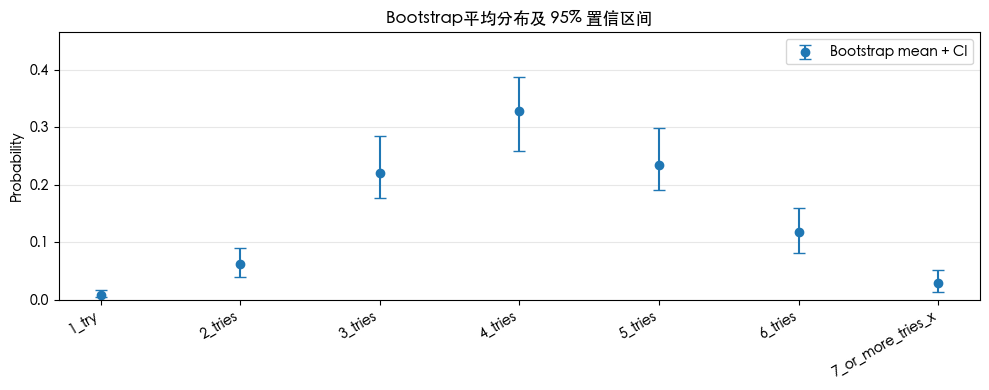

各桶的平均预测: [0.00871552 0.06261769 0.21975057 0.32777748 0.23436573 0.11745992
 0.02931195]


In [18]:
# 整体平均分布的不确定性
mean_all = P_mean.mean(axis=0)
low_all = P_low.mean(axis=0)
high_all = P_high.mean(axis=0)
yerr_all = np.vstack([np.maximum(0, mean_all - low_all), np.maximum(0, high_all - mean_all)])

x = np.arange(len(DIST_COLS))
fig, ax = plt.subplots(figsize=(10, 4))
ax.errorbar(x, mean_all, yerr=yerr_all, fmt="o", capsize=4, label="Bootstrap mean + CI")
ax.set_xticks(x)
ax.set_xticklabels(DIST_COLS, rotation=30, ha="right")
ax.set_ylim(0.0, max(0.35, float(high_all.max()) * 1.2))
ax.set_title(f"Bootstrap平均分布及 {BOOTSTRAP_CI_LEVEL:.0%} 置信区间")
ax.set_ylabel("Probability")
ax.grid(True, axis="y", alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

print(f"各桶的平均预测: {mean_all}")

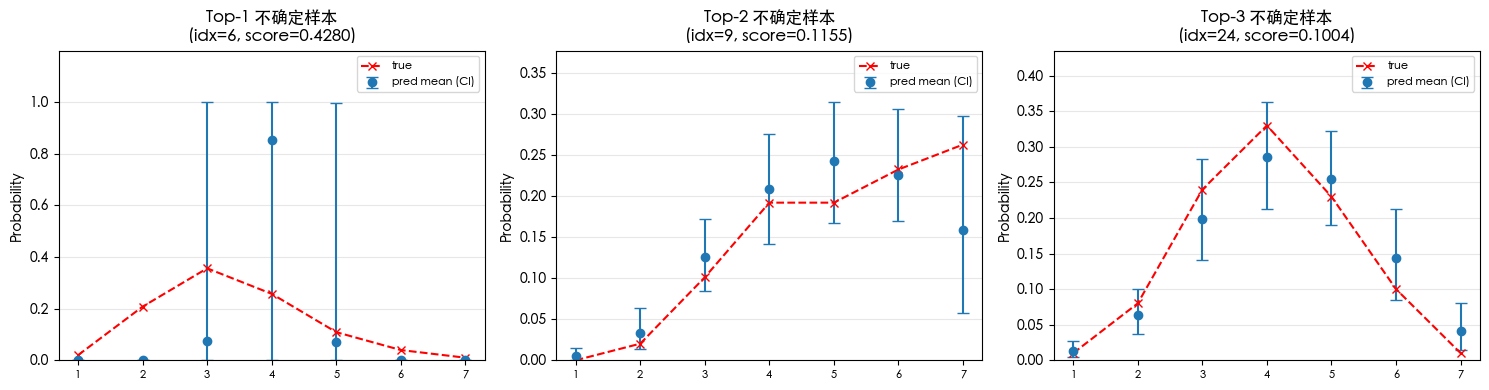


不确定性最高的3个样本索引: [ 6  9 24]
不确定性得分: [0.42799716 0.11552042 0.10043556]


In [19]:
# 不确定性最大的样本
ci_width = (P_high - P_low)
unc_score = ci_width.mean(axis=1)
idx_sorted = np.argsort(-unc_score)

# 显示Top 3不确定样本
top_k = 3
fig, axes = plt.subplots(1, top_k, figsize=(15, 4))

for rank in range(top_k):
    i = int(idx_sorted[rank])
    m = P_mean[i]
    lo = P_low[i]
    hi = P_high[i]
    yerr = np.vstack([np.maximum(0, m - lo), np.maximum(0, hi - m)])
    
    ax = axes[rank]
    ax.errorbar(x, m, yerr=yerr, fmt="o", capsize=4, label="pred mean (CI)")
    ax.plot(x, P_test[i], linestyle="--", marker="x", label="true", color="red")
    ax.set_xticks(x)
    ax.set_xticklabels([c.split("_")[0] for c in DIST_COLS], fontsize=8)
    ax.set_ylim(0.0, max(0.35, float(hi.max()) * 1.2))
    ax.set_title(f"Top-{rank+1} 不确定样本\n(idx={i}, score={unc_score[i]:.4f})")
    ax.set_ylabel("Probability")
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

print(f"\n不确定性最高的3个样本索引: {idx_sorted[:3]}")
print(f"不确定性得分: {unc_score[idx_sorted[:3]]}")

In [20]:
# 打印不确定性最高的3个样本的特征值
print("\n" + "="*80)
print("不确定性最高的3个样本 - 特征分析")
print("="*80)

top_3_uncertain = idx_sorted[:3]

for rank, sample_idx in enumerate(top_3_uncertain):
    print(f"\n{'='*80}")
    print(f"Top-{rank+1} 不确定样本 (测试集索引: {sample_idx})")
    print(f"不确定性得分: {unc_score[sample_idx]:.6f}")
    print(f"{'='*80}")
    
    # 获取该样本的特征值
    sample_features = X_test[sample_idx]
    
    # 打印所有特征
    print("\n特征值:")
    print("-" * 80)
    for feat_name, feat_val in zip(FEATURE_COLS, sample_features):
        print(f"  {feat_name:.<50} {feat_val:>10.6f}")
    
    # 打印真实分布 vs 预测分布
    print("\n真实分布 vs Bootstrap预测:")
    print("-" * 80)
    print(f"{'桶名':<25} {'真实值':>10} {'预测均值':>10} {'标准差':>10} {'CI下界':>10} {'CI上界':>10}")
    print("-" * 80)
    for i, col in enumerate(DIST_COLS):
        true_val = P_test[sample_idx, i]
        pred_mean = P_mean[sample_idx, i]
        pred_std = P_std[sample_idx, i]
        ci_low = P_low[sample_idx, i]
        ci_high = P_high[sample_idx, i]
        print(f"{col:<25} {true_val:>10.6f} {pred_mean:>10.6f} {pred_std:>10.6f} "
              f"{ci_low:>10.6f} {ci_high:>10.6f}")
    
    # 计算该样本的预测误差
    mae_sample = np.mean(np.abs(P_mean[sample_idx] - P_test[sample_idx]))
    print(f"\n样本MAE: {mae_sample:.6f}")
    print(f"平均CI宽度: {ci_width[sample_idx].mean():.6f}")

print("\n" + "="*80)
print("特征分析完成")
print("="*80)


不确定性最高的3个样本 - 特征分析

Top-1 不确定样本 (测试集索引: 6)
不确定性得分: 0.427997

特征值:
--------------------------------------------------------------------------------
  Zipf-value........................................  -0.540117
  letter_entropy....................................   0.601963
  feedback_entropy..................................   1.795443
  max_consecutive_vowels............................   1.884669
  letter_freq_mean..................................   1.016438
  scrabble_score....................................  -1.503846
  has_common_suffix.................................  -0.294884
  num_rare_letters..................................  -0.483006
  position_rarity...................................  -0.660813
  positional_freq_min...............................   0.461532
  hamming_neighbors.................................  -0.178761
  keyboard_distance.................................   1.109384
  semantic_distance.................................   0.863675
  1_try_simulate_ran

## 9. 结果保存与总结

In [21]:
# 保存预测结果
# 单模型预测
df_single = pd.DataFrame(P_pred, columns=[f"moe_pred_{c}" for c in DIST_COLS])
df_single.to_csv(os.path.join(OUTPUT_DIR, "moe_softmax_pred_output.csv"), index=False)

# Bootstrap汇总预测
data = {}
for i, col in enumerate(DIST_COLS):
    data[f"mean_{col}"] = P_mean[:, i]
    data[f"std_{col}"] = P_std[:, i]
    data[f"ci_low_{col}"] = P_low[:, i]
    data[f"ci_high_{col}"] = P_high[:, i]
df_bootstrap = pd.DataFrame(data)
df_bootstrap.to_csv(os.path.join(OUTPUT_DIR, "moe_bootstrap_pred_summary.csv"), index=False)

# 保存配置和指标报告
report = {
    "model": "MoE + MLP + Softmax + Bootstrap",
    "config": {
        "num_experts": NUM_EXPERTS,
        "hidden_size": HIDDEN_SIZE,
        "top_k": TOP_K,
        "aux_coef": AUX_COEF,
        "expert_diversity_coef": EXPERT_DIVERSITY_COEF,
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "max_epochs": MAX_EPOCHS,
        "patience": PATIENCE,
    },
    "bootstrap": {
        "B": BOOTSTRAP_B,
        "epoch_scale": BOOTSTRAP_EPOCH_SCALE,
        "ci_level": BOOTSTRAP_CI_LEVEL,
    },
    "metrics": {
        "single_model": metrics,
        "bootstrap_mean": bootstrap_metrics,
    },
    "training": {
        "best_epoch": info["best_epoch"],
        "best_val_loss": info["best_val_loss"],
    },
}

with open(os.path.join(OUTPUT_DIR, "moe_bootstrap_report.json"), "w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)

print(f"结果已保存到: {OUTPUT_DIR}/")
print(f"  - moe_softmax_pred_output.csv (单模型预测)")
print(f"  - moe_bootstrap_pred_summary.csv (Bootstrap汇总)")
print(f"  - moe_bootstrap_report.json (配置和指标报告)")

结果已保存到: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/
  - moe_softmax_pred_output.csv (单模型预测)
  - moe_bootstrap_pred_summary.csv (Bootstrap汇总)
  - moe_bootstrap_report.json (配置和指标报告)


## 9.2 Holdout单词预测（eerie）

对 holdout 单词 "eerie" 进行分布预测，并绘制：
1. **柱状图 + 置信区间**：展示 bootstrap 均值预测及其不确定性
2. **小提琴图**：展示 bootstrap 重采样预测的完整分布形态

In [22]:
# 检查是否有 holdout 数据
if holdout_pack is None or holdout_pack.get("X") is None:
    print("未找到 holdout 数据（eerie），请确保数据加载时正确分离了 holdout 样本")
else:
    print(f"发现 holdout 数据: {len(holdout_pack.get('word', []))} 个样本")
    print(f"单词: {holdout_pack.get('word', [])}")
    
    # 获取 holdout 数据
    X_holdout = holdout_pack["X"]
    words_holdout = holdout_pack.get("word", [HOLDOUT_WORD])
    P_true_holdout = holdout_pack.get("P_true")
    
    print(f"\nHoldout 特征形状: {X_holdout.shape}")
    if P_true_holdout is not None:
        print(f"Holdout 真实分布形状: {P_true_holdout.shape}")
    
    # 1. 单模型预测
    print("\n" + "="*60)
    print("单模型预测（无不确定性估计）")
    print("="*60)
    model.eval()
    with torch.no_grad():
        X_hold_tensor = torch.tensor(X_holdout, device=DEVICE)
        P_single_holdout, _ = model(X_hold_tensor)
        P_single_holdout = P_single_holdout.cpu().numpy()
    
    print(f"单模型预测形状: {P_single_holdout.shape}")
    for i, word in enumerate(words_holdout):
        print(f"\n单词 '{word}' 的预测分布:")
        for j, col in enumerate(DIST_COLS):
            pred_val = P_single_holdout[i, j]
            true_val = P_true_holdout[i, j] if P_true_holdout is not None else None
            if true_val is not None:
                print(f"  {col}: pred={pred_val:.4f}, true={true_val:.4f}, diff={pred_val-true_val:+.4f}")
            else:
                print(f"  {col}: pred={pred_val:.4f}")
    
    # 2. Bootstrap 预测（获取不确定性）
    print("\n" + "="*60)
    print("Bootstrap 预测（包含不确定性估计）")
    print("="*60)
    
    # 使用现有的 bootstrap 函数进行预测
    from models.moe import MoE
    
    def bootstrap_predict_holdout(X_train, P_train, N_train, X_val, P_val, N_val, 
                                  X_holdout, B=BOOTSTRAP_B):
        """对 holdout 数据进行 bootstrap 预测"""
        n_holdout = X_holdout.shape[0]
        P_holdout_boot = np.zeros((B, n_holdout, len(DIST_COLS)))
        
        for b in range(B):
            # 重采样训练集
            n_train = X_train.shape[0]
            idx = np.random.choice(n_train, size=n_train, replace=True)
            X_b = X_train[idx]
            P_b = P_train[idx]
            N_b = N_train[idx] if N_train is not None else None
            
            # 训练模型
            Wtr_b = torch.tensor(make_weights_from_N(N_b, WEIGHT_MODE), device=DEVICE) if N_b is not None else None
            model_b, _ = train_moe_with_params(
                X_train=X_b, P_train=P_b, X_val=X_val, P_val=P_val,
                Wtr=Wtr_b, Wva=Wva,
                num_experts=NUM_EXPERTS, hidden_size=HIDDEN_SIZE, top_k=TOP_K,
                aux_coef=AUX_COEF, expert_diversity_coef=EXPERT_DIVERSITY_COEF,
            )
            
            # 预测 holdout
            model_b.eval()
            with torch.no_grad():
                X_h_tensor = torch.tensor(X_holdout, device=DEVICE)
                P_pred_h, _ = model_b(X_h_tensor)
                P_holdout_boot[b] = P_pred_h.cpu().numpy()
            
            if (b + 1) % 20 == 0:
                print(f"  Bootstrap 进度: {b+1}/{B}")
        
        return P_holdout_boot
    
    # 执行 bootstrap 预测
    P_holdout_boot = bootstrap_predict_holdout(
        X_train, P_train, N_train, X_val, P_val, N_val, X_holdout, B=BOOTSTRAP_B
    )
    
    # 计算统计量
    P_mean_holdout = P_holdout_boot.mean(axis=0)
    P_std_holdout = P_holdout_boot.std(axis=0)
    ci_level = BOOTSTRAP_CI_LEVEL
    alpha_low = (1 - ci_level) / 2
    alpha_high = 1 - alpha_low
    P_low_holdout = np.percentile(P_holdout_boot, alpha_low * 100, axis=0)
    P_high_holdout = np.percentile(P_holdout_boot, alpha_high * 100, axis=0)
    
    print(f"\nBootstrap 预测完成: {BOOTSTRAP_B} 次重采样")
    print(f"置信水平: {ci_level*100:.0f}%")
    
    for i, word in enumerate(words_holdout):
        print(f"\n单词 '{word}' 的 Bootstrap 预测统计:")
        for j, col in enumerate(DIST_COLS):
            mean_val = P_mean_holdout[i, j]
            std_val = P_std_holdout[i, j]
            low_val = P_low_holdout[i, j]
            high_val = P_high_holdout[i, j]
            true_val = P_true_holdout[i, j] if P_true_holdout is not None else None
            
            if true_val is not None:
                in_ci = "✓" if low_val <= true_val <= high_val else "✗"
                print(f"  {col}: mean={mean_val:.4f}±{std_val:.4f}, "
                      f"CI=[{low_val:.4f}, {high_val:.4f}], true={true_val:.4f} {in_ci}")
            else:
                print(f"  {col}: mean={mean_val:.4f}±{std_val:.4f}, "
                      f"CI=[{low_val:.4f}, {high_val:.4f}]")

发现 holdout 数据: 1 个样本
单词: ['eerie']

Holdout 特征形状: (1, 55)
Holdout 真实分布形状: (1, 7)

单模型预测（无不确定性估计）
单模型预测形状: (1, 7)

单词 'eerie' 的预测分布:
  1_try: pred=0.0001, true=0.1429, diff=-0.1428
  2_tries: pred=0.0429, true=0.1429, diff=-0.0999
  3_tries: pred=0.1829, true=0.1429, diff=+0.0401
  4_tries: pred=0.3663, true=0.1429, diff=+0.2234
  5_tries: pred=0.3055, true=0.1429, diff=+0.1627
  6_tries: pred=0.0964, true=0.1429, diff=-0.0464
  7_or_more_tries_x: pred=0.0058, true=0.1429, diff=-0.1370

Bootstrap 预测（包含不确定性估计）
[Epoch  50] train_loss=1.5369 val_loss=1.5896 aux=0.000655 div=0.002081
Early stopping at epoch 93
[Epoch  50] train_loss=1.5307 val_loss=1.5859 aux=0.000149 div=0.003815
[Epoch 100] train_loss=1.5249 val_loss=1.5874 aux=0.000268 div=0.004313
Early stopping at epoch 102
[Epoch  50] train_loss=1.5230 val_loss=1.5943 aux=0.000092 div=0.002501
Early stopping at epoch 73
[Epoch  50] train_loss=1.5396 val_loss=1.5905 aux=0.000249 div=0.003719
Early stopping at epoch 90
[Epoch  50] train


可视化 1: 柱状图 + 置信区间


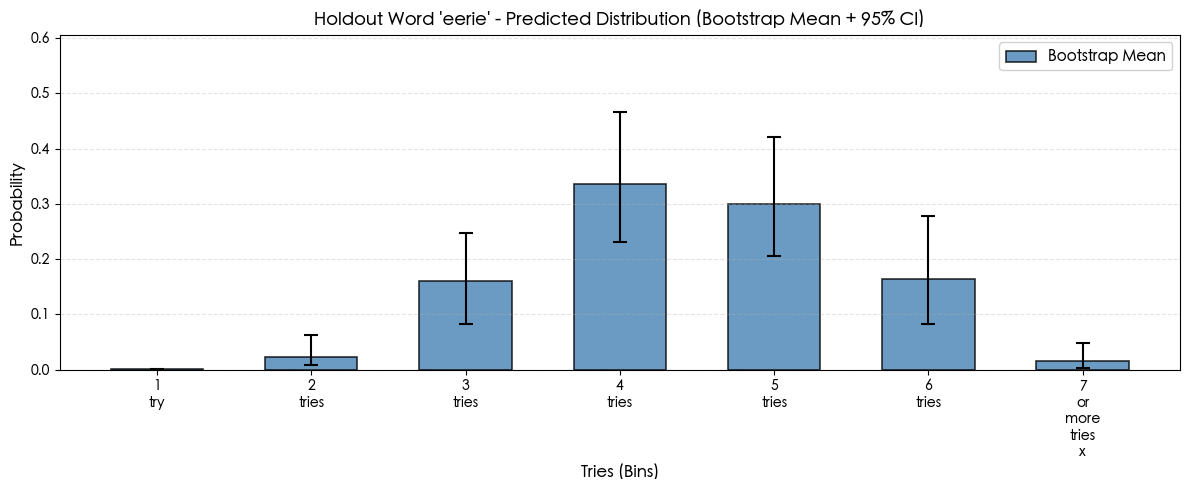

In [23]:
# 绘制 holdout 预测的柱状图（带置信区间）
def plot_holdout_bar_with_ci_notebook(P_mean, P_low, P_high, P_true, word):
    """绘制 holdout 单词的预测分布柱状图（带置信区间）"""
    # 如果有多个样本，取平均
    if P_mean.ndim > 1:
        mean = P_mean.mean(axis=0)
        low = P_low.mean(axis=0)
        high = P_high.mean(axis=0)
        if P_true is not None and P_true.ndim > 1:
            true_mean = P_true.mean(axis=0)
        else:
            true_mean = P_true
    else:
        mean = P_mean
        low = P_low
        high = P_high
        true_mean = P_true
    
    # 计算误差条（确保非负）
    yerr_low = np.maximum(0, mean - low)
    yerr_high = np.maximum(0, high - mean)
    yerr = np.vstack([yerr_low, yerr_high])
    
    fig, ax = plt.subplots(figsize=(12, 5))
    x = np.arange(len(DIST_COLS))
    width = 0.6
    
    # 绘制柱状图
    bars = ax.bar(x, mean, width, color="steelblue", alpha=0.8, label="Bootstrap Mean", edgecolor='black', linewidth=1.2)
    
    # 添加误差条
    ax.errorbar(x, mean, yerr=yerr, fmt="none", ecolor="black", capsize=5, linewidth=1.5, capthick=1.5)

    ax.set_xticks(x)
    ax.set_xticklabels([c.replace("_", "\n") for c in DIST_COLS], fontsize=10)
    ax.set_xlabel("Tries (Bins)", fontweight='bold', fontsize=12)
    ax.set_ylabel("Probability", fontweight='bold', fontsize=12)
    ax.set_ylim(0.0, max(0.4, float(high.max()) * 1.3))
    ax.set_title(f"Holdout Word '{word}' - Predicted Distribution (Bootstrap Mean + {int(BOOTSTRAP_CI_LEVEL*100)}% CI)", 
                fontweight='bold', fontsize=13)
    ax.grid(axis="y", alpha=0.35, linestyle='--')
    ax.legend(loc="upper right", fontsize=11, framealpha=0.9)
    plt.tight_layout()
    plt.show()


# 绘制柱状图
print("\n" + "="*60)
print("可视化 1: 柱状图 + 置信区间")
print("="*60)
plot_holdout_bar_with_ci_notebook(
    P_mean=P_mean_holdout,
    P_low=P_low_holdout,
    P_high=P_high_holdout,
    P_true=P_true_holdout,
    word=HOLDOUT_WORD
)


可视化 2: 小提琴图（Bootstrap 分布形态）


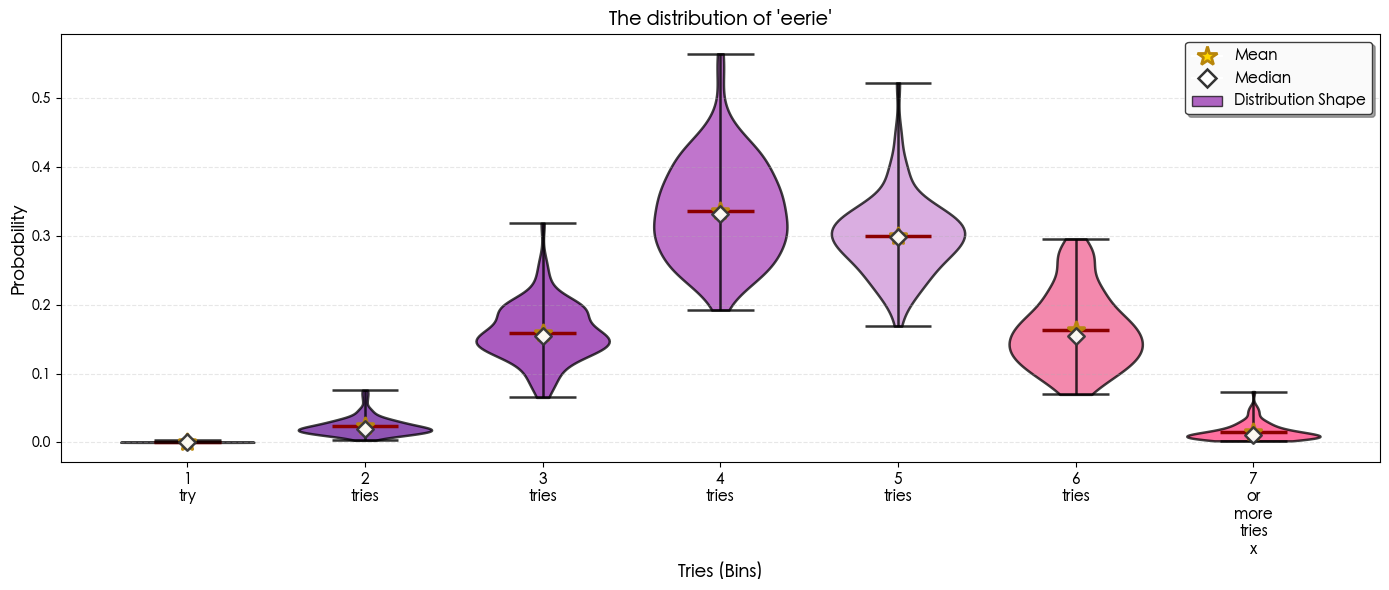

In [24]:
# 绘制 holdout 预测的小提琴图（美化版，每个桶不同颜色）
def plot_holdout_violin_notebook(P_holdout_boot, word):
    """绘制 holdout 单词的 bootstrap 预测分布小提琴图
    
    P_holdout_boot: shape (B, n_holdout, 7)
    将每个桶的 (B * n_holdout) 个预测值绘制为一个小提琴
    """
    B, n_h, d = P_holdout_boot.shape
    
    # 准备数据：每个桶收集所有 bootstrap 样本
    violin_data = []
    for j in range(d):
        # 将该桶的所有 bootstrap × holdout 预测值展平
        vals = P_holdout_boot[:, :, j].reshape(B * n_h)
        violin_data.append(vals)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # 为每个尝试次数（桶）定义不同的颜色
    # 使用精心挑选的和谐配色方案（从深紫到亮粉，现代感强）
    colors = [
        '#4A148C',  # 1 try - 深紫色
        '#6A1B9A',  # 2 tries - 紫罗兰
        '#8E24AA',  # 3 tries - 亮紫色
        '#AB47BC',  # 4 tries - 淡紫色
        '#CE93D8',  # 5 tries - 浅紫色
        '#F06292',  # 6 tries - 玫瑰粉
        '#FF4081',  # 7 tries - 明亮粉
    ]
    
    positions = np.arange(d)
    
    # 逐个绘制小提琴，以便为每个设置不同颜色
    for i, (data, pos) in enumerate(zip(violin_data, positions)):
        parts = ax.violinplot(
            [data], 
            positions=[pos], 
            showmeans=True, 
            showextrema=True,
            widths=0.75
        )
        
        # 为当前小提琴设置颜色
        for pc in parts["bodies"]:
            pc.set_facecolor(colors[i])
            pc.set_edgecolor('black')
            pc.set_alpha(0.75)
            pc.set_linewidth(1.8)
        
        # 美化均值、最大值、最小值线条
        for partname in ('cbars', 'cmins', 'cmaxes'):
            if partname in parts:
                vp = parts[partname]
                vp.set_edgecolor('black')
                vp.set_linewidth(1.8)
                vp.set_alpha(0.8)
        
        # 美化均值标记
        if 'cmeans' in parts:
            parts['cmeans'].set_edgecolor('darkred')
            parts['cmeans'].set_linewidth(2.5)
    
    # 添加均值点（使用星形标记）
    means = [np.mean(data) for data in violin_data]
    for i, (pos, mean_val) in enumerate(zip(positions, means)):
        ax.scatter(pos, mean_val, color='#FFD700', s=140, zorder=10, marker='*', 
                  edgecolors='#B8860B', linewidths=2.5, alpha=0.95)
    
    # 添加中位数点（使用菱形标记）
    medians = [np.median(data) for data in violin_data]
    for i, (pos, med_val) in enumerate(zip(positions, medians)):
        ax.scatter(pos, med_val, color='white', s=70, zorder=11, marker='D', 
                  edgecolors='#333333', linewidths=1.8, alpha=0.95)
    
    # 设置标签和标题
    ax.set_xticks(positions)
    ax.set_xticklabels([c.replace("_", "\n") for c in DIST_COLS], fontsize=11, fontweight='bold')
    ax.set_xlabel("Tries (Bins)", fontweight='bold', fontsize=13)
    ax.set_ylabel("Probability", fontweight='bold', fontsize=13)
    ax.set_title(f"The distribution of '{word}'", 
                fontweight='bold', fontsize=14)
    ax.grid(axis="y", alpha=0.3, linestyle='--', linewidth=0.8)
    
    # 添加图例
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='*', color='w', markerfacecolor='#FFD700', 
               markersize=15, markeredgecolor='#B8860B', markeredgewidth=2, label='Mean'),
        Line2D([0], [0], marker='D', color='w', markerfacecolor='white', 
               markersize=9, markeredgecolor='#333333', markeredgewidth=1.8, label='Median'),
        Patch(facecolor='#8E24AA', edgecolor='black', alpha=0.7, label='Distribution Shape')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=11, framealpha=0.95, 
             edgecolor='#333333', fancybox=True, shadow=True)

    
    plt.tight_layout()
    plt.show()


# 绘制小提琴图
print("\n" + "="*60)
print("可视化 2: 小提琴图（Bootstrap 分布形态）")
print("="*60)
plot_holdout_violin_notebook(
    P_holdout_boot=P_holdout_boot,
    word=HOLDOUT_WORD
)

In [25]:
# 保存 holdout 预测结果到 CSV
print("\n" + "="*60)
print("保存预测结果")
print("="*60)

# 创建 DataFrame 保存详细结果
rows = []
for i, word in enumerate(words_holdout):
    row = {"word": word}
    for j, col in enumerate(DIST_COLS):
        row[f"mean_{col}"] = float(P_mean_holdout[i, j])
        row[f"std_{col}"] = float(P_std_holdout[i, j])
        row[f"ci_low_{col}"] = float(P_low_holdout[i, j])
        row[f"ci_high_{col}"] = float(P_high_holdout[i, j])
        if P_true_holdout is not None:
            row[f"true_{col}"] = float(P_true_holdout[i, j])
    rows.append(row)

df_holdout = pd.DataFrame(rows)

# 保存到输出目录
holdout_csv_path = os.path.join(OUTPUT_DIR, f"holdout_{HOLDOUT_WORD}_predictions_with_ci.csv")
os.makedirs(OUTPUT_DIR, exist_ok=True)
df_holdout.to_csv(holdout_csv_path, index=False)

print(f"✓ Holdout 预测结果已保存至: {holdout_csv_path}")
print(f"✓ 包含字段: mean, std, ci_low, ci_high" + (", true" if P_true_holdout is not None else ""))
print(f"✓ Bootstrap 迭代次数: {BOOTSTRAP_B}")
print(f"✓ 置信水平: {BOOTSTRAP_CI_LEVEL*100:.0f}%")

# 显示结果预览
print("\n预测结果预览:")
display_cols = ["word"] + [c for c in df_holdout.columns if c.startswith(("mean_"))]
if display_cols:
    print(df_holdout[display_cols].to_string(index=False))


保存预测结果
✓ Holdout 预测结果已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/holdout_eerie_predictions_with_ci.csv
✓ 包含字段: mean, std, ci_low, ci_high, true
✓ Bootstrap 迭代次数: 100
✓ 置信水平: 95%

预测结果预览:
 word  mean_1_try  mean_2_tries  mean_3_tries  mean_4_tries  mean_5_tries  mean_6_tries  mean_7_or_more_tries_x
eerie    0.000401      0.023564      0.159623      0.336499      0.300234      0.164144                0.015535


## 10. 专家分配分析与词云可视化

本节对所有词进行MoE模型预测，记录每个词被分配到的专家及门控权重，生成专家词云图并分析不同专家在词属性上的差异化特征。

### 分析目标
1. **保存训练好的MoE模型**及预处理器（scaler）
2. **全量预测**：对所有361个词进行预测，记录专家分配
3. **词云可视化**：按主分配专家分组，生成词云图
4. **属性差异分析**：探究不同专家负责词汇的属性特征差异

In [26]:
# ==================== 10.1 保存模型与预处理器 ====================
import joblib

print("=" * 70)
print("10.1 保存训练好的MoE模型和预处理器")
print("=" * 70)

# 保存模型权重
model_path = os.path.join(OUTPUT_DIR, "moe_model_state_dict.pt")
torch.save(model.state_dict(), model_path)
print(f"✓ 模型权重已保存至: {model_path}")

# 保存scaler
scaler_path = os.path.join(OUTPUT_DIR, "feature_scaler.pkl")
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler已保存至: {scaler_path}")

# 保存特征中位数（用于缺失值填充）
feat_median_path = os.path.join(OUTPUT_DIR, "feature_median.pkl")
joblib.dump(feat_median, feat_median_path)
print(f"✓ 特征中位数已保存至: {feat_median_path}")

# 打印模型结构摘要
print(f"\n模型配置:")
print(f"  专家数量: {NUM_EXPERTS}")
print(f"  隐藏层大小: {HIDDEN_SIZE}")
print(f"  Top-K: {TOP_K}")
print(f"  输入维度: {len(FEATURE_COLS)}")
print(f"  输出维度: {len(DIST_COLS)}")

10.1 保存训练好的MoE模型和预处理器
✓ 模型权重已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/moe_model_state_dict.pt
✓ Scaler已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/feature_scaler.pkl
✓ 特征中位数已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/feature_median.pkl

模型配置:
  专家数量: 3
  隐藏层大小: 64
  Top-K: 2
  输入维度: 55
  输出维度: 7


In [27]:
# ==================== 10.2 全量数据预测与专家分配 ====================
print("\n" + "=" * 70)
print("10.2 对所有词进行预测并记录专家分配")
print("=" * 70)

# 重新加载完整数据（包含holdout）
df_raw = pd.read_csv(DATA_PATH)
print(f"原始数据加载: {len(df_raw)} 条记录")

# 找到word列
word_col = None
for c in WORD_COL_CANDIDATES:
    if c in df_raw.columns:
        word_col = c
        break
print(f"Word列: {word_col}")

# 特征预处理（使用训练时的scaler和中位数）
X_all = df_raw[FEATURE_COLS].copy().fillna(feat_median)
X_all_scaled = scaler.transform(X_all.to_numpy().astype(np.float32))

# 使用Top-K稀疏门控权重（与训练一致）
model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X_all_scaled, device=DEVICE)

    # 获取Top-K门控权重（已在Top-K内归一化，其余为0）
    gates_t, _ = model.noisy_top_k_gating(X_tensor, train=False)  # (n, num_experts)
    gates = gates_t.cpu().numpy()

    # 获取预测输出（混合后的分布）
    P_pred_all, _ = model(X_tensor)
    P_pred_all = P_pred_all.cpu().numpy()

print(f"门控权重形状: {gates.shape}")  # (n, num_experts)
print(f"预测输出形状: {P_pred_all.shape}")  # (n, 7)

# 确定每个词的主分配专家（Top-K中的最高权重）
assigned_expert = gates.argmax(axis=1)
print(f"\n专家分配统计:")
for exp in range(NUM_EXPERTS):
    count = (assigned_expert == exp).sum()
    pct = count / len(assigned_expert) * 100
    print(f"  Expert {exp}: {count} 词 ({pct:.1f}%)")

# 创建专家分配DataFrame
df_expert_assignment = pd.DataFrame({
    "word": df_raw[word_col].values,
    "assigned_expert": assigned_expert,
})

# 添加每个专家的门控权重（Top-K稀疏权重）
for e in range(NUM_EXPERTS):
    df_expert_assignment[f"gate_weight_E{e}"] = gates[:, e]

# 添加预测分布
for i, col in enumerate(DIST_COLS):
    df_expert_assignment[f"pred_{col}"] = P_pred_all[:, i]

# 保存专家分配结果
assignment_path = os.path.join(OUTPUT_DIR, "expert_assignment_all_words.csv")
df_expert_assignment.to_csv(assignment_path, index=False)
print(f"\n✓ 专家分配结果已保存至: {assignment_path}")

# 显示部分结果
preview_cols = ["word", "assigned_expert"] + [f"gate_weight_E{e}" for e in range(NUM_EXPERTS)]
print("\n专家分配结果预览 (前10条):")
print(df_expert_assignment[preview_cols].head(10).to_string(index=False))


10.2 对所有词进行预测并记录专家分配
原始数据加载: 359 条记录
Word列: word
门控权重形状: (359, 3)
预测输出形状: (359, 7)

专家分配统计:
  Expert 0: 74 词 (20.6%)
  Expert 1: 135 词 (37.6%)
  Expert 2: 150 词 (41.8%)

✓ 专家分配结果已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/expert_assignment_all_words.csv

专家分配结果预览 (前10条):
 word  assigned_expert  gate_weight_E0  gate_weight_E1  gate_weight_E2
manly                2        0.355108        0.000000        0.644891
molar                2        0.258624        0.000000        0.741375
havoc                1        0.474913        0.525086        0.000000
impel                2        0.219425        0.000000        0.780573
condo                1        0.328989        0.671010        0.000000
judge                1        0.306763        0.693236        0.000000
extra                0        0.964261        0.035739        0.000000
poise                2        0.186285        0.000000        0.813714
aorta                1        0.339936        0.660063        0.000000


wordcloud库已导入

10.3 生成专家词云图
Expert 0: 74 词
Expert 1: 135 词
Expert 2: 150 词


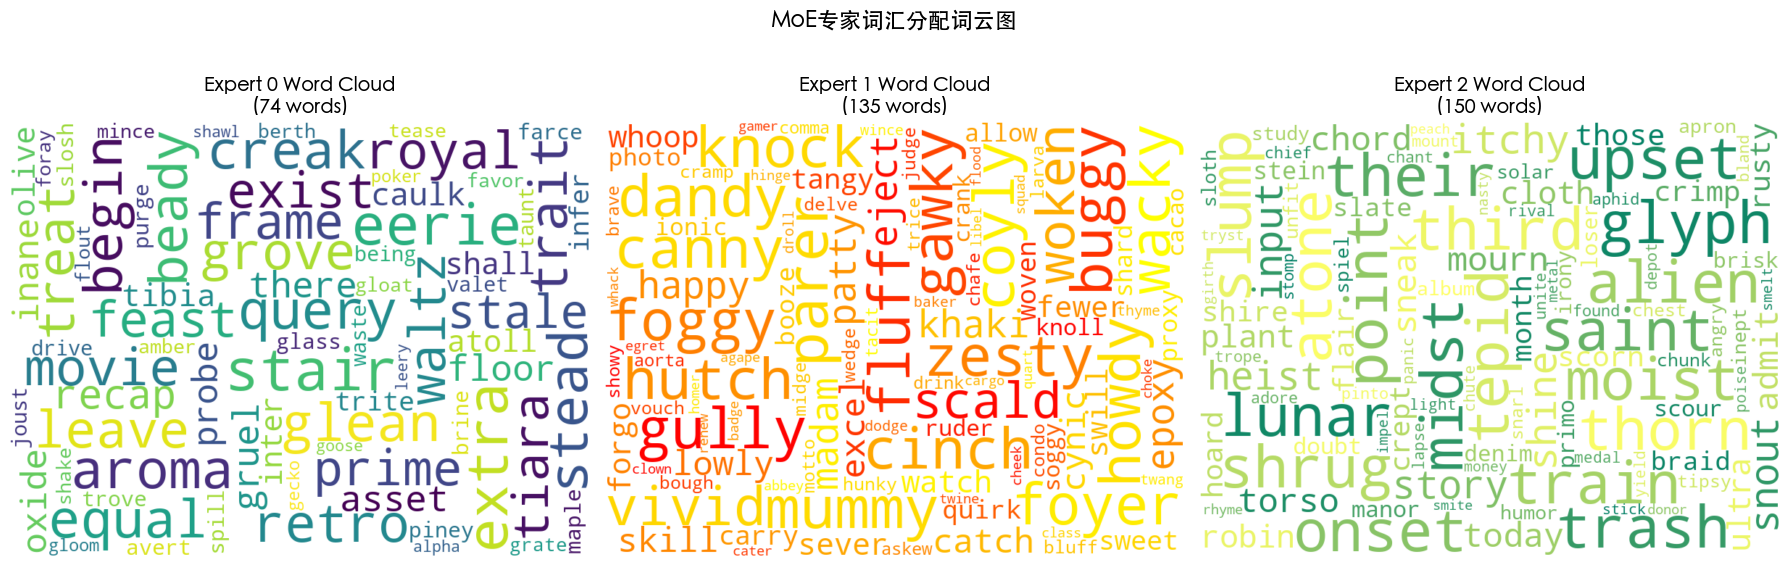


✓ 词云图已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/expert_wordclouds.png


In [28]:
# ==================== 10.3 专家词云可视化 ====================
# 安装词云库（如未安装）
try:
    from wordcloud import WordCloud
    print("wordcloud库已导入")
except ImportError:
    print("正在安装wordcloud...")
    import subprocess
    subprocess.check_call(["pip", "install", "wordcloud", "-q"])
    from wordcloud import WordCloud
    print("wordcloud库安装并导入成功")

print("\n" + "=" * 70)
print("10.3 生成专家词云图")
print("=" * 70)

# 为每个专家收集词汇及其权重
expert_word_weights = {}
for exp in range(NUM_EXPERTS):
    mask = df_expert_assignment["assigned_expert"] == exp
    words_exp = df_expert_assignment.loc[mask, "word"].tolist()
    weights_exp = df_expert_assignment.loc[mask, f"gate_weight_E{exp}"].tolist()
    
    # 创建词频字典（权重归一化后乘以100作为词频）
    word_freq = {w: max(10, int(wt * 100)) for w, wt in zip(words_exp, weights_exp)}
    expert_word_weights[exp] = word_freq
    print(f"Expert {exp}: {len(words_exp)} 词")

# 配置颜色方案
expert_colors = {
    0: "#1f77b4",  # 蓝色
    1: "#ff7f0e",  # 橙色
    2: "#2ca02c",  # 绿色
}

# 生成词云
fig, axes = plt.subplots(1, NUM_EXPERTS, figsize=(6 * NUM_EXPERTS, 6))
if NUM_EXPERTS == 1:
    axes = [axes]

for exp in range(NUM_EXPERTS):
    ax = axes[exp]
    word_freq = expert_word_weights[exp]
    
    if len(word_freq) == 0:
        ax.text(0.5, 0.5, f"Expert {exp}\n无分配词汇", ha='center', va='center', fontsize=16)
        ax.axis('off')
        continue
    
    # 生成词云
    wc = WordCloud(
        width=800,
        height=600,
        background_color='white',
        max_words=100,
        colormap='viridis' if exp == 0 else ('autumn' if exp == 1 else 'summer'),
        prefer_horizontal=0.7,
        min_font_size=10,
        max_font_size=80,
    ).generate_from_frequencies(word_freq)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"Expert {exp} Word Cloud\n({len(word_freq)} words)", fontsize=14, fontweight='bold')
    ax.axis('off')

plt.suptitle("MoE专家词汇分配词云图", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "expert_wordclouds.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ 词云图已保存至: {os.path.join(OUTPUT_DIR, 'expert_wordclouds.png')}")

In [29]:
# ==================== 10.4 专家词属性差异分析 ====================
print("\n" + "=" * 70)
print("10.4 专家词属性差异分析")
print("=" * 70)

# 合并专家分配与原始数据
df_analysis = df_expert_assignment.merge(df_raw, left_on="word", right_on=word_col, how="left")

# 定义分析的关键特征
KEY_FEATURES = [
    "Zipf-value",           # 词频（Zipf定律）
    "scrabble_score",       # Scrabble分数（字母难度）
    "letter_entropy",       # 字母熵
    "feedback_entropy",     # 反馈熵
    "num_rare_letters",     # 稀有字母数量
    "semantic_distance",    # 语义距离
    "position_rarity",      # 位置稀有度
    "keyboard_distance",    # 键盘距离
]

# 过滤存在的特征
available_features = [f for f in KEY_FEATURES if f in df_analysis.columns]
print(f"可用于分析的特征: {available_features}")

# 计算每个专家组的特征统计
print("\n" + "-" * 70)
print("各专家组的关键特征统计 (Mean ± Std)")
print("-" * 70)

stats_data = []
for feat in available_features:
    row = {"Feature": feat}
    for exp in range(NUM_EXPERTS):
        mask = df_analysis["assigned_expert"] == exp
        values = df_analysis.loc[mask, feat].dropna()
        if len(values) > 0:
            mean_val = values.mean()
            std_val = values.std()
            row[f"E{exp}_mean"] = mean_val
            row[f"E{exp}_std"] = std_val
            row[f"E{exp}_str"] = f"{mean_val:.3f}±{std_val:.3f}"
        else:
            row[f"E{exp}_mean"] = np.nan
            row[f"E{exp}_std"] = np.nan
            row[f"E{exp}_str"] = "N/A"
    stats_data.append(row)

df_stats = pd.DataFrame(stats_data)

# 打印统计表
print(f"\n{'Feature':<22}", end="")
for exp in range(NUM_EXPERTS):
    print(f"  Expert {exp:^15}", end="")
print()
print("-" * 70)

for _, row in df_stats.iterrows():
    print(f"{row['Feature']:<22}", end="")
    for exp in range(NUM_EXPERTS):
        print(f"  {row[f'E{exp}_str']:^15}", end="")
    print()

# 保存统计结果
stats_path = os.path.join(OUTPUT_DIR, "expert_feature_statistics.csv")
df_stats.to_csv(stats_path, index=False)
print(f"\n✓ 统计结果已保存至: {stats_path}")


10.4 专家词属性差异分析
可用于分析的特征: ['Zipf-value', 'scrabble_score', 'letter_entropy', 'feedback_entropy', 'num_rare_letters', 'semantic_distance', 'position_rarity', 'keyboard_distance']

----------------------------------------------------------------------
各专家组的关键特征统计 (Mean ± Std)
----------------------------------------------------------------------

Feature                 Expert        0         Expert        1         Expert        2       
----------------------------------------------------------------------
Zipf-value                3.560±0.968      3.407±0.860      3.754±0.964  
scrabble_score            8.405±2.729     10.630±3.063      8.260±2.045  
letter_entropy            2.187±0.202      2.092±0.238      2.306±0.079  
feedback_entropy          4.647±0.386      4.111±0.566      4.755±0.448  
num_rare_letters          0.284±0.454      0.363±0.541      0.073±0.262  
semantic_distance        -0.013±0.073      0.005±0.061     -0.035±0.070  
position_rarity          21.498±14.303    2


10.5 专家属性差异可视化 - 箱线图


/var/folders/0m/2sbyxxc10czg8dp3clzyzxym0000gn/T/ipykernel_71544/681243752.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_expert, patch_artist=True, labels=[f"E{e}" for e in range(NUM_EXPERTS)])
/var/folders/0m/2sbyxxc10czg8dp3clzyzxym0000gn/T/ipykernel_71544/681243752.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_expert, patch_artist=True, labels=[f"E{e}" for e in range(NUM_EXPERTS)])
/var/folders/0m/2sbyxxc10czg8dp3clzyzxym0000gn/T/ipykernel_71544/681243752.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_expert, patch_artist=Tr

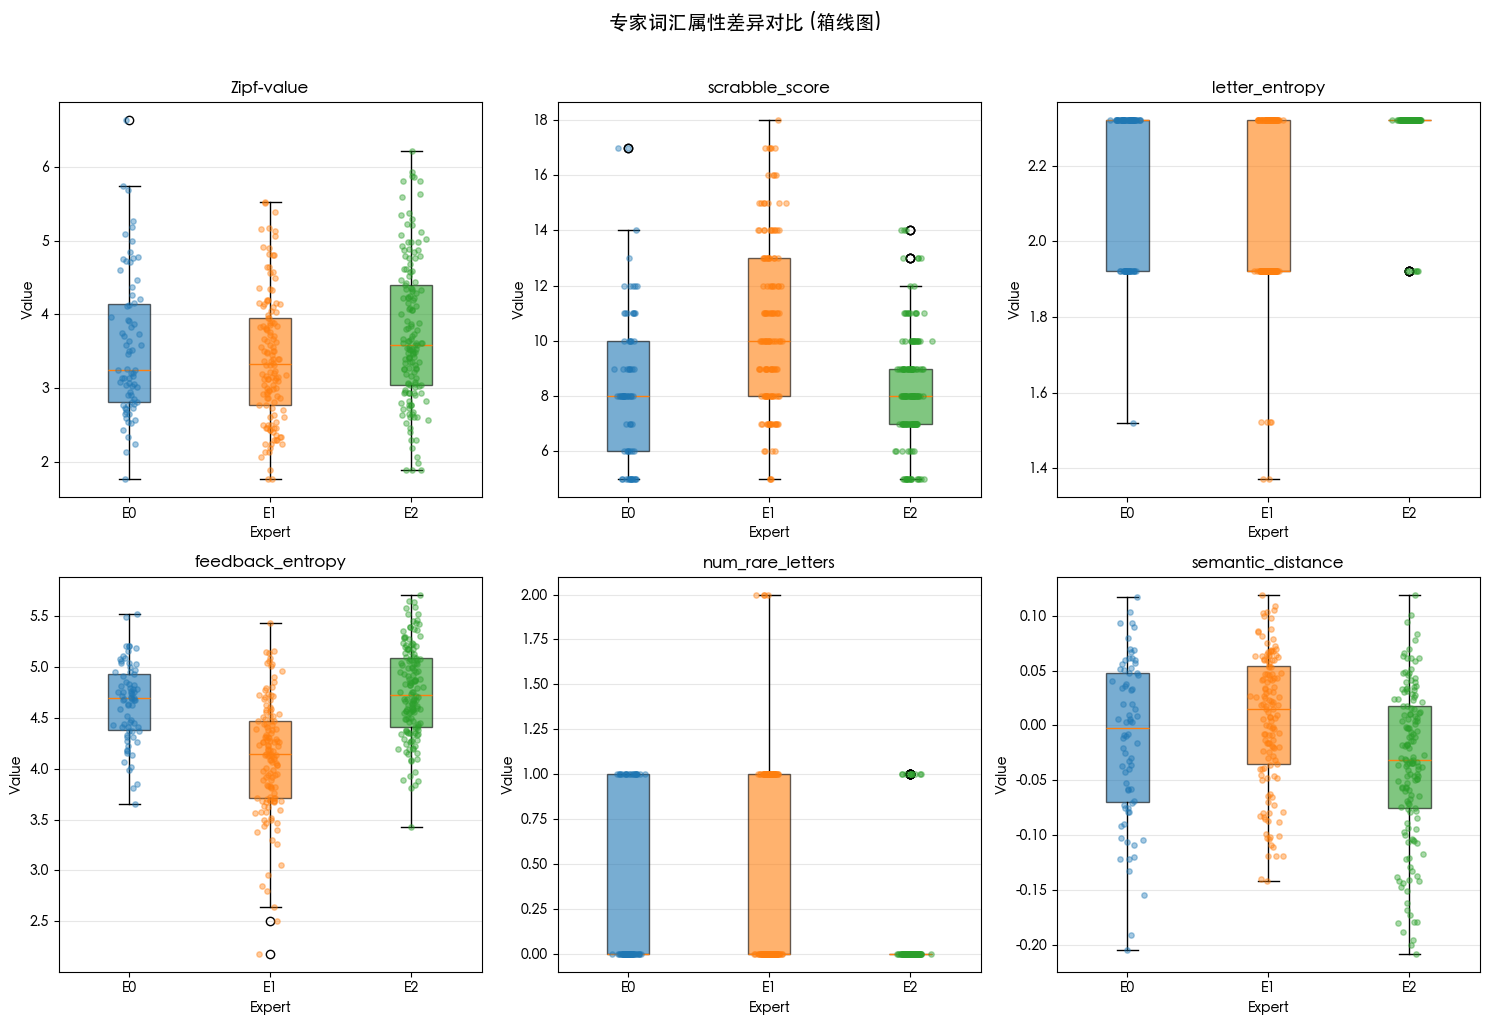


✓ 箱线图已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/expert_feature_boxplots.png


In [30]:
# ==================== 10.5 专家属性差异箱线图 ====================
print("\n" + "=" * 70)
print("10.5 专家属性差异可视化 - 箱线图")
print("=" * 70)

# 选择前6个最重要的特征进行可视化
plot_features = available_features[:6]
n_features = len(plot_features)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, feat in enumerate(plot_features):
    ax = axes[idx]
    
    # 准备箱线图数据
    data_by_expert = []
    for exp in range(NUM_EXPERTS):
        mask = df_analysis["assigned_expert"] == exp
        values = df_analysis.loc[mask, feat].dropna().values
        data_by_expert.append(values)
    
    # 绘制箱线图
    bp = ax.boxplot(data_by_expert, patch_artist=True, labels=[f"E{e}" for e in range(NUM_EXPERTS)])
    
    # 设置颜色
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    # 添加散点
    for exp in range(NUM_EXPERTS):
        x = np.random.normal(exp + 1, 0.04, size=len(data_by_expert[exp]))
        ax.scatter(x, data_by_expert[exp], alpha=0.4, s=15, color=colors[exp], zorder=3)
    
    ax.set_title(feat, fontsize=12, fontweight='bold')
    ax.set_xlabel("Expert")
    ax.set_ylabel("Value")
    ax.grid(axis='y', alpha=0.3)

# 隐藏多余的子图
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle("专家词汇属性差异对比 (箱线图)", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "expert_feature_boxplots.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ 箱线图已保存至: {os.path.join(OUTPUT_DIR, 'expert_feature_boxplots.png')}")

In [31]:
# ==================== 10.6 统计显著性检验 ====================
from scipy import stats

print("\n" + "=" * 70)
print("10.6 专家差异统计显著性检验 (Kruskal-Wallis H检验)")
print("=" * 70)

print("\nKruskal-Wallis H检验用于比较3个专家组在各特征上是否存在显著差异")
print("H0: 各组分布相同; H1: 至少有一组分布不同")
print("显著性水平 α = 0.05\n")

test_results = []
print(f"{'Feature':<25} {'H-statistic':>12} {'p-value':>12} {'Significant':>12}")
print("-" * 65)

for feat in available_features:
    groups = []
    for exp in range(NUM_EXPERTS):
        mask = df_analysis["assigned_expert"] == exp
        values = df_analysis.loc[mask, feat].dropna().values
        if len(values) > 0:
            groups.append(values)
    
    if len(groups) >= 2 and all(len(g) >= 2 for g in groups):
        try:
            h_stat, p_val = stats.kruskal(*groups)
            significant = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
            print(f"{feat:<25} {h_stat:>12.4f} {p_val:>12.6f} {significant:>12}")
            test_results.append({
                "Feature": feat,
                "H_statistic": h_stat,
                "p_value": p_val,
                "significant_0.05": p_val < 0.05,
                "significant_0.01": p_val < 0.01,
            })
        except Exception as e:
            print(f"{feat:<25} {'Error':>12} {str(e)[:20]:>12}")
    else:
        print(f"{feat:<25} {'Insufficient data':>25}")

print("\n显著性标记: *** p<0.001, ** p<0.01, * p<0.05")

# 保存检验结果
if test_results:
    df_tests = pd.DataFrame(test_results)
    test_path = os.path.join(OUTPUT_DIR, "expert_statistical_tests.csv")
    df_tests.to_csv(test_path, index=False)
    print(f"\n✓ 检验结果已保存至: {test_path}")
    
    # 统计显著差异的特征数量
    sig_count = df_tests["significant_0.05"].sum()
    print(f"\n共有 {sig_count}/{len(test_results)} 个特征在专家间存在显著差异 (p < 0.05)")


10.6 专家差异统计显著性检验 (Kruskal-Wallis H检验)

Kruskal-Wallis H检验用于比较3个专家组在各特征上是否存在显著差异
H0: 各组分布相同; H1: 至少有一组分布不同
显著性水平 α = 0.05

Feature                    H-statistic      p-value  Significant
-----------------------------------------------------------------
Zipf-value                      8.9622     0.011321            *
scrabble_score                 49.3884     0.000000          ***
letter_entropy                 83.9271     0.000000          ***
feedback_entropy               96.0113     0.000000          ***
num_rare_letters               31.5129     0.000000          ***
semantic_distance              22.1508     0.000015          ***
position_rarity                28.2230     0.000001          ***
keyboard_distance               3.5484     0.169618             

显著性标记: *** p<0.001, ** p<0.01, * p<0.05

✓ 检验结果已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/expert_statistical_tests.csv

共有 7/8 个特征在专家间存在显著差异 (p < 0.05)



10.7 专家预测分布特征分析

各专家负责词汇的预测分布特征:
----------------------------------------------------------------------

【Expert 0】(74 词)
  平均预测分布: ['0.007', '0.068', '0.212', '0.328', '0.241', '0.119', '0.024']
  峰值尝试次数: 4_tries (概率=0.328)
  期望尝试次数: 4.18
  代表性词汇: stair(1.00), extra(0.96), eerie(0.93), stead(0.87), aroma(0.86)

【Expert 1】(135 词)
  平均预测分布: ['0.004', '0.039', '0.165', '0.305', '0.274', '0.165', '0.048']
  峰值尝试次数: 4_tries (概率=0.305)
  期望尝试次数: 4.49
  代表性词汇: parer(0.99), mummy(0.98), dandy(0.97), gawky(0.96), buggy(0.94)

【Expert 2】(150 词)
  平均预测分布: ['0.011', '0.091', '0.274', '0.326', '0.199', '0.083', '0.016']
  峰值尝试次数: 4_tries (概率=0.326)
  期望尝试次数: 3.92
  代表性词汇: third(0.99), onset(0.99), saint(0.99), midst(0.99), trash(0.99)


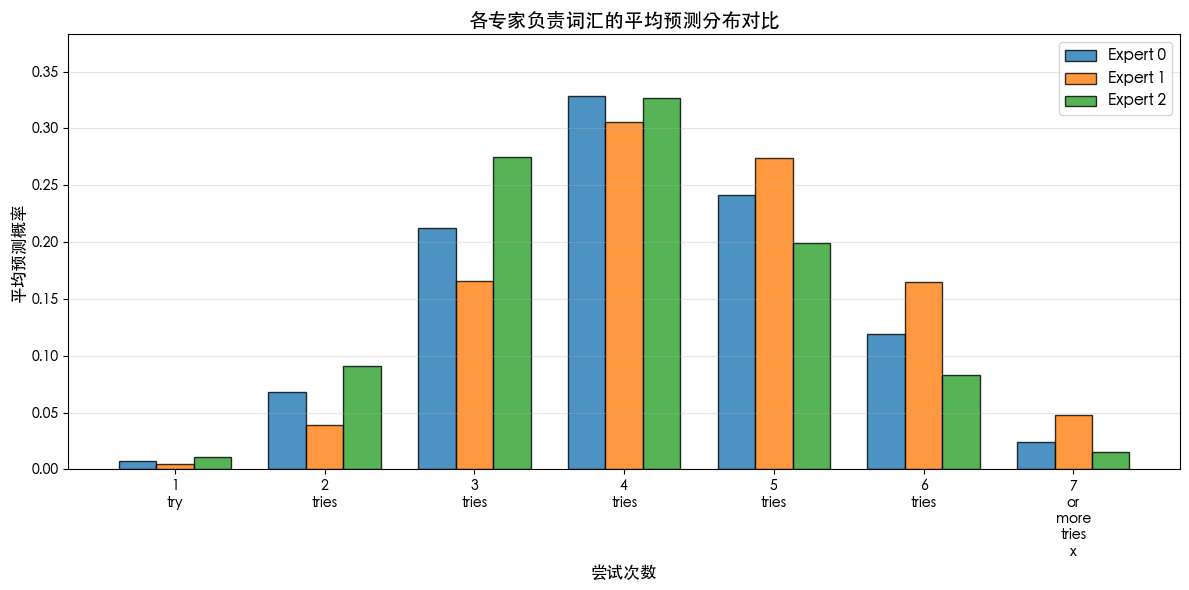


✓ 预测分布对比图已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/expert_prediction_distribution.png


In [32]:
# ==================== 10.7 专家预测分布特征分析 ====================
print("\n" + "=" * 70)
print("10.7 专家预测分布特征分析")
print("=" * 70)

# 分析每个专家负责词汇的预测分布特征
print("\n各专家负责词汇的预测分布特征:")
print("-" * 70)

pred_cols = [f"pred_{c}" for c in DIST_COLS]

for exp in range(NUM_EXPERTS):
    mask = df_analysis["assigned_expert"] == exp
    df_exp = df_analysis.loc[mask]
    n_words = len(df_exp)
    
    print(f"\n【Expert {exp}】({n_words} 词)")
    
    # 计算该专家负责词汇的平均预测分布
    avg_pred = df_exp[pred_cols].mean().values
    
    # 找到概率最高的尝试次数
    peak_idx = avg_pred.argmax()
    peak_tries = DIST_COLS[peak_idx].replace("_", " ").replace("tries", "").replace("try", "").strip()
    
    print(f"  平均预测分布: {[f'{p:.3f}' for p in avg_pred]}")
    print(f"  峰值尝试次数: {DIST_COLS[peak_idx]} (概率={avg_pred[peak_idx]:.3f})")
    
    # 计算期望尝试次数
    try_values = np.array([1, 2, 3, 4, 5, 6, 7])
    expected_tries = (avg_pred * try_values).sum()
    print(f"  期望尝试次数: {expected_tries:.2f}")
    
    # 列出代表性词汇（权重最高的5个词）
    top_words = df_exp.nlargest(5, f"gate_weight_E{exp}")[["word", f"gate_weight_E{exp}"]]
    words_str = ", ".join([f"{row['word']}({row[f'gate_weight_E{exp}']:.2f})" for _, row in top_words.iterrows()])
    print(f"  代表性词汇: {words_str}")

# 绘制专家预测分布对比图
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(DIST_COLS))
width = 0.25
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for exp in range(NUM_EXPERTS):
    mask = df_analysis["assigned_expert"] == exp
    avg_pred = df_analysis.loc[mask, pred_cols].mean().values
    offset = (exp - 1) * width
    bars = ax.bar(x + offset, avg_pred, width, label=f"Expert {exp}", color=colors[exp], alpha=0.8, edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels([c.replace("_", "\n") for c in DIST_COLS], fontsize=10)
ax.set_xlabel("尝试次数", fontsize=12, fontweight='bold')
ax.set_ylabel("平均预测概率", fontsize=12, fontweight='bold')
ax.set_title("各专家负责词汇的平均预测分布对比", fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(0.35, df_analysis[pred_cols].mean().max() * 1.2))

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "expert_prediction_distribution.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ 预测分布对比图已保存至: {os.path.join(OUTPUT_DIR, 'expert_prediction_distribution.png')}")

In [33]:
# ==================== 10.8 生成专家分析报告 ====================
print("\n" + "=" * 70)
print("10.8 生成专家分析报告")
print("=" * 70)

# 生成Markdown报告
report_content = f"""# MoE专家分配分析报告

**生成时间**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

## 1. 模型概述

本报告分析了MoE (Mixture of Experts) 模型在Wordle词汇预测任务中的专家分配情况。

### 模型配置
- **专家数量**: {NUM_EXPERTS}
- **隐藏层大小**: {HIDDEN_SIZE}
- **Top-K路由**: {TOP_K}
- **输入特征数**: {len(FEATURE_COLS)}
- **输出维度**: {len(DIST_COLS)} (尝试次数分布)

### 数据集
- **总词汇数**: {len(df_expert_assignment)}
- **训练集大小**: {len(X_train)}
- **验证集大小**: {len(X_val)}
- **测试集大小**: {len(X_test)}

## 2. 专家分配统计

| 专家 | 分配词数 | 占比 |
|------|----------|------|
"""

for exp in range(NUM_EXPERTS):
    count = (df_expert_assignment["assigned_expert"] == exp).sum()
    pct = count / len(df_expert_assignment) * 100
    report_content += f"| Expert {exp} | {count} | {pct:.1f}% |\n"

report_content += f"""
## 3. 专家特征差异分析

### 3.1 关键特征统计

| 特征 |"""

for exp in range(NUM_EXPERTS):
    report_content += f" Expert {exp} |"
report_content += "\n|------|"
for _ in range(NUM_EXPERTS):
    report_content += "----------|"
report_content += "\n"

for _, row in df_stats.iterrows():
    report_content += f"| {row['Feature']} |"
    for exp in range(NUM_EXPERTS):
        report_content += f" {row[f'E{exp}_str']} |"
    report_content += "\n"

report_content += """
### 3.2 统计显著性检验结果

使用Kruskal-Wallis H检验评估专家组间差异的统计显著性：

| 特征 | H统计量 | p值 | 显著性 |
|------|---------|-----|--------|
"""

if test_results:
    for r in test_results:
        sig = "***" if r['p_value'] < 0.001 else ("**" if r['p_value'] < 0.01 else ("*" if r['p_value'] < 0.05 else "-"))
        report_content += f"| {r['Feature']} | {r['H_statistic']:.4f} | {r['p_value']:.6f} | {sig} |\n"

report_content += """
*显著性标记: *** p<0.001, ** p<0.01, * p<0.05*

## 4. 专家画像总结

基于上述分析，各专家的"专长"可概括如下：

"""

# 为每个专家生成画像
for exp in range(NUM_EXPERTS):
    mask = df_analysis["assigned_expert"] == exp
    df_exp = df_analysis.loc[mask]
    n_words = len(df_exp)
    
    # 计算关键特征均值
    zipf_mean = df_exp["Zipf-value"].mean() if "Zipf-value" in df_exp.columns else None
    scrabble_mean = df_exp["scrabble_score"].mean() if "scrabble_score" in df_exp.columns else None
    
    # 计算期望尝试次数
    avg_pred = df_exp[pred_cols].mean().values
    try_values = np.array([1, 2, 3, 4, 5, 6, 7])
    expected_tries = (avg_pred * try_values).sum()
    
    # 获取代表性词汇
    top_words = df_exp.nlargest(5, f"gate_weight_E{exp}")["word"].tolist()
    
    report_content += f"""### Expert {exp} ({n_words} 词, {n_words/len(df_expert_assignment)*100:.1f}%)

- **期望尝试次数**: {expected_tries:.2f}
"""
    if zipf_mean is not None:
        report_content += f"- **平均词频(Zipf)**: {zipf_mean:.2f}\n"
    if scrabble_mean is not None:
        report_content += f"- **平均Scrabble分数**: {scrabble_mean:.2f}\n"
    report_content += f"- **代表性词汇**: {', '.join(top_words)}\n\n"

report_content += f"""## 5. 结论

MoE模型通过门控机制将{len(df_expert_assignment)}个词汇分配给{NUM_EXPERTS}个专家，
各专家在词频、难度、语义距离等特征上呈现不同的偏好，表明模型成功学习到了词汇的差异化特征。

## 6. 输出文件

- `moe_model_state_dict.pt`: 模型权重
- `feature_scaler.pkl`: 特征标准化器
- `expert_assignment_all_words.csv`: 专家分配结果
- `expert_wordclouds.png`: 专家词云图
- `expert_feature_boxplots.png`: 特征差异箱线图
- `expert_prediction_distribution.png`: 预测分布对比图
- `expert_feature_statistics.csv`: 特征统计表
- `expert_statistical_tests.csv`: 统计检验结果

---
*本报告由MoE分析模块自动生成*
"""

# 保存报告
report_path = os.path.join(OUTPUT_DIR, "expert_analysis_report.md")
with open(report_path, "w", encoding="utf-8") as f:
    f.write(report_content)

print(f"✓ 分析报告已保存至: {report_path}")
print("\n" + "=" * 70)
print("专家分配分析完成！")
print("=" * 70)
print(f"\n所有输出文件位于: {OUTPUT_DIR}")

# 显示报告预览
print("\n" + "-" * 70)
print("报告预览 (前50行):")
print("-" * 70)
for line in report_content.split("\n")[:50]:
    print(line)


10.8 生成专家分析报告
✓ 分析报告已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/expert_analysis_report.md

专家分配分析完成！

所有输出文件位于: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output

----------------------------------------------------------------------
报告预览 (前50行):
----------------------------------------------------------------------
# MoE专家分配分析报告

**生成时间**: 2025-12-20 22:16:20

## 1. 模型概述

本报告分析了MoE (Mixture of Experts) 模型在Wordle词汇预测任务中的专家分配情况。

### 模型配置
- **专家数量**: 3
- **隐藏层大小**: 64
- **Top-K路由**: 2
- **输入特征数**: 55
- **输出维度**: 7 (尝试次数分布)

### 数据集
- **总词汇数**: 359
- **训练集大小**: 250
- **验证集大小**: 54
- **测试集大小**: 54

## 2. 专家分配统计

| 专家 | 分配词数 | 占比 |
|------|----------|------|
| Expert 0 | 74 | 20.6% |
| Expert 1 | 135 | 37.6% |
| Expert 2 | 150 | 41.8% |

## 3. 专家特征差异分析

### 3.1 关键特征统计

| 特征 | Expert 0 | Expert 1 | Expert 2 |
|------|----------|----------|----------|
| Zipf-value | 3.560±0.968 | 3.407±0.860 | 3.754±0.964 |
| scrabble_score | 8.405±2.729 | 10.630±3.063 | 8.260±2.045 |


## 11. 专家分配难度验证与词属性聚类分析

本节深入分析MoE专家分配是否真正区分了词汇的"属性难度"，并通过聚类方法探究影响Wordle单词难度的关键因素。

### 分析目标

1. **验证专家分配的难度区分性**：结合真实1-7次分布和autoencoder_value，检验不同专家负责的词汇在难度上是否存在显著差异
2. **eerie难度定位**：判断"eerie"是难词还是简单词，在全体分布中的定位
3. **词属性聚类分析**：对词汇属性进行聚类，探究影响难度的关键因素

### 难度指标定义

- **期望尝试次数** $E[T] = \sum_{i=1}^{7} i \cdot P(T=i)$：越高表示越难
- **高尝试概率** $P(T \geq 6)$：衡量"尾部难度"
- **autoencoder_value**：综合难度表征（来自AutoEncoder降维）

In [34]:
# ==================== 11.1 数据整合与难度指标构建 ====================
print("=" * 70)
print("11.1 数据整合与难度指标构建")
print("=" * 70)

# 加载原始数据（包含autoencoder_value和所有词属性）
df_full = pd.read_csv(DATA_PATH)
print(f"原始数据: {len(df_full)} 条记录")

# 加载专家分配结果
expert_assignment_path = os.path.join(OUTPUT_DIR, "expert_assignment_all_words.csv")
df_expert = pd.read_csv(expert_assignment_path)
print(f"专家分配数据: {len(df_expert)} 条记录")

# 合并数据
df_merged = df_expert.merge(df_full, on="word", how="left")
print(f"合并后数据: {len(df_merged)} 条记录")

# 检查autoencoder_value是否存在
if "autoencoder_value" in df_merged.columns:
    print(f"✓ autoencoder_value 列存在")
    print(f"  范围: [{df_merged['autoencoder_value'].min():.4f}, {df_merged['autoencoder_value'].max():.4f}]")
else:
    print("✗ autoencoder_value 列不存在，将跳过相关分析")

# 定义真实分布列
TRUE_DIST_COLS = ["1_try", "2_tries", "3_tries", "4_tries", "5_tries", "6_tries", "7_or_more_tries_x"]

# 检查真实分布列
missing_cols = [c for c in TRUE_DIST_COLS if c not in df_merged.columns]
if missing_cols:
    print(f"✗ 缺失分布列: {missing_cols}")
else:
    print(f"✓ 所有真实分布列存在")

# 构建难度指标
print("\n构建难度指标...")

# 获取真实分布矩阵
P_true_matrix = df_merged[TRUE_DIST_COLS].values
# 归一化（确保和为1）
row_sums = P_true_matrix.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # 避免除零
P_true_normalized = P_true_matrix / row_sums

# 1. 期望尝试次数 E[T]
try_values = np.array([1, 2, 3, 4, 5, 6, 7])
df_merged["expected_tries"] = (P_true_normalized * try_values).sum(axis=1)

# 2. 高尝试概率 P(T >= 6)
df_merged["high_try_prob"] = P_true_normalized[:, 5] + P_true_normalized[:, 6]  # 6次 + 7次及以上

# 3. 尾部质量 (7次及以上的概率)
df_merged["tail_prob"] = P_true_normalized[:, 6]

# 4. 低尝试概率 P(T <= 3)
df_merged["low_try_prob"] = P_true_normalized[:, 0] + P_true_normalized[:, 1] + P_true_normalized[:, 2]

# 5. 难度综合评分 (标准化后的加权组合)
from sklearn.preprocessing import MinMaxScaler
difficulty_features = df_merged[["expected_tries", "high_try_prob", "tail_prob"]].copy()
scaler_diff = MinMaxScaler()
difficulty_scaled = scaler_diff.fit_transform(difficulty_features)
df_merged["difficulty_score"] = difficulty_scaled.mean(axis=1)

print(f"\n难度指标统计:")
print(f"  期望尝试次数 E[T]: mean={df_merged['expected_tries'].mean():.3f}, std={df_merged['expected_tries'].std():.3f}")
print(f"  高尝试概率 P(T>=6): mean={df_merged['high_try_prob'].mean():.3f}, std={df_merged['high_try_prob'].std():.3f}")
print(f"  尾部概率 P(T=7+):   mean={df_merged['tail_prob'].mean():.3f}, std={df_merged['tail_prob'].std():.3f}")
print(f"  难度综合评分:       mean={df_merged['difficulty_score'].mean():.3f}, std={df_merged['difficulty_score'].std():.3f}")

# 排除eerie用于主分析
df_analysis = df_merged[df_merged["word"].str.lower() != "eerie"].copy()
print(f"\n排除eerie后的分析数据: {len(df_analysis)} 条记录")

# 保存eerie数据用于后续分析
df_eerie = df_merged[df_merged["word"].str.lower() == "eerie"].copy()
if len(df_eerie) > 0:
    print(f"eerie数据: {len(df_eerie)} 条记录")
else:
    print("未在合并数据中找到eerie，将单独加载")

11.1 数据整合与难度指标构建
原始数据: 359 条记录
专家分配数据: 359 条记录
合并后数据: 359 条记录
✓ autoencoder_value 列存在
  范围: [-1.6745, 2.2557]
✓ 所有真实分布列存在

构建难度指标...

难度指标统计:
  期望尝试次数 E[T]: mean=4.192, std=0.395
  高尝试概率 P(T>=6): mean=0.143, std=0.094
  尾部概率 P(T=7+):   mean=0.028, std=0.041
  难度综合评分:       mean=0.204, std=0.114

排除eerie后的分析数据: 358 条记录
eerie数据: 1 条记录


In [35]:
# ==================== 11.2 专家分配难度区分性验证 ====================
print("\n" + "=" * 70)
print("11.2 专家分配难度区分性验证")
print("=" * 70)

# 定义分析的难度指标
DIFFICULTY_METRICS = ["expected_tries", "high_try_prob", "tail_prob", "difficulty_score"]
if "autoencoder_value" in df_analysis.columns:
    DIFFICULTY_METRICS.append("autoencoder_value")

print(f"\n分析的难度指标: {DIFFICULTY_METRICS}")

# 按专家分组统计难度指标
print("\n" + "-" * 70)
print("各专家组的难度指标统计 (Mean ± Std)")
print("-" * 70)

expert_difficulty_stats = []
for exp in range(NUM_EXPERTS):
    mask = df_analysis["assigned_expert"] == exp
    n_words = mask.sum()
    row = {"Expert": f"E{exp}", "词数": n_words}
    
    for metric in DIFFICULTY_METRICS:
        values = df_analysis.loc[mask, metric].dropna()
        if len(values) > 0:
            row[f"{metric}_mean"] = values.mean()
            row[f"{metric}_std"] = values.std()
            row[f"{metric}_str"] = f"{values.mean():.4f}±{values.std():.4f}"
        else:
            row[f"{metric}_str"] = "N/A"
    
    expert_difficulty_stats.append(row)

df_exp_difficulty = pd.DataFrame(expert_difficulty_stats)

# 打印统计表
header = f"{'Expert':<8} {'词数':<6}"
for m in DIFFICULTY_METRICS:
    header += f" {m:<20}"
print(header)
print("-" * len(header))

for _, row in df_exp_difficulty.iterrows():
    line = f"{row['Expert']:<8} {row['词数']:<6}"
    for m in DIFFICULTY_METRICS:
        line += f" {row[f'{m}_str']:<20}"
    print(line)

# Kruskal-Wallis检验
print("\n" + "-" * 70)
print("Kruskal-Wallis H检验 (专家组间难度差异)")
print("-" * 70)

from scipy import stats

kw_results = []
print(f"\n{'指标':<25} {'H统计量':>12} {'p值':>15} {'显著性':>10}")
print("-" * 65)

for metric in DIFFICULTY_METRICS:
    groups = []
    for exp in range(NUM_EXPERTS):
        mask = df_analysis["assigned_expert"] == exp
        values = df_analysis.loc[mask, metric].dropna().values
        if len(values) > 0:
            groups.append(values)
    
    if len(groups) >= 2 and all(len(g) >= 2 for g in groups):
        h_stat, p_val = stats.kruskal(*groups)
        sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
        print(f"{metric:<25} {h_stat:>12.4f} {p_val:>15.6f} {sig:>10}")
        kw_results.append({
            "Metric": metric,
            "H_statistic": h_stat,
            "p_value": p_val,
            "significant": p_val < 0.05
        })

print("\n显著性标记: *** p<0.001, ** p<0.01, * p<0.05")


11.2 专家分配难度区分性验证

分析的难度指标: ['expected_tries', 'high_try_prob', 'tail_prob', 'difficulty_score', 'autoencoder_value']

----------------------------------------------------------------------
各专家组的难度指标统计 (Mean ± Std)
----------------------------------------------------------------------
Expert   词数     expected_tries       high_try_prob        tail_prob            difficulty_score     autoencoder_value   
------------------------------------------------------------------------------------------------------------------------
E0       73     4.1984±0.3026        0.1430±0.0666        0.0248±0.0251        0.2021±0.0798        -0.6007±0.3376      
E1       135    4.4742±0.3645        0.2014±0.1106        0.0454±0.0583        0.2771±0.1311        -0.2797±0.4571      
E2       150    3.9351±0.2678        0.0909±0.0467        0.0137±0.0148        0.1381±0.0601        -0.8850±0.2907      

----------------------------------------------------------------------
Kruskal-Wallis H检验 (专家组间难度差异)
-------


11.2.1 专家难度差异可视化


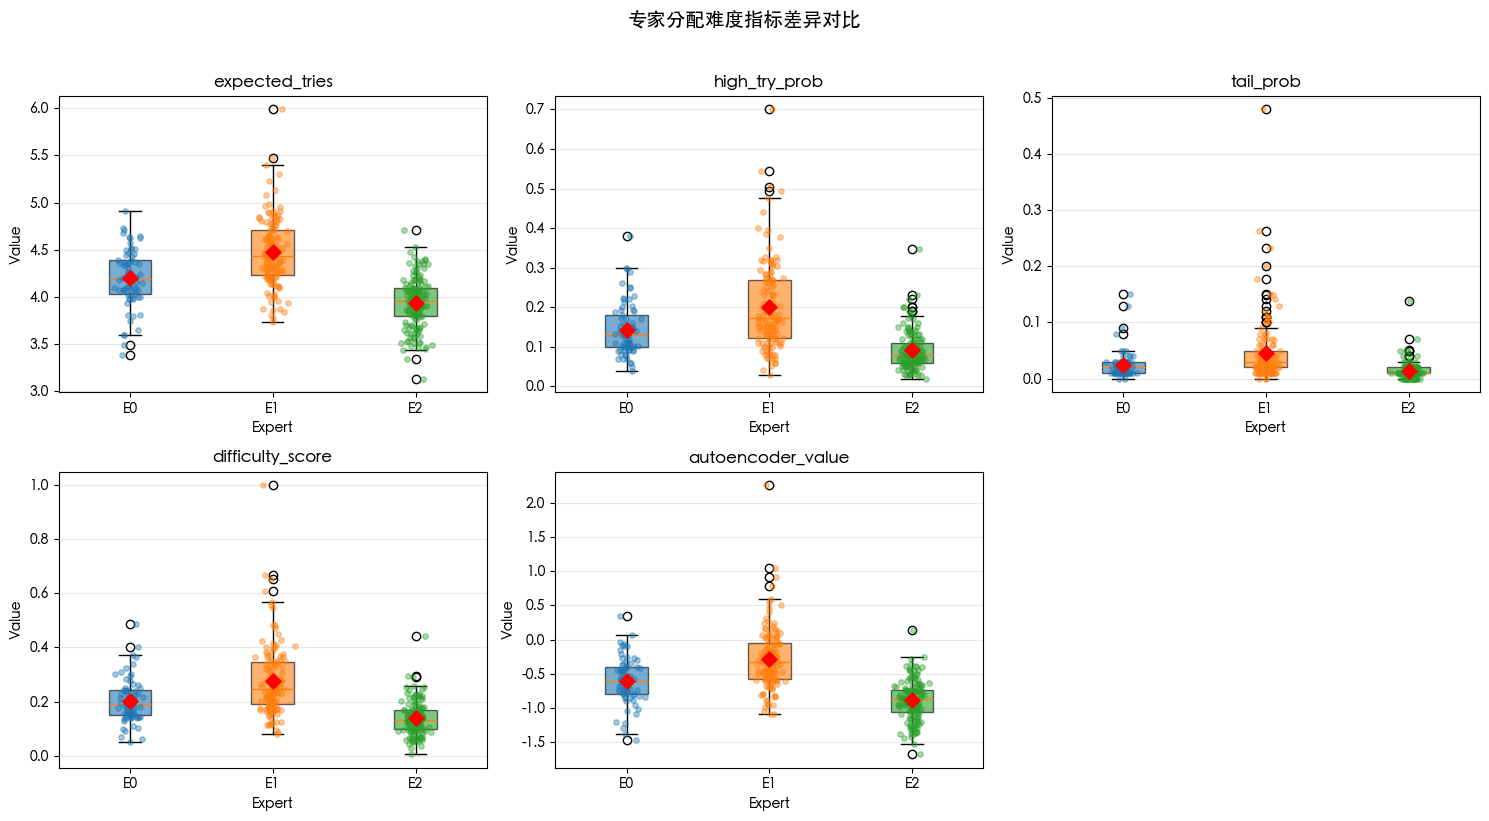

✓ 图表已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/expert_difficulty_comparison.png


In [36]:
# ==================== 11.2.1 专家难度差异可视化 ====================
print("\n" + "=" * 70)
print("11.2.1 专家难度差异可视化")
print("=" * 70)

# 绘制难度指标箱线图
n_metrics = len(DIFFICULTY_METRICS)
n_cols = min(3, n_metrics)
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = np.atleast_2d(axes).flatten()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, metric in enumerate(DIFFICULTY_METRICS):
    ax = axes[idx]
    
    # 准备数据
    data_by_expert = []
    for exp in range(NUM_EXPERTS):
        mask = df_analysis["assigned_expert"] == exp
        values = df_analysis.loc[mask, metric].dropna().values
        data_by_expert.append(values)
    
    # 绘制箱线图
    bp = ax.boxplot(data_by_expert, patch_artist=True, 
                    tick_labels=[f"E{e}" for e in range(NUM_EXPERTS)])
    
    # 设置颜色
    for i, (patch, color) in enumerate(zip(bp['boxes'], colors[:NUM_EXPERTS])):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    # 添加散点
    for exp in range(NUM_EXPERTS):
        x = np.random.normal(exp + 1, 0.04, size=len(data_by_expert[exp]))
        ax.scatter(x, data_by_expert[exp], alpha=0.4, s=15, color=colors[exp], zorder=3)
    
    # 添加均值标记
    means = [np.mean(d) for d in data_by_expert]
    ax.scatter(range(1, NUM_EXPERTS + 1), means, marker='D', s=60, 
              color='red', zorder=5, label='Mean')
    
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_xlabel("Expert")
    ax.set_ylabel("Value")
    ax.grid(axis='y', alpha=0.3)

# 隐藏多余子图
for idx in range(n_metrics, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle("专家分配难度指标差异对比", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "expert_difficulty_comparison.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ 图表已保存至: {os.path.join(OUTPUT_DIR, 'expert_difficulty_comparison.png')}")


11.2.2 专家真实分布形状对比


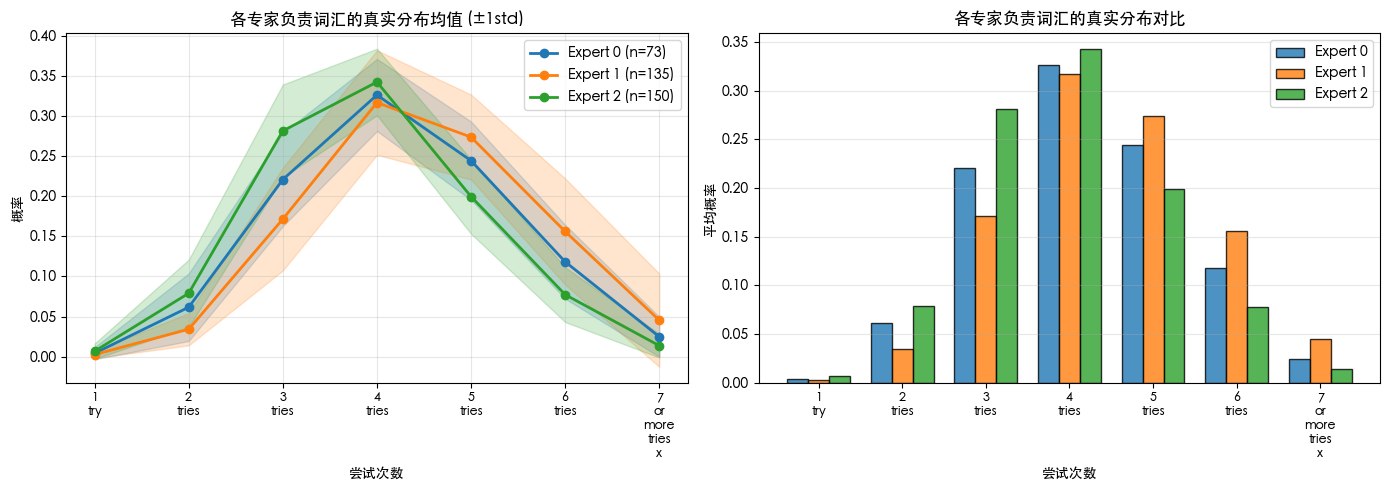


专家间真实分布的JS距离:
----------------------------------------
  Expert 0 vs Expert 1: JS距离 = 0.0832
  Expert 0 vs Expert 2: JS距离 = 0.0821
  Expert 1 vs Expert 2: JS距离 = 0.1620

各专家负责词汇的期望尝试次数:
----------------------------------------
  Expert 0: E[T] = 4.198
  Expert 1: E[T] = 4.474
  Expert 2: E[T] = 3.935


In [37]:
# ==================== 11.2.2 专家真实分布形状对比 ====================
print("\n" + "=" * 70)
print("11.2.2 专家真实分布形状对比")
print("=" * 70)

# 计算每个专家负责词汇的真实分布均值
expert_true_dist = {}
for exp in range(NUM_EXPERTS):
    mask = df_analysis["assigned_expert"] == exp
    true_dist = df_analysis.loc[mask, TRUE_DIST_COLS].values
    # 归一化
    row_sums = true_dist.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    true_dist_norm = true_dist / row_sums
    expert_true_dist[exp] = {
        "mean": true_dist_norm.mean(axis=0),
        "std": true_dist_norm.std(axis=0),
        "n": mask.sum()
    }

# 绘制真实分布对比图
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 图1: 各专家真实分布均值曲线
ax1 = axes[0]
x = np.arange(len(TRUE_DIST_COLS))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for exp in range(NUM_EXPERTS):
    mean = expert_true_dist[exp]["mean"]
    std = expert_true_dist[exp]["std"]
    n = expert_true_dist[exp]["n"]
    
    ax1.plot(x, mean, marker='o', linewidth=2, label=f"Expert {exp} (n={n})", color=colors[exp])
    ax1.fill_between(x, mean - std, mean + std, alpha=0.2, color=colors[exp])

ax1.set_xticks(x)
ax1.set_xticklabels([c.replace("_", "\n") for c in TRUE_DIST_COLS], fontsize=9)
ax1.set_xlabel("尝试次数", fontweight='bold')
ax1.set_ylabel("概率", fontweight='bold')
ax1.set_title("各专家负责词汇的真实分布均值 (±1std)", fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 图2: 柱状图对比
ax2 = axes[1]
width = 0.25
for exp in range(NUM_EXPERTS):
    offset = (exp - 1) * width
    ax2.bar(x + offset, expert_true_dist[exp]["mean"], width, 
           label=f"Expert {exp}", color=colors[exp], alpha=0.8, edgecolor='black')

ax2.set_xticks(x)
ax2.set_xticklabels([c.replace("_", "\n") for c in TRUE_DIST_COLS], fontsize=9)
ax2.set_xlabel("尝试次数", fontweight='bold')
ax2.set_ylabel("平均概率", fontweight='bold')
ax2.set_title("各专家负责词汇的真实分布对比", fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "expert_true_distribution_comparison.png"), dpi=150, bbox_inches='tight')
plt.show()

# 计算专家间分布的JS距离
print("\n专家间真实分布的JS距离:")
print("-" * 40)
for i in range(NUM_EXPERTS):
    for j in range(i + 1, NUM_EXPERTS):
        js_dist = jensenshannon(expert_true_dist[i]["mean"], expert_true_dist[j]["mean"])
        print(f"  Expert {i} vs Expert {j}: JS距离 = {js_dist:.4f}")

# 计算期望尝试次数
print("\n各专家负责词汇的期望尝试次数:")
print("-" * 40)
try_values = np.array([1, 2, 3, 4, 5, 6, 7])
for exp in range(NUM_EXPERTS):
    mean_dist = expert_true_dist[exp]["mean"]
    exp_tries = (mean_dist * try_values).sum()
    print(f"  Expert {exp}: E[T] = {exp_tries:.3f}")


11.3 EERIE 难度定位分析

EERIE 基本信息

【注意】EERIE是测试样本，使用MoE模型预测分布进行分析

EERIE 预测分布 (Bootstrap平均):
  1_try: 0.0004
  2_tries: 0.0236
  3_tries: 0.1596
  4_tries: 0.3365
  5_tries: 0.3002
  6_tries: 0.1641
  7_or_more_tries_x: 0.0155

EERIE 预测难度指标:
  期望尝试次数 E[T]: 4.467
  高尝试概率 P(T>=6): 0.1797
  尾部概率 P(T=7+): 0.0155
  低尝试概率 P(T<=3): 0.1836

EERIE 在全体词汇中的难度排名

  期望尝试次数: EERIE=4.467, 超过77.9%的词
  高尝试概率:   EERIE=0.1797, 超过74.9%的词
  尾部概率:     EERIE=0.0155, 超过48.3%的词

【结论】EERIE 是 难词 (较难)
  - 期望尝试次数排名: 第77百分位
  - 解释: 比77.9%的词更难猜

EERIE 与各专家负责词汇的对比

  vs Expert 0 (n=73):
    Expert 0 平均E[T]: 4.198 ± 0.303
    EERIE 预测E[T]: 4.467
    Z-score: +0.89 (EERIE 比该专家词汇更难)

  vs Expert 1 (n=135):
    Expert 1 平均E[T]: 4.474 ± 0.365
    EERIE 预测E[T]: 4.467
    Z-score: -0.02 (EERIE 比该专家词汇更易)

  vs Expert 2 (n=150):
    Expert 2 平均E[T]: 3.935 ± 0.268
    EERIE 预测E[T]: 4.467
    Z-score: +1.99 (EERIE 比该专家词汇更难)


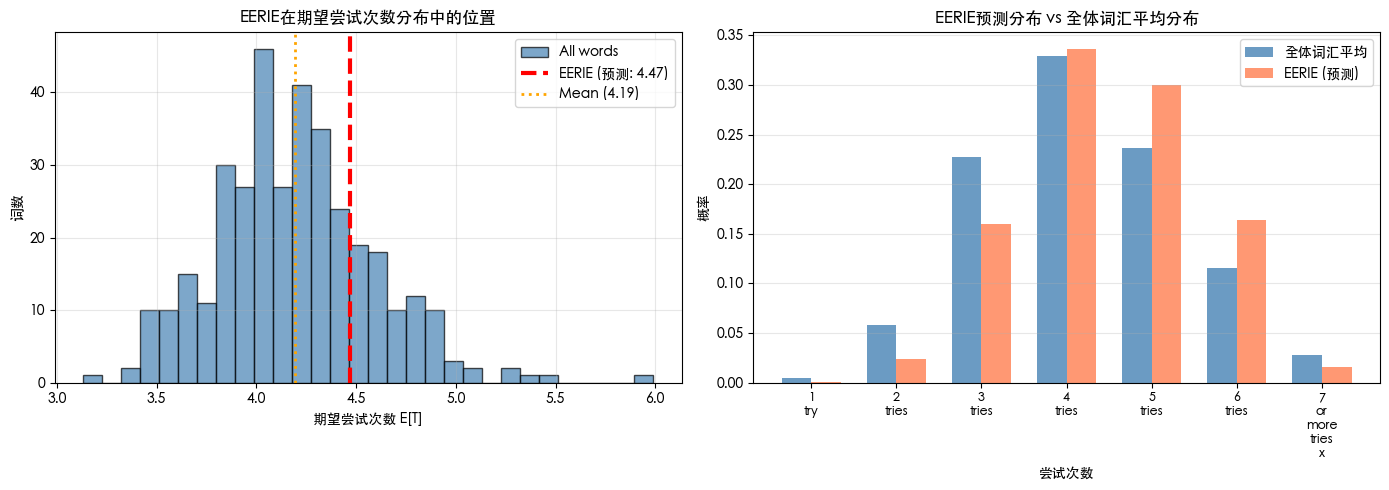


✓ 图表已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/eerie_difficulty_analysis.png


In [38]:
# ==================== 11.3 EERIE 难度定位分析 ====================
print("\n" + "=" * 70)
print("11.3 EERIE 难度定位分析")
print("=" * 70)

# EERIE是测试数据，没有真实的1-7分布，但我们有模型预测
# 使用模型预测的分布来分析EERIE的难度

print(f"\n{'='*50}")
print("EERIE 基本信息")
print(f"{'='*50}")

# 检查是否有模型预测的EERIE分布
if 'P_mean_holdout' in dir() and P_mean_holdout is not None and len(P_mean_holdout) > 0:
    # 使用模型预测的分布
    eerie_pred_dist = P_mean_holdout[0]  # Bootstrap平均预测
    eerie_pred_dist = eerie_pred_dist / eerie_pred_dist.sum()  # 确保归一化
    
    # 计算基于预测的难度指标
    eerie_expected_tries = (eerie_pred_dist * try_values).sum()
    eerie_high_try_prob = eerie_pred_dist[5] + eerie_pred_dist[6]  # P(T>=6)
    eerie_tail_prob = eerie_pred_dist[6]  # P(T=7+)
    eerie_low_try_prob = eerie_pred_dist[0] + eerie_pred_dist[1] + eerie_pred_dist[2]
    
    print(f"\n【注意】EERIE是测试样本，使用MoE模型预测分布进行分析\n")
    
    print(f"EERIE 预测分布 (Bootstrap平均):")
    for i, col in enumerate(TRUE_DIST_COLS):
        print(f"  {col}: {eerie_pred_dist[i]:.4f}")
    
    print(f"\nEERIE 预测难度指标:")
    print(f"  期望尝试次数 E[T]: {eerie_expected_tries:.3f}")
    print(f"  高尝试概率 P(T>=6): {eerie_high_try_prob:.4f}")
    print(f"  尾部概率 P(T=7+): {eerie_tail_prob:.4f}")
    print(f"  低尝试概率 P(T<=3): {eerie_low_try_prob:.4f}")
    
    # 在全体分布中定位eerie
    print(f"\n{'='*50}")
    print("EERIE 在全体词汇中的难度排名")
    print(f"{'='*50}")
    
    # 计算分位数
    all_expected_tries = df_analysis["expected_tries"].dropna().values
    eerie_percentile_et = (all_expected_tries < eerie_expected_tries).mean() * 100
    
    all_high_try = df_analysis["high_try_prob"].dropna().values
    eerie_percentile_ht = (all_high_try < eerie_high_try_prob).mean() * 100
    
    all_tail = df_analysis["tail_prob"].dropna().values
    eerie_percentile_tail = (all_tail < eerie_tail_prob).mean() * 100
    
    print(f"\n  期望尝试次数: EERIE={eerie_expected_tries:.3f}, 超过{eerie_percentile_et:.1f}%的词")
    print(f"  高尝试概率:   EERIE={eerie_high_try_prob:.4f}, 超过{eerie_percentile_ht:.1f}%的词")
    print(f"  尾部概率:     EERIE={eerie_tail_prob:.4f}, 超过{eerie_percentile_tail:.1f}%的词")
    
    # 判断难度
    difficulty_judgment = "难词" if eerie_percentile_et > 50 else "简单词"
    difficulty_level = "非常难" if eerie_percentile_et > 80 else ("较难" if eerie_percentile_et > 60 else ("中等" if eerie_percentile_et > 40 else ("较易" if eerie_percentile_et > 20 else "非常易")))
    
    print(f"\n【结论】EERIE 是 {difficulty_judgment} ({difficulty_level})")
    print(f"  - 期望尝试次数排名: 第{int(eerie_percentile_et)}百分位")
    print(f"  - 解释: 比{eerie_percentile_et:.1f}%的词{'更难猜' if eerie_percentile_et > 50 else '更容易猜'}")
    
    # 与各专家负责词汇的对比
    print(f"\n{'='*50}")
    print("EERIE 与各专家负责词汇的对比")
    print(f"{'='*50}")
    
    for exp in range(NUM_EXPERTS):
        mask = df_analysis["assigned_expert"] == exp
        exp_et = df_analysis.loc[mask, "expected_tries"].mean()
        exp_et_std = df_analysis.loc[mask, "expected_tries"].std()
        
        # 计算z-score
        if exp_et_std > 0:
            z_score = (eerie_expected_tries - exp_et) / exp_et_std
        else:
            z_score = 0
        
        comparison = "更难" if eerie_expected_tries > exp_et else "更易"
        print(f"\n  vs Expert {exp} (n={mask.sum()}):")
        print(f"    Expert {exp} 平均E[T]: {exp_et:.3f} ± {exp_et_std:.3f}")
        print(f"    EERIE 预测E[T]: {eerie_expected_tries:.3f}")
        print(f"    Z-score: {z_score:+.2f} (EERIE 比该专家词汇{comparison})")
    
    # 可视化eerie在分布中的位置
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 图1: E[T]分布与eerie位置
    ax1 = axes[0]
    ax1.hist(all_expected_tries, bins=30, color='steelblue', alpha=0.7, edgecolor='black', label='All words')
    ax1.axvline(eerie_expected_tries, color='red', linewidth=3, linestyle='--', label=f'EERIE (预测: {eerie_expected_tries:.2f})')
    ax1.axvline(np.mean(all_expected_tries), color='orange', linewidth=2, linestyle=':', label=f'Mean ({np.mean(all_expected_tries):.2f})')
    ax1.set_xlabel("期望尝试次数 E[T]", fontweight='bold')
    ax1.set_ylabel("词数", fontweight='bold')
    ax1.set_title("EERIE在期望尝试次数分布中的位置", fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # 图2: eerie预测分布 vs 全体平均
    ax2 = axes[1]
    x = np.arange(len(TRUE_DIST_COLS))
    all_mean_dist = df_analysis[TRUE_DIST_COLS].mean().values
    all_mean_dist = all_mean_dist / all_mean_dist.sum()  # 归一化
    
    width = 0.35
    ax2.bar(x - width/2, all_mean_dist, width, label='全体词汇平均', color='steelblue', alpha=0.8)
    ax2.bar(x + width/2, eerie_pred_dist, width, label='EERIE (预测)', color='coral', alpha=0.8)
    ax2.set_xticks(x)
    ax2.set_xticklabels([c.replace("_", "\n") for c in TRUE_DIST_COLS], fontsize=9)
    ax2.set_xlabel("尝试次数", fontweight='bold')
    ax2.set_ylabel("概率", fontweight='bold')
    ax2.set_title("EERIE预测分布 vs 全体词汇平均分布", fontweight='bold')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "eerie_difficulty_analysis.png"), dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ 图表已保存至: {os.path.join(OUTPUT_DIR, 'eerie_difficulty_analysis.png')}")
else:
    print("未找到EERIE的模型预测结果，跳过分析")
    # 设置默认值以避免后续报告生成出错
    eerie_expected_tries = np.nan
    eerie_high_try_prob = np.nan
    eerie_tail_prob = np.nan
    eerie_percentile_et = 0
    eerie_percentile_ht = 0
    eerie_percentile_tail = 0
    difficulty_judgment = "未知"
    difficulty_level = "未知"

### 11.4 词属性聚类分析

本节对词汇属性进行聚类分析，探究影响Wordle单词难度的关键因素。

**聚类目标**：
1. 发现词汇属性的自然分组结构
2. 分析各聚类簇的难度特征差异
3. 识别影响难度的关键属性因素

**分析方法**：
- 特征标准化（Z-score）
- 最优聚类数选择（轮廓系数 + 肘部法则）
- K-Means聚类
- 聚类结果与难度指标的关联分析

In [39]:
# # ==================== 11.4.1 聚类特征准备与标准化 ====================
# print("=" * 70)
# print("11.4.1 聚类特征准备与标准化")
# print("=" * 70)

# # 定义用于聚类的词属性特征
# CLUSTER_FEATURES = [
#     "Zipf-value",           # 词频（Zipf定律）
#     "letter_entropy",       # 字母熵
#     "feedback_entropy",     # 反馈熵
#     "max_consecutive_vowels",  # 最大连续元音数
#     "letter_freq_mean",     # 平均字母频率
#     "scrabble_score",       # Scrabble分数（字母难度）
#     "has_common_suffix",    # 是否有常见后缀
#     "num_rare_letters",     # 稀有字母数量
#     "position_rarity",      # 位置稀有度
#     "positional_freq_min",  # 最小位置频率
#     "hamming_neighbors",    # 汉明邻居数
#     "keyboard_distance",    # 键盘距离
#     "semantic_distance",    # 语义距离
# ]

# # 检查哪些特征可用
# available_cluster_features = [f for f in CLUSTER_FEATURES if f in df_analysis.columns]
# missing_features = [f for f in CLUSTER_FEATURES if f not in df_analysis.columns]

# print(f"\n可用聚类特征 ({len(available_cluster_features)}/{len(CLUSTER_FEATURES)}):")
# for f in available_cluster_features:
#     print(f"  ✓ {f}")

# if missing_features:
#     print(f"\n缺失特征 ({len(missing_features)}):")
#     for f in missing_features:
#         print(f"  ✗ {f}")

# # 提取聚类特征矩阵
# X_cluster = df_analysis[available_cluster_features].copy()

# # 处理缺失值（用中位数填充）
# print(f"\n处理缺失值...")
# for col in available_cluster_features:
#     n_missing = X_cluster[col].isna().sum()
#     if n_missing > 0:
#         median_val = X_cluster[col].median()
#         X_cluster[col] = X_cluster[col].fillna(median_val)
#         print(f"  {col}: 填充 {n_missing} 个缺失值 (中位数={median_val:.4f})")

# # 标准化
# from sklearn.preprocessing import StandardScaler
# cluster_scaler = StandardScaler()
# X_cluster_scaled = cluster_scaler.fit_transform(X_cluster)

# print(f"\n特征标准化完成")
# print(f"  样本数: {X_cluster_scaled.shape[0]}")
# print(f"  特征数: {X_cluster_scaled.shape[1]}")

# # 保存用于后续分析
# df_analysis_cluster = df_analysis.copy()
# for i, feat in enumerate(available_cluster_features):
#     df_analysis_cluster[f"{feat}_scaled"] = X_cluster_scaled[:, i]

In [40]:
# # ==================== 11.4.2 最优聚类数选择 ====================
# print("\n" + "=" * 70)
# print("11.4.2 最优聚类数选择")
# print("=" * 70)

# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score, calinski_harabasz_score

# # 测试不同聚类数（缩小范围以避免内存问题）
# K_range = range(2, 8)
# inertias = []
# silhouettes = []
# ch_scores = []

# print("\n计算不同K值的评估指标...")
# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10, max_iter=300)
#     labels = kmeans.fit_predict(X_cluster_scaled)
    
#     inertias.append(kmeans.inertia_)
#     silhouettes.append(silhouette_score(X_cluster_scaled, labels))
#     ch_scores.append(calinski_harabasz_score(X_cluster_scaled, labels))
    
#     print(f"  K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouettes[-1]:.4f}, CH={ch_scores[-1]:.2f}")

# # 可视化
# fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# # 图1: 肘部法则
# ax1 = axes[0]
# ax1.plot(list(K_range), inertias, 'bo-', linewidth=2, markersize=8)
# ax1.set_xlabel("聚类数 K", fontweight='bold')
# ax1.set_ylabel("Inertia (SSE)", fontweight='bold')
# ax1.set_title("肘部法则 (Elbow Method)", fontweight='bold')
# ax1.grid(alpha=0.3)

# # 图2: 轮廓系数
# ax2 = axes[1]
# ax2.plot(list(K_range), silhouettes, 'go-', linewidth=2, markersize=8)
# best_k_silhouette = list(K_range)[np.argmax(silhouettes)]
# ax2.axvline(best_k_silhouette, color='red', linestyle='--', label=f'Best K={best_k_silhouette}')
# ax2.set_xlabel("聚类数 K", fontweight='bold')
# ax2.set_ylabel("轮廓系数", fontweight='bold')
# ax2.set_title("轮廓系数 (Silhouette Score)", fontweight='bold')
# ax2.legend()
# ax2.grid(alpha=0.3)

# # 图3: Calinski-Harabasz指数
# ax3 = axes[2]
# ax3.plot(list(K_range), ch_scores, 'ro-', linewidth=2, markersize=8)
# best_k_ch = list(K_range)[np.argmax(ch_scores)]
# ax3.axvline(best_k_ch, color='blue', linestyle='--', label=f'Best K={best_k_ch}')
# ax3.set_xlabel("聚类数 K", fontweight='bold')
# ax3.set_ylabel("CH指数", fontweight='bold')
# ax3.set_title("Calinski-Harabasz Index", fontweight='bold')
# ax3.legend()
# ax3.grid(alpha=0.3)

# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, "cluster_k_selection.png"), dpi=150, bbox_inches='tight')
# plt.show()

# # 选择最优K（以轮廓系数为主，但至少为3以获得有意义的分析）
# optimal_k = max(3, best_k_silhouette)
# print(f"\n【最优聚类数选择】")
# print(f"  轮廓系数最优: K={best_k_silhouette} (Silhouette={max(silhouettes):.4f})")
# print(f"  CH指数最优: K={best_k_ch} (CH={max(ch_scores):.2f})")
# print(f"  选定聚类数: K={optimal_k}")

In [41]:
# # ==================== 11.4.3 K-Means聚类与结果分析 ====================
# print("\n" + "=" * 70)
# print("11.4.3 K-Means聚类与结果分析")
# print("=" * 70)

# # 执行K-Means聚类
# kmeans_final = KMeans(n_clusters=optimal_k, random_state=RANDOM_SEED, n_init=10)
# cluster_labels = kmeans_final.fit_predict(X_cluster_scaled)

# df_analysis_cluster["cluster"] = cluster_labels

# # 聚类分布统计
# print(f"\n聚类分布:")
# cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
# for c, count in cluster_counts.items():
#     pct = count / len(cluster_labels) * 100
#     print(f"  Cluster {c}: {count} 词 ({pct:.1f}%)")

# # 各聚类的难度指标统计
# print("\n" + "-" * 70)
# print("各聚类的难度指标统计")
# print("-" * 70)

# cluster_difficulty = []
# for c in range(optimal_k):
#     mask = df_analysis_cluster["cluster"] == c
#     n_words = mask.sum()
    
#     row = {"Cluster": c, "词数": n_words}
    
#     # 难度指标
#     row["E[T]_mean"] = df_analysis_cluster.loc[mask, "expected_tries"].mean()
#     row["E[T]_std"] = df_analysis_cluster.loc[mask, "expected_tries"].std()
#     row["P(T>=6)_mean"] = df_analysis_cluster.loc[mask, "high_try_prob"].mean()
#     row["tail_prob_mean"] = df_analysis_cluster.loc[mask, "tail_prob"].mean()
    
#     if "autoencoder_value" in df_analysis_cluster.columns:
#         row["AE_mean"] = df_analysis_cluster.loc[mask, "autoencoder_value"].mean()
    
#     cluster_difficulty.append(row)

# df_cluster_difficulty = pd.DataFrame(cluster_difficulty)

# # 按E[T]排序
# df_cluster_difficulty = df_cluster_difficulty.sort_values("E[T]_mean")

# print(f"\n{'Cluster':<10} {'词数':<8} {'E[T]':<15} {'P(T>=6)':<12} {'P(T=7+)':<12}", end="")
# if "autoencoder_value" in df_analysis_cluster.columns:
#     print(f" {'AE值':<12}")
# else:
#     print()
# print("-" * 75)

# for _, row in df_cluster_difficulty.iterrows():
#     line = f"C{int(row['Cluster']):<9} {int(row['词数']):<8} {row['E[T]_mean']:.3f}±{row['E[T]_std']:.3f}   {row['P(T>=6)_mean']:.4f}      {row['tail_prob_mean']:.4f}     "
#     if "AE_mean" in row:
#         line += f" {row['AE_mean']:.4f}"
#     print(line)

# # 给聚类命名（基于难度）
# difficulty_order = df_cluster_difficulty["Cluster"].tolist()
# cluster_names = {}
# difficulty_labels = ["简单", "中等", "较难", "困难", "极难"][:optimal_k]
# for i, c in enumerate(difficulty_order):
#     cluster_names[c] = f"C{c} ({difficulty_labels[i]})"

# print(f"\n聚类难度命名:")
# for c, name in cluster_names.items():
#     et = df_cluster_difficulty[df_cluster_difficulty["Cluster"] == c]["E[T]_mean"].values[0]
#     print(f"  {name}: E[T]={et:.3f}")

In [42]:
# # ==================== 11.4.4 聚类特征画像分析 ====================
# print("\n" + "=" * 70)
# print("11.4.4 聚类特征画像分析")
# print("=" * 70)

# # 计算每个聚类在各特征上的均值
# cluster_feature_means = []
# for c in range(optimal_k):
#     mask = df_analysis_cluster["cluster"] == c
#     row = {"Cluster": c}
#     for feat in available_cluster_features:
#         row[feat] = df_analysis_cluster.loc[mask, feat].mean()
#     cluster_feature_means.append(row)

# df_cluster_features = pd.DataFrame(cluster_feature_means)

# # 计算全体均值用于比较
# overall_means = {feat: df_analysis_cluster[feat].mean() for feat in available_cluster_features}

# # 绘制聚类特征雷达图
# from math import pi

# # 标准化特征均值用于雷达图
# feature_for_radar = available_cluster_features[:8]  # 选择前8个特征
# n_features_radar = len(feature_for_radar)

# fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# angles = [n / float(n_features_radar) * 2 * pi for n in range(n_features_radar)]
# angles += angles[:1]  # 闭合

# colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))

# for c in range(optimal_k):
#     values = []
#     for feat in feature_for_radar:
#         # 相对于全体均值的比值
#         cluster_val = df_cluster_features[df_cluster_features["Cluster"] == c][feat].values[0]
#         overall_val = overall_means[feat]
#         if overall_val != 0:
#             ratio = cluster_val / overall_val
#         else:
#             ratio = 1
#         values.append(ratio)
#     values += values[:1]
    
#     ax.plot(angles, values, 'o-', linewidth=2, label=cluster_names.get(c, f"C{c}"), color=colors[c])
#     ax.fill(angles, values, alpha=0.1, color=colors[c])

# ax.set_xticks(angles[:-1])
# ax.set_xticklabels(feature_for_radar, fontsize=9)
# ax.set_title("聚类特征画像 (相对全体均值的比值)", fontweight='bold', fontsize=13, pad=20)
# ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
# ax.set_ylim(0, 2)

# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, "cluster_feature_radar.png"), dpi=150, bbox_inches='tight')
# plt.show()

# # 打印各聚类的关键特征差异
# print("\n各聚类的关键特征差异 (相对全体均值):")
# print("-" * 70)

# for c in range(optimal_k):
#     print(f"\n【{cluster_names.get(c, f'Cluster {c}')}】")
#     diffs = []
#     for feat in available_cluster_features:
#         cluster_val = df_cluster_features[df_cluster_features["Cluster"] == c][feat].values[0]
#         overall_val = overall_means[feat]
#         if overall_val != 0:
#             pct_diff = (cluster_val - overall_val) / abs(overall_val) * 100
#         else:
#             pct_diff = 0
#         diffs.append((feat, cluster_val, overall_val, pct_diff))
    
#     # 按差异绝对值排序，显示最显著的差异
#     diffs_sorted = sorted(diffs, key=lambda x: abs(x[3]), reverse=True)[:5]
#     for feat, c_val, o_val, pct in diffs_sorted:
#         direction = "↑" if pct > 0 else "↓"
#         print(f"  {feat}: {c_val:.3f} (全体:{o_val:.3f}, {direction}{abs(pct):.1f}%)")

In [43]:
# # ==================== 11.4.5 聚类与MoE专家分配的关联 ====================
# print("\n" + "=" * 70)
# print("11.4.5 聚类与MoE专家分配的关联")
# print("=" * 70)

# # 计算聚类与专家分配的交叉表
# crosstab = pd.crosstab(df_analysis_cluster["cluster"], df_analysis_cluster["assigned_expert"],
#                        margins=True, margins_name="Total")
# print("\n聚类 × 专家分配 交叉表:")
# print(crosstab)

# # 计算卡方检验
# from scipy.stats import chi2_contingency
# contingency = pd.crosstab(df_analysis_cluster["cluster"], df_analysis_cluster["assigned_expert"])
# chi2, p_val, dof, expected = chi2_contingency(contingency)

# print(f"\n卡方检验:")
# print(f"  χ² = {chi2:.4f}")
# print(f"  p-value = {p_val:.6f}")
# print(f"  自由度 = {dof}")
# print(f"  结论: {'聚类与专家分配存在显著关联' if p_val < 0.05 else '聚类与专家分配无显著关联'}")

# # 计算Cramer's V (关联强度)
# n = contingency.sum().sum()
# min_dim = min(contingency.shape[0] - 1, contingency.shape[1] - 1)
# cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
# print(f"  Cramer's V = {cramers_v:.4f} (关联强度)")

# # 可视化
# fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# # 图1: 热力图
# ax1 = axes[0]
# im = ax1.imshow(contingency.values, cmap='YlOrRd', aspect='auto')
# ax1.set_xticks(range(NUM_EXPERTS))
# ax1.set_xticklabels([f"Expert {e}" for e in range(NUM_EXPERTS)])
# ax1.set_yticks(range(optimal_k))
# ax1.set_yticklabels([cluster_names.get(c, f"C{c}") for c in range(optimal_k)])
# ax1.set_xlabel("MoE专家", fontweight='bold')
# ax1.set_ylabel("聚类", fontweight='bold')
# ax1.set_title("聚类×专家分配热力图", fontweight='bold')

# # 添加数值标注
# for i in range(optimal_k):
#     for j in range(NUM_EXPERTS):
#         text = ax1.text(j, i, contingency.values[i, j],
#                        ha="center", va="center", color="black", fontsize=12)
# fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

# # 图2: 堆叠条形图
# ax2 = axes[1]
# x = np.arange(optimal_k)
# width = 0.6
# bottom = np.zeros(optimal_k)
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# for exp in range(NUM_EXPERTS):
#     values = contingency.iloc[:, exp].values
#     ax2.bar(x, values, width, bottom=bottom, label=f"Expert {exp}", color=colors[exp])
#     bottom += values

# ax2.set_xticks(x)
# ax2.set_xticklabels([cluster_names.get(c, f"C{c}") for c in range(optimal_k)], rotation=30, ha='right')
# ax2.set_xlabel("聚类", fontweight='bold')
# ax2.set_ylabel("词数", fontweight='bold')
# ax2.set_title("各聚类的专家分配构成", fontweight='bold')
# ax2.legend()
# ax2.grid(axis='y', alpha=0.3)

# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, "cluster_expert_association.png"), dpi=150, bbox_inches='tight')
# plt.show()

# print(f"\n✓ 图表已保存至: {os.path.join(OUTPUT_DIR, 'cluster_expert_association.png')}")

In [44]:
# # ==================== 11.4.6 影响难度的关键因素分析 ====================
# print("\n" + "=" * 70)
# print("11.4.6 影响难度的关键因素分析")
# print("=" * 70)

# # 方法1: 特征与难度指标的相关性分析
# print("\n【方法1】特征与难度指标的Pearson相关系数")
# print("-" * 70)

# correlations = []
# for feat in available_cluster_features:
#     corr_et = df_analysis_cluster[[feat, "expected_tries"]].corr().iloc[0, 1]
#     corr_ht = df_analysis_cluster[[feat, "high_try_prob"]].corr().iloc[0, 1]
#     correlations.append({
#         "Feature": feat,
#         "corr_E[T]": corr_et,
#         "corr_P(T>=6)": corr_ht,
#         "abs_corr_ET": abs(corr_et)
#     })

# df_corr = pd.DataFrame(correlations).sort_values("abs_corr_ET", ascending=False)

# print(f"\n{'特征':<25} {'与E[T]相关':<15} {'与P(T>=6)相关':<15} {'影响方向':<10}")
# print("-" * 70)
# for _, row in df_corr.iterrows():
#     direction = "难度↑" if row["corr_E[T]"] > 0 else "难度↓"
#     print(f"{row['Feature']:<25} {row['corr_E[T]']:>+.4f}        {row['corr_P(T>=6)']:>+.4f}        {direction}")

# # 方法2: 基于聚类差异的关键因素识别
# print("\n\n【方法2】聚类间差异最大的特征 (影响难度的关键因素)")
# print("-" * 70)

# # 计算各特征在最简单和最难聚类之间的差异
# easiest_cluster = df_cluster_difficulty["Cluster"].iloc[0]
# hardest_cluster = df_cluster_difficulty["Cluster"].iloc[-1]

# feature_importance = []
# for feat in available_cluster_features:
#     easy_mean = df_analysis_cluster[df_analysis_cluster["cluster"] == easiest_cluster][feat].mean()
#     hard_mean = df_analysis_cluster[df_analysis_cluster["cluster"] == hardest_cluster][feat].mean()
#     overall_std = df_analysis_cluster[feat].std()
    
#     # 标准化差异
#     if overall_std > 0:
#         std_diff = (hard_mean - easy_mean) / overall_std
#     else:
#         std_diff = 0
    
#     feature_importance.append({
#         "Feature": feat,
#         "Easy_mean": easy_mean,
#         "Hard_mean": hard_mean,
#         "Diff": hard_mean - easy_mean,
#         "Std_Diff": std_diff,
#         "Abs_Std_Diff": abs(std_diff)
#     })

# df_importance = pd.DataFrame(feature_importance).sort_values("Abs_Std_Diff", ascending=False)

# print(f"\n比较: Cluster {int(easiest_cluster)} (最简单) vs Cluster {int(hardest_cluster)} (最难)")
# print(f"\n{'特征':<25} {'简单词均值':<12} {'难词均值':<12} {'标准化差异':<12} {'解释'}")
# print("-" * 85)

# for _, row in df_importance.head(10).iterrows():
#     direction = "难词更高" if row["Std_Diff"] > 0 else "难词更低"
#     print(f"{row['Feature']:<25} {row['Easy_mean']:<12.4f} {row['Hard_mean']:<12.4f} {row['Std_Diff']:>+.4f}       {direction}")

# # 可视化: 关键因素的影响
# fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# # 图1: 相关性条形图
# ax1 = axes[0]
# top_corr = df_corr.head(10)
# colors = ['coral' if c > 0 else 'steelblue' for c in top_corr["corr_E[T]"]]
# bars = ax1.barh(range(len(top_corr)), top_corr["corr_E[T]"], color=colors, edgecolor='black')
# ax1.set_yticks(range(len(top_corr)))
# ax1.set_yticklabels(top_corr["Feature"])
# ax1.axvline(0, color='black', linewidth=0.8)
# ax1.set_xlabel("与E[T]的相关系数", fontweight='bold')
# ax1.set_title("特征与难度(E[T])的相关性", fontweight='bold')
# ax1.grid(axis='x', alpha=0.3)
# ax1.invert_yaxis()

# # 图2: 聚类差异条形图
# ax2 = axes[1]
# top_imp = df_importance.head(10)
# colors = ['coral' if d > 0 else 'steelblue' for d in top_imp["Std_Diff"]]
# bars = ax2.barh(range(len(top_imp)), top_imp["Std_Diff"], color=colors, edgecolor='black')
# ax2.set_yticks(range(len(top_imp)))
# ax2.set_yticklabels(top_imp["Feature"])
# ax2.axvline(0, color='black', linewidth=0.8)
# ax2.set_xlabel("标准化差异 (难词-简单词)", fontweight='bold')
# ax2.set_title("简单词 vs 难词的特征差异", fontweight='bold')
# ax2.grid(axis='x', alpha=0.3)
# ax2.invert_yaxis()

# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, "difficulty_key_factors.png"), dpi=150, bbox_inches='tight')
# plt.show()

# print(f"\n✓ 图表已保存至: {os.path.join(OUTPUT_DIR, 'difficulty_key_factors.png')}")

In [45]:
# # ==================== 11.5 综合分析报告生成 ====================
# print("\n" + "=" * 70)
# print("11.5 生成综合分析报告")
# print("=" * 70)

# # 生成Markdown报告
# report_11 = f"""# 专家分配难度验证与词属性聚类分析报告

# **生成时间**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

# ---

# ## 1. 研究目标

# 本报告旨在验证MoE模型的专家分配是否真正区分了词汇的"属性难度"，并通过聚类分析探究影响Wordle单词难度的关键因素。

# ## 2. 数据概述

# - **分析词汇数**: {len(df_analysis)} (排除eerie)
# - **MoE专家数**: {NUM_EXPERTS}
# - **聚类特征数**: {len(available_cluster_features)}
# - **最优聚类数**: {optimal_k}

# ## 3. 难度指标定义

# | 指标 | 定义 | 含义 |
# |------|------|------|
# | E[T] | $\\sum_{{i=1}}^{{7}} i \\cdot P(T=i)$ | 期望尝试次数，越高越难 |
# | P(T≥6) | $P(T=6) + P(T=7+)$ | 高尝试概率，衡量尾部难度 |
# | P(T=7+) | 7次及以上的概率 | 失败风险 |
# | difficulty_score | 标准化综合评分 | 多指标加权 |

# ## 4. 专家分配难度区分性验证

# ### 4.1 各专家负责词汇的难度统计

# | 专家 | 词数 | E[T] (mean±std) | P(T≥6) |
# |------|------|-----------------|--------|
# """

# # 添加专家统计
# for exp in range(NUM_EXPERTS):
#     mask = df_analysis["assigned_expert"] == exp
#     n = mask.sum()
#     et_mean = df_analysis.loc[mask, "expected_tries"].mean()
#     et_std = df_analysis.loc[mask, "expected_tries"].std()
#     ht_mean = df_analysis.loc[mask, "high_try_prob"].mean()
#     report_11 += f"| Expert {exp} | {n} | {et_mean:.3f}±{et_std:.3f} | {ht_mean:.4f} |\n"

# # 添加统计检验结果
# report_11 += f"""
# ### 4.2 统计检验结果

# **Kruskal-Wallis H检验** (检验专家组间难度差异):

# | 指标 | H统计量 | p值 | 显著性 |
# |------|---------|-----|--------|
# """

# for r in kw_results:
#     sig = "***" if r['p_value'] < 0.001 else ("**" if r['p_value'] < 0.01 else ("*" if r['p_value'] < 0.05 else "-"))
#     report_11 += f"| {r['Metric']} | {r['H_statistic']:.4f} | {r['p_value']:.6f} | {sig} |\n"

# # 判断专家分配是否区分难度
# sig_metrics = sum(1 for r in kw_results if r['significant'])
# total_metrics = len(kw_results)
# expert_diff_conclusion = "是" if sig_metrics >= total_metrics / 2 else "否"

# report_11 += f"""
# **结论**: {sig_metrics}/{total_metrics} 个难度指标在专家间存在显著差异，专家分配{"能够" if expert_diff_conclusion == "是" else "不能"}有效区分词汇难度。

# ### 4.3 专家难度画像

# """

# # 按E[T]排序专家
# exp_et = [(exp, df_analysis[df_analysis["assigned_expert"]==exp]["expected_tries"].mean()) 
#           for exp in range(NUM_EXPERTS)]
# exp_et_sorted = sorted(exp_et, key=lambda x: x[1])

# for rank, (exp, et) in enumerate(exp_et_sorted):
#     difficulty_label = ["最简单", "中等", "最难"][rank] if NUM_EXPERTS == 3 else f"第{rank+1}"
#     mask = df_analysis["assigned_expert"] == exp
#     n = mask.sum()
#     top_words = df_analysis.loc[mask].nlargest(5, "expected_tries")["word"].tolist()
#     report_11 += f"- **Expert {exp}** ({difficulty_label}): E[T]={et:.3f}, {n}词, 代表难词: {', '.join(top_words)}\n"

# # EERIE分析
# report_11 += f"""
# ## 5. EERIE 难度定位分析

# """

# if 'eerie_expected_tries' in dir():
#     report_11 += f"""### 5.1 EERIE 难度指标

# | 指标 | EERIE值 | 全体均值 | 百分位排名 |
# |------|---------|----------|------------|
# | E[T] | {eerie_expected_tries:.3f} | {df_analysis['expected_tries'].mean():.3f} | {eerie_percentile_et:.1f}% |
# | P(T≥6) | {eerie_high_try_prob:.4f} | {df_analysis['high_try_prob'].mean():.4f} | {eerie_percentile_ht:.1f}% |
# | P(T=7+) | {eerie_tail_prob:.4f} | {df_analysis['tail_prob'].mean():.4f} | {eerie_percentile_tail:.1f}% |

# ### 5.2 EERIE 难度判定

# **【结论】EERIE 是 {difficulty_judgment}**

# - 期望尝试次数 E[T]={eerie_expected_tries:.3f}，超过 {eerie_percentile_et:.1f}% 的词汇
# - 难度级别: {difficulty_level}
# - 解释: EERIE 比大多数词汇{'更难' if eerie_percentile_et > 50 else '更容易'}猜测
# """
# else:
#     report_11 += "（未能获取EERIE数据进行分析）\n"

# # 聚类分析
# report_11 += f"""
# ## 6. 词属性聚类分析

# ### 6.1 聚类配置

# - **聚类方法**: K-Means
# - **聚类数**: {optimal_k} (基于轮廓系数选择)
# - **特征数**: {len(available_cluster_features)}

# ### 6.2 聚类难度分布

# | 聚类 | 词数 | E[T] | P(T≥6) | 难度标签 |
# |------|------|------|--------|----------|
# """

# for _, row in df_cluster_difficulty.iterrows():
#     c = int(row['Cluster'])
#     report_11 += f"| C{c} | {int(row['词数'])} | {row['E[T]_mean']:.3f} | {row['P(T>=6)_mean']:.4f} | {cluster_names.get(c, '')} |\n"

# # 关键因素
# report_11 += f"""
# ### 6.3 影响难度的关键因素

# 基于相关性分析和聚类差异分析，以下特征对Wordle单词难度影响最显著：

# | 排名 | 特征 | 与E[T]相关性 | 影响方向 |
# |------|------|--------------|----------|
# """

# for i, (_, row) in enumerate(df_corr.head(5).iterrows()):
#     direction = "正相关(值高→难)" if row["corr_E[T]"] > 0 else "负相关(值低→难)"
#     report_11 += f"| {i+1} | {row['Feature']} | {row['corr_E[T]']:+.4f} | {direction} |\n"

# # 聚类与专家关联
# report_11 += f"""
# ### 6.4 聚类与专家分配的关联

# - **卡方检验**: χ²={chi2:.4f}, p={p_val:.6f}
# - **Cramer's V**: {cramers_v:.4f}
# - **结论**: 聚类与专家分配{'存在显著关联' if p_val < 0.05 else '无显著关联'}

# ## 7. 研究结论

# ### 7.1 专家分配的难度区分性

# """

# if expert_diff_conclusion == "是":
#     report_11 += f"""MoE模型的专家分配**确实能够区分词汇难度**：
# - {sig_metrics}/{total_metrics} 个难度指标在专家间存在显著差异
# - 不同专家负责的词汇呈现明显的难度梯度
# """
# else:
#     report_11 += "MoE模型的专家分配**未能有效区分词汇难度**，专家的分工可能更多基于其他词汇特征。\n"

# report_11 += f"""
# ### 7.2 EERIE 难度定位

# """
# if 'eerie_expected_tries' in dir():
#     report_11 += f"EERIE是一个**{difficulty_judgment}**，其E[T]={eerie_expected_tries:.3f}，超过{eerie_percentile_et:.1f}%的词汇。\n"

# report_11 += f"""
# ### 7.3 影响难度的关键因素

# 基于聚类分析，以下词汇属性对难度影响最大：

# 1. **{df_corr.iloc[0]['Feature']}**: 与难度相关性最强 (r={df_corr.iloc[0]['corr_E[T]']:+.3f})
# 2. **{df_corr.iloc[1]['Feature']}**: 次要影响因素 (r={df_corr.iloc[1]['corr_E[T]']:+.3f})
# 3. **{df_corr.iloc[2]['Feature']}**: 显著影响因素 (r={df_corr.iloc[2]['corr_E[T]']:+.3f})

# ---

# ## 附录: 输出文件

# - `expert_difficulty_comparison.png`: 专家难度指标对比图
# - `expert_true_distribution_comparison.png`: 专家真实分布对比图
# - `eerie_difficulty_analysis.png`: EERIE难度定位图
# - `cluster_k_selection.png`: 聚类数选择图
# - `cluster_feature_radar.png`: 聚类特征雷达图
# - `cluster_expert_association.png`: 聚类与专家关联图
# - `difficulty_key_factors.png`: 难度关键因素图

# ---

# *本报告由MoE分析模块自动生成*
# """

# # 保存报告
# report_path_11 = os.path.join(OUTPUT_DIR, "difficulty_clustering_analysis_report.md")
# with open(report_path_11, "w", encoding="utf-8") as f:
#     f.write(report_11)

# print(f"✓ 综合分析报告已保存至: {report_path_11}")

# # 保存聚类结果
# cluster_output_path = os.path.join(OUTPUT_DIR, "word_clustering_results.csv")
# df_analysis_cluster[["word", "assigned_expert", "cluster", "expected_tries", "high_try_prob", "difficulty_score"] + available_cluster_features].to_csv(cluster_output_path, index=False)
# print(f"✓ 聚类结果已保存至: {cluster_output_path}")

# print("\n" + "=" * 70)
# print("分析完成！")
# print("=" * 70)

## 12. 专家-难度深度分析与词属性因素探究

本节将从多个角度深入分析MoE专家分配与难度的关系，并使用多种统计和机器学习方法识别影响难度的关键词属性因素。

**分析框架**：
1. **12.1-12.3**: 专家-难度关系深度分析（分布对比、特化度量、门控权重分析）
2. **12.4**: 词属性重要性 - 多方法对比（随机森林、XGBoost、PCA、偏相关）
3. **12.5**: 专家-属性交互效应分析
4. **12.6**: 难度预测建模验证
5. **12.7**: 综合可视化面板
6. **12.8**: 深度分析报告生成


12.1 专家内部难度分布深度分析


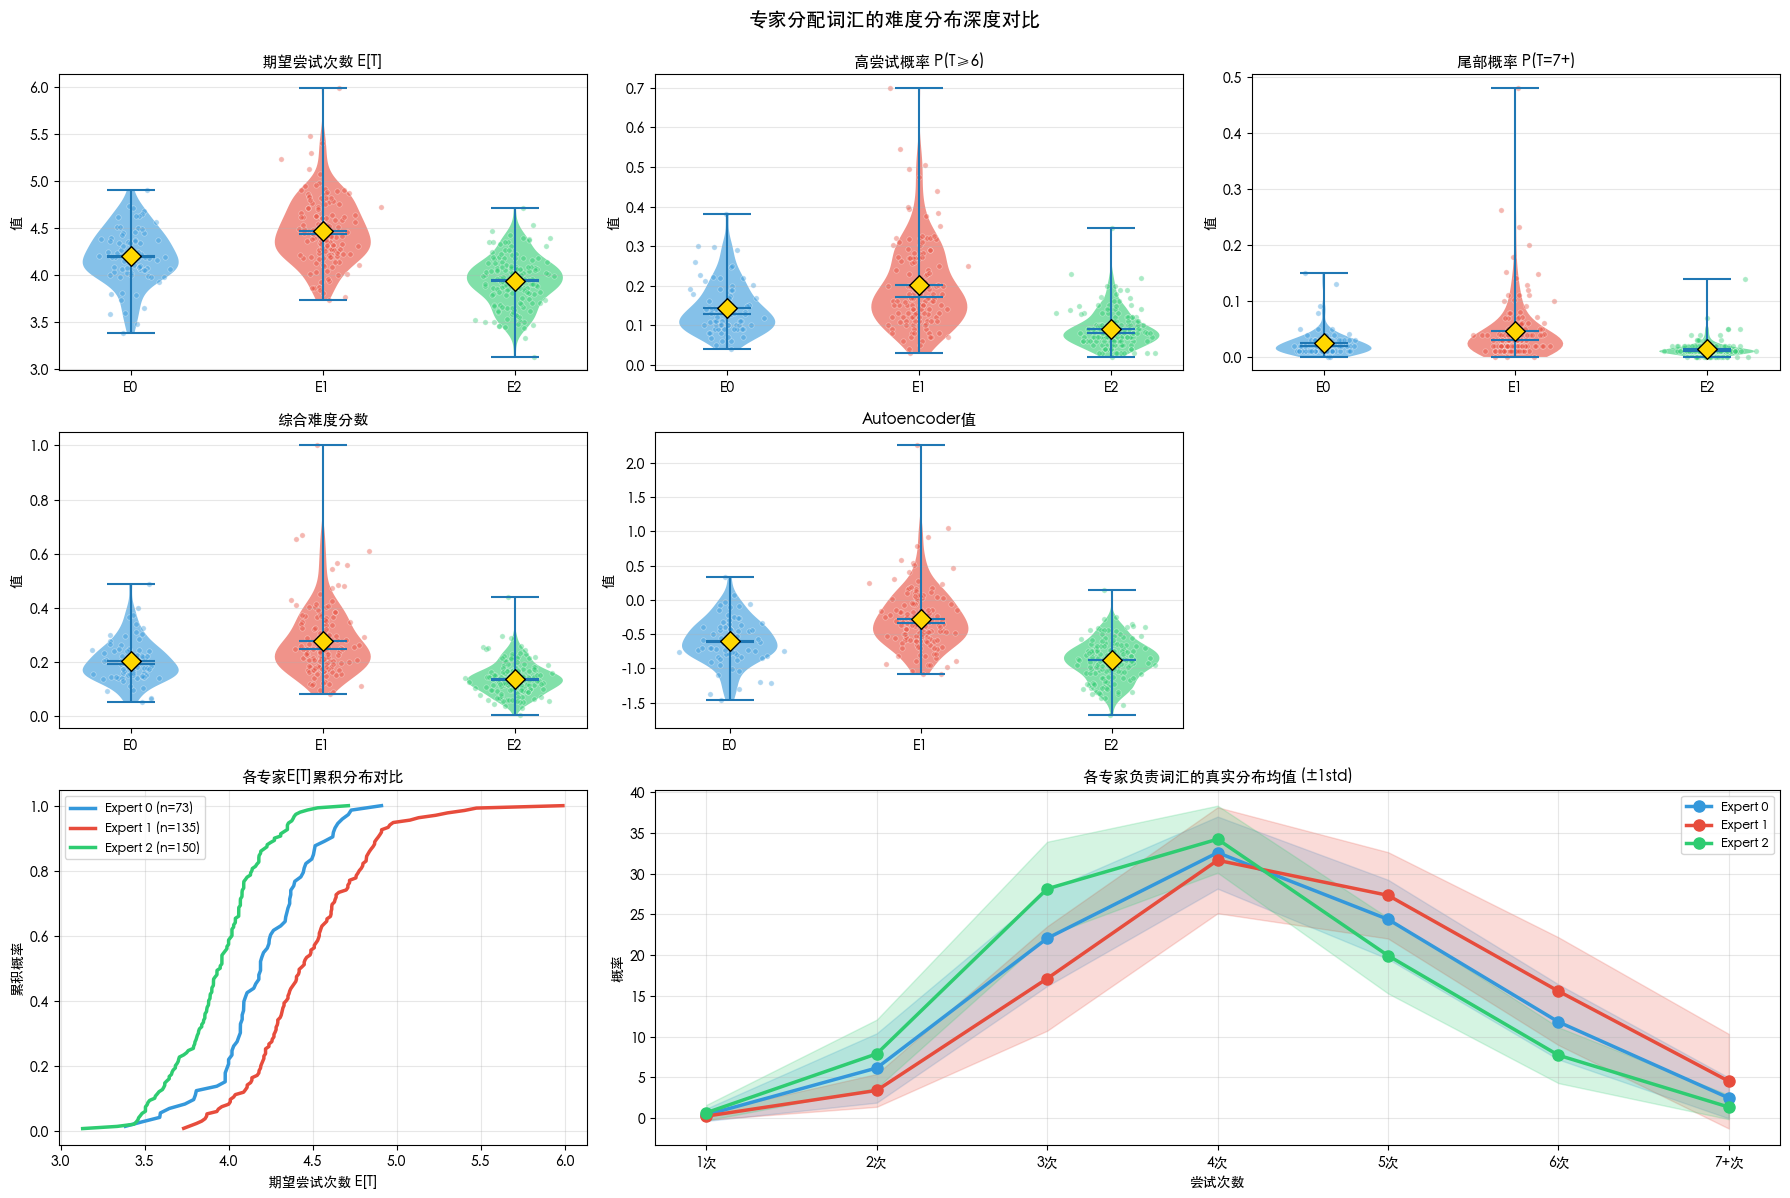

✓ 图表已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/expert_difficulty_combined.png


In [50]:
# ==================== 12.1 专家内部难度分布深度分析 ====================
print("\n" + "=" * 70)
print("12.1 专家内部难度分布深度分析")
print("=" * 70)

from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 准备分析数据
df_deep = df_analysis.copy()

# 图1: 小提琴图 + 蜂群图组合 + 两个新合并的子图
fig = plt.figure(figsize=(18, 12))

# 创建GridSpec布局：前5个子图占据上面两行，最后两个并排在底部
from matplotlib.gridspec import GridSpec
gs = GridSpec(3, 3, figure=fig, height_ratios=[1, 1, 1.2])

# 难度指标列表
metrics_to_plot = ['expected_tries', 'high_try_prob', 'tail_prob', 'difficulty_score', 'autoencoder_value']
metric_names = ['期望尝试次数 E[T]', '高尝试概率 P(T≥6)', '尾部概率 P(T=7+)', '综合难度分数', 'Autoencoder值']

# 专家颜色
expert_colors = ['#3498db', '#e74c3c', '#2ecc71']
expert_names = ['Expert 0 (中等)', 'Expert 1 (最难)', 'Expert 2 (最简单)']

# 前5个子图：小提琴图
for idx, (metric, name) in enumerate(zip(metrics_to_plot, metric_names)):
    row = idx // 3
    col = idx % 3
    ax = fig.add_subplot(gs[row, col])
    
    # 按专家分组数据
    data_by_exp = [df_deep[df_deep['assigned_expert'] == e][metric].dropna().values for e in range(NUM_EXPERTS)]
    
    # 小提琴图
    parts = ax.violinplot(data_by_exp, positions=range(NUM_EXPERTS), showmeans=True, showmedians=True)
    
    # 设置颜色
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(expert_colors[i])
        pc.set_alpha(0.6)
    
    # 添加散点（jitter）
    for i, data in enumerate(data_by_exp):
        jitter = np.random.normal(0, 0.08, len(data))
        ax.scatter(i + jitter, data, alpha=0.4, s=15, c=expert_colors[i], edgecolors='white', linewidth=0.5)
    
    # 添加均值标记
    means = [np.mean(d) for d in data_by_exp]
    ax.scatter(range(NUM_EXPERTS), means, marker='D', s=100, c='gold', edgecolors='black', zorder=10, label='均值')
    
    ax.set_xticks(range(NUM_EXPERTS))
    ax.set_xticklabels([f'E{i}' for i in range(NUM_EXPERTS)])
    ax.set_title(name, fontweight='bold', fontsize=11)
    ax.set_ylabel('值')
    ax.grid(axis='y', alpha=0.3)

# 第6个子图：累积分布函数(CDF)对比
ax_cdf = fig.add_subplot(gs[2, 0])
for exp in range(NUM_EXPERTS):
    data = df_deep[df_deep['assigned_expert'] == exp]['expected_tries'].dropna().values
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax_cdf.plot(sorted_data, cdf, color=expert_colors[exp], linewidth=2.5, label=f'Expert {exp} (n={len(data)})')

ax_cdf.set_xlabel('期望尝试次数 E[T]', fontweight='bold')
ax_cdf.set_ylabel('累积概率', fontweight='bold')
ax_cdf.set_title('各专家E[T]累积分布对比', fontweight='bold', fontsize=11)
ax_cdf.legend(fontsize=9)
ax_cdf.grid(alpha=0.3)

# 第7个子图：各专家负责词汇的真实分布均值 (±1std)
ax_dist = fig.add_subplot(gs[2, 1:])

# 计算每个专家负责词汇的真实分布均值
expert_dist_means = []
expert_dist_stds = []
for exp in range(NUM_EXPERTS):
    mask = df_deep['assigned_expert'] == exp
    if mask.sum() > 0:
        # 获取该专家负责的所有词的真实分布
        exp_probs = []
        for _, row in df_deep[mask].iterrows():
            word = row['word']
            if word in df_full['word'].values:
                prob_row = df_full[df_full['word'] == word][DIST_COLS].values
                if len(prob_row) > 0:
                    exp_probs.append(prob_row[0])
        
        if len(exp_probs) > 0:
            exp_probs = np.array(exp_probs)
            expert_dist_means.append(exp_probs.mean(axis=0))
            expert_dist_stds.append(exp_probs.std(axis=0))
        else:
            expert_dist_means.append(np.zeros(len(DIST_COLS)))
            expert_dist_stds.append(np.zeros(len(DIST_COLS)))
    else:
        expert_dist_means.append(np.zeros(len(DIST_COLS)))
        expert_dist_stds.append(np.zeros(len(DIST_COLS)))

x = np.arange(len(DIST_COLS))
for exp in range(NUM_EXPERTS):
    mean_vals = expert_dist_means[exp]
    std_vals = expert_dist_stds[exp]
    
    # 绘制均值线
    ax_dist.plot(x, mean_vals, marker='o', linewidth=2.5, markersize=8,
                 color=expert_colors[exp], label=f'Expert {exp}')
    
    # 添加±1std阴影
    ax_dist.fill_between(x, mean_vals - std_vals, mean_vals + std_vals,
                          color=expert_colors[exp], alpha=0.2)

ax_dist.set_xticks(x)
ax_dist.set_xticklabels(['1次', '2次', '3次', '4次', '5次', '6次', '7+次'])
ax_dist.set_xlabel('尝试次数', fontweight='bold')
ax_dist.set_ylabel('概率', fontweight='bold')
ax_dist.set_title('各专家负责词汇的真实分布均值 (±1std)', fontweight='bold', fontsize=11)
ax_dist.legend(fontsize=9)
ax_dist.grid(alpha=0.3)

plt.suptitle('专家分配词汇的难度分布深度对比', fontweight='bold', fontsize=14, y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "expert_difficulty_combined.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ 图表已保存至: {os.path.join(OUTPUT_DIR, 'expert_difficulty_combined.png')}")


12.2 专家特化度量与门控权重分析


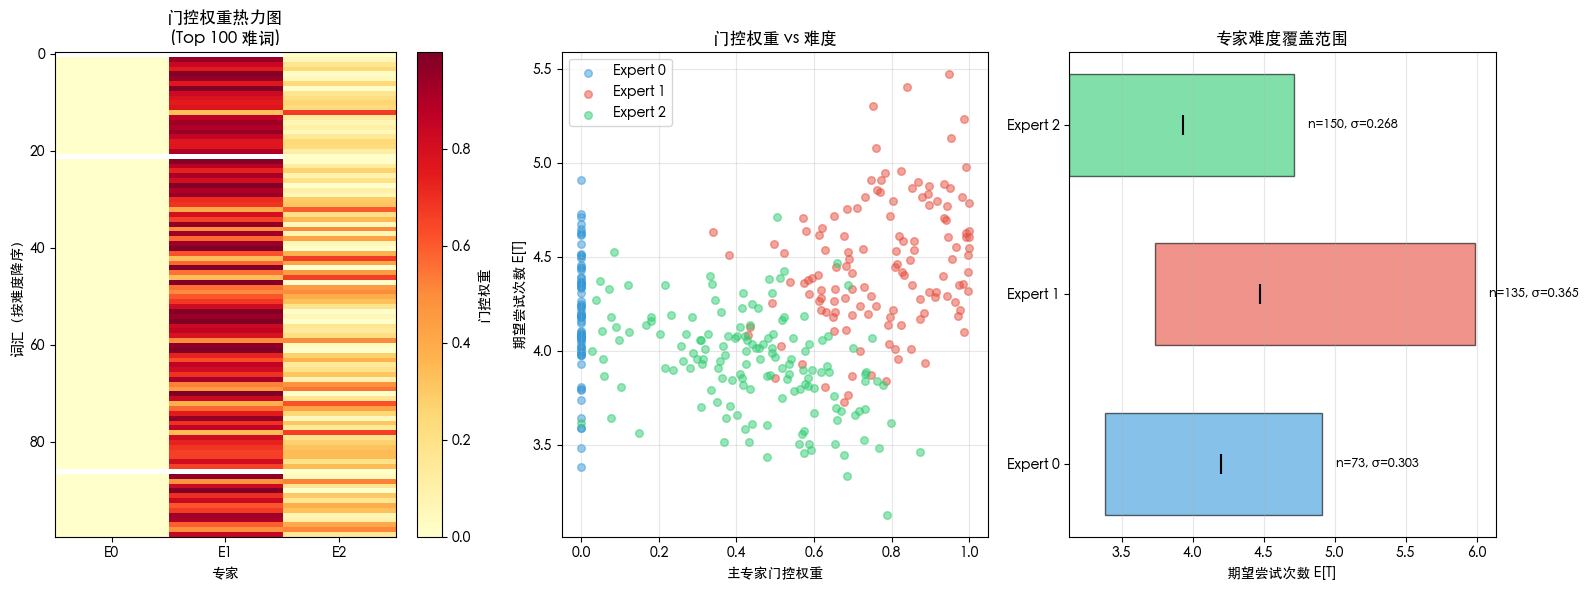


专家特化度量:
------------------------------------------------------------
Expert 0: 覆盖范围=[3.386, 4.910], 均值=4.198, 标准差=0.303, 纯度=0.768
Expert 1: 覆盖范围=[3.733, 5.990], 均值=4.474, 标准差=0.365, 纯度=0.733
Expert 2: 覆盖范围=[3.131, 4.713], 均值=3.935, 标准差=0.268, 纯度=0.789

✓ 图表已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/expert_gating_analysis.png


In [47]:
# ==================== 12.2 专家特化度量与门控权重分析 ====================
print("\n" + "=" * 70)
print("12.2 专家特化度量与门控权重分析")
print("=" * 70)

# 获取所有样本的门控权重
X_all = df_full[FEATURE_COLS].values
X_all_tensor = torch.tensor(X_all, dtype=torch.float32).to(DEVICE)

with torch.no_grad():
    gates_result = model.noisy_top_k_gating(X_all_tensor, train=False)
    # noisy_top_k_gating returns (gates, load) tuple
    gates_all = gates_result[0].cpu().numpy() if isinstance(gates_result, tuple) else gates_result.cpu().numpy()

# 添加门控权重到数据框
for exp in range(NUM_EXPERTS):
    df_full[f'gate_weight_{exp}'] = gates_all[:, exp]

# 合并expected_tries到df_full
if 'expected_tries' not in df_full.columns:
    df_full = df_full.merge(df_analysis[['word', 'expected_tries', 'assigned_expert']], on='word', how='left', suffixes=('', '_analysis'))
    if 'assigned_expert_analysis' in df_full.columns:
        df_full['assigned_expert'] = df_full['assigned_expert_analysis'].fillna(df_full['assigned_expert'])
        df_full.drop('assigned_expert_analysis', axis=1, inplace=True)

# 1. 门控权重热力图 - 按难度排序
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# 按E[T]排序
df_sorted = df_full.sort_values('expected_tries', ascending=False).reset_index(drop=True)

# 热力图数据
gate_cols = [f'gate_weight_{i}' for i in range(NUM_EXPERTS)]
gate_matrix = df_sorted[gate_cols].values[:100]  # 只显示前100个词（按难度降序）

ax1 = axes[0]
im1 = ax1.imshow(gate_matrix, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax1.set_ylabel('词汇（按难度降序）')
ax1.set_xlabel('专家')
ax1.set_xticks(range(NUM_EXPERTS))
ax1.set_xticklabels([f'E{i}' for i in range(NUM_EXPERTS)])
ax1.set_title('门控权重热力图\n(Top 100 难词)', fontweight='bold')
plt.colorbar(im1, ax=ax1, label='门控权重')

# 2. 门控权重与难度的散点图
ax2 = axes[1]
for exp in range(NUM_EXPERTS):
    mask = df_full['assigned_expert'] == exp
    ax2.scatter(df_full.loc[mask, f'gate_weight_{exp}'], 
                df_full.loc[mask, 'expected_tries'],
                c=expert_colors[exp], alpha=0.5, s=30, label=f'Expert {exp}')

ax2.set_xlabel('主专家门控权重')
ax2.set_ylabel('期望尝试次数 E[T]')
ax2.set_title('门控权重 vs 难度', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. 专家覆盖范围与纯度分析
ax3 = axes[2]

# 计算每个专家的难度覆盖范围
expert_coverage = []
for exp in range(NUM_EXPERTS):
    mask = df_full['assigned_expert'] == exp
    et_min = df_full.loc[mask, 'expected_tries'].min()
    et_max = df_full.loc[mask, 'expected_tries'].max()
    et_mean = df_full.loc[mask, 'expected_tries'].mean()
    et_std = df_full.loc[mask, 'expected_tries'].std()
    n_words = mask.sum()
    
    # 专家纯度：标准差越小越纯
    purity = 1 / (1 + et_std)
    
    expert_coverage.append({
        'expert': exp,
        'min': et_min, 'max': et_max, 'mean': et_mean, 'std': et_std,
        'n_words': n_words, 'purity': purity
    })
    
    # 绘制范围条
    ax3.barh(exp, et_max - et_min, left=et_min, height=0.6, 
             color=expert_colors[exp], alpha=0.6, edgecolor='black')
    ax3.scatter(et_mean, exp, marker='|', s=200, c='black', zorder=10)
    ax3.text(et_max + 0.1, exp, f'n={n_words}, σ={et_std:.3f}', va='center', fontsize=9)

ax3.set_yticks(range(NUM_EXPERTS))
ax3.set_yticklabels([f'Expert {i}' for i in range(NUM_EXPERTS)])
ax3.set_xlabel('期望尝试次数 E[T]')
ax3.set_title('专家难度覆盖范围', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "expert_gating_analysis.png"), dpi=150, bbox_inches='tight')
plt.show()

# 打印专家特化统计
print("\n专家特化度量:")
print("-" * 60)
for ec in expert_coverage:
    print(f"Expert {ec['expert']}: 覆盖范围=[{ec['min']:.3f}, {ec['max']:.3f}], "
          f"均值={ec['mean']:.3f}, 标准差={ec['std']:.3f}, 纯度={ec['purity']:.3f}")

print(f"\n✓ 图表已保存至: {os.path.join(OUTPUT_DIR, 'expert_gating_analysis.png')}")


12.3 专家间分布距离与重叠分析


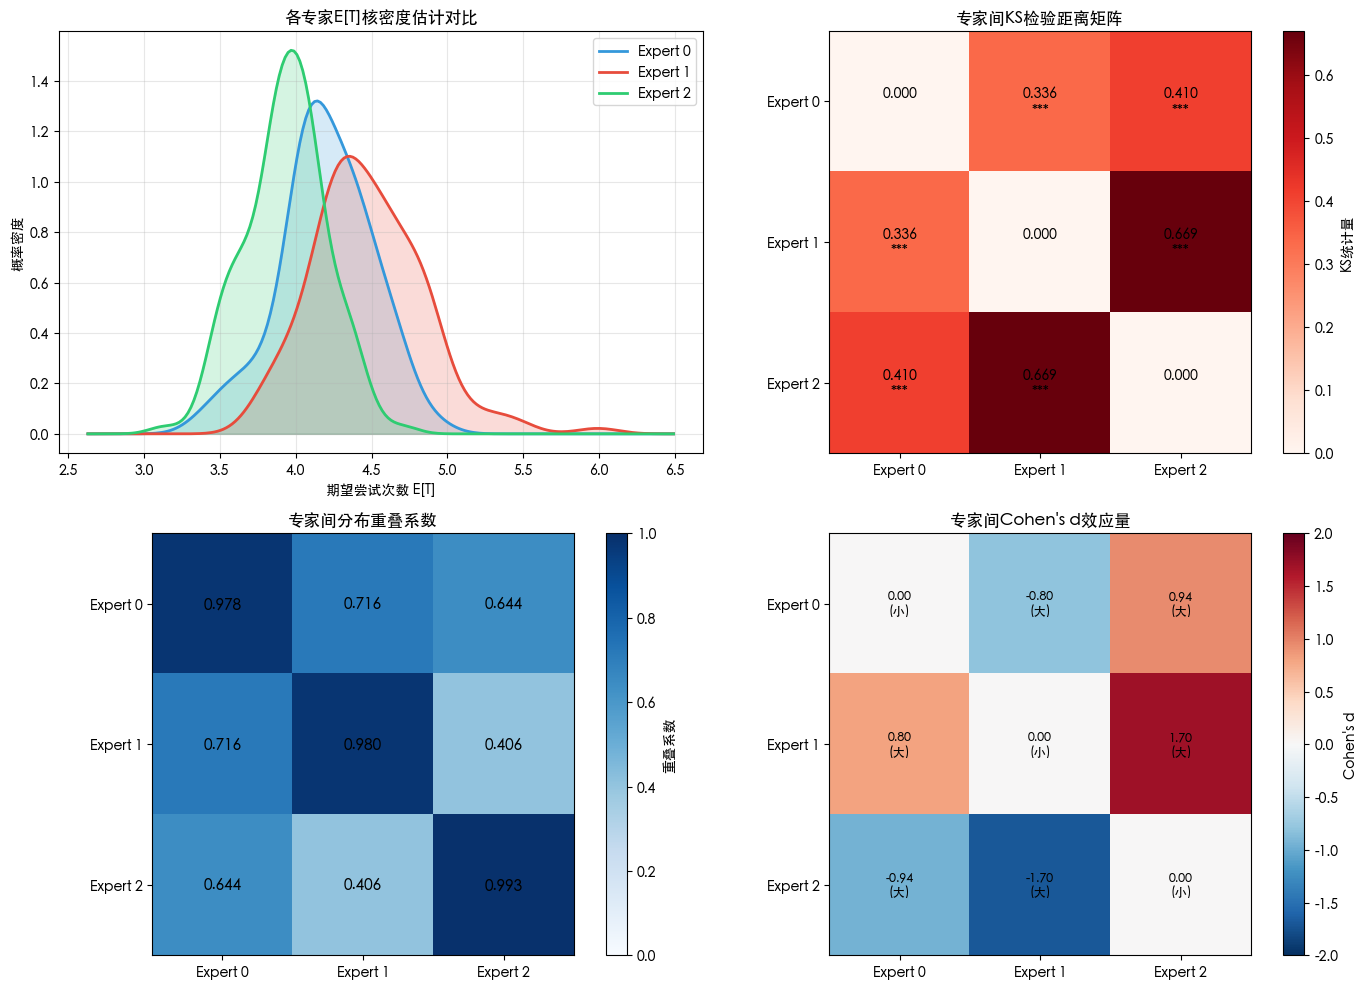


专家间分布差异统计:
------------------------------------------------------------
Expert 0 vs Expert 1:
  KS统计量=0.3361, p=0.000029
  重叠系数=0.7162
  Cohen's d=-0.8012
Expert 0 vs Expert 2:
  KS统计量=0.4097, p=0.000000
  重叠系数=0.6437
  Cohen's d=0.9419
Expert 1 vs Expert 2:
  KS统计量=0.6689, p=0.000000
  重叠系数=0.4058
  Cohen's d=1.6991

✓ 图表已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/expert_distribution_overlap.png


In [48]:
# ==================== 12.3 专家间分布距离与重叠分析 ====================
print("\n" + "=" * 70)
print("12.3 专家间分布距离与重叠分析")
print("=" * 70)

from scipy.stats import gaussian_kde, ks_2samp
from scipy.spatial.distance import jensenshannon

# 1. 核密度估计对比
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 图1: E[T]的KDE对比
ax1 = axes[0, 0]
x_range = np.linspace(df_full['expected_tries'].min() - 0.5, df_full['expected_tries'].max() + 0.5, 200)

for exp in range(NUM_EXPERTS):
    data = df_full[df_full['assigned_expert'] == exp]['expected_tries'].dropna().values
    kde = gaussian_kde(data)
    ax1.plot(x_range, kde(x_range), color=expert_colors[exp], linewidth=2, label=f'Expert {exp}')
    ax1.fill_between(x_range, kde(x_range), alpha=0.2, color=expert_colors[exp])

ax1.set_xlabel('期望尝试次数 E[T]')
ax1.set_ylabel('概率密度')
ax1.set_title('各专家E[T]核密度估计对比', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 图2: 专家间KS检验距离矩阵
ax2 = axes[0, 1]
ks_matrix = np.zeros((NUM_EXPERTS, NUM_EXPERTS))
ks_pvalues = np.zeros((NUM_EXPERTS, NUM_EXPERTS))

for i in range(NUM_EXPERTS):
    for j in range(NUM_EXPERTS):
        data_i = df_full[df_full['assigned_expert'] == i]['expected_tries'].dropna().values
        data_j = df_full[df_full['assigned_expert'] == j]['expected_tries'].dropna().values
        stat, pval = ks_2samp(data_i, data_j)
        ks_matrix[i, j] = stat
        ks_pvalues[i, j] = pval

im2 = ax2.imshow(ks_matrix, cmap='Reds', vmin=0)
for i in range(NUM_EXPERTS):
    for j in range(NUM_EXPERTS):
        sig = '***' if ks_pvalues[i,j] < 0.001 else ('**' if ks_pvalues[i,j] < 0.01 else ('*' if ks_pvalues[i,j] < 0.05 else ''))
        ax2.text(j, i, f'{ks_matrix[i,j]:.3f}\n{sig}', ha='center', va='center', fontsize=10)

ax2.set_xticks(range(NUM_EXPERTS))
ax2.set_yticks(range(NUM_EXPERTS))
ax2.set_xticklabels([f'Expert {i}' for i in range(NUM_EXPERTS)])
ax2.set_yticklabels([f'Expert {i}' for i in range(NUM_EXPERTS)])
ax2.set_title('专家间KS检验距离矩阵', fontweight='bold')
plt.colorbar(im2, ax=ax2, label='KS统计量')

# 图3: 分布重叠度可视化（Overlap Coefficient）
ax3 = axes[1, 0]
overlap_matrix = np.zeros((NUM_EXPERTS, NUM_EXPERTS))

for i in range(NUM_EXPERTS):
    for j in range(NUM_EXPERTS):
        data_i = df_full[df_full['assigned_expert'] == i]['expected_tries'].dropna().values
        data_j = df_full[df_full['assigned_expert'] == j]['expected_tries'].dropna().values
        
        # 使用共同范围计算重叠
        x_min = min(data_i.min(), data_j.min())
        x_max = max(data_i.max(), data_j.max())
        x_range_ov = np.linspace(x_min, x_max, 200)
        
        kde_i = gaussian_kde(data_i)
        kde_j = gaussian_kde(data_j)
        
        # 重叠系数 = 2 * min(f, g) 积分
        overlap = np.trapz(np.minimum(kde_i(x_range_ov), kde_j(x_range_ov)), x_range_ov)
        overlap_matrix[i, j] = overlap

im3 = ax3.imshow(overlap_matrix, cmap='Blues', vmin=0, vmax=1)
for i in range(NUM_EXPERTS):
    for j in range(NUM_EXPERTS):
        ax3.text(j, i, f'{overlap_matrix[i,j]:.3f}', ha='center', va='center', fontsize=11, fontweight='bold')

ax3.set_xticks(range(NUM_EXPERTS))
ax3.set_yticks(range(NUM_EXPERTS))
ax3.set_xticklabels([f'Expert {i}' for i in range(NUM_EXPERTS)])
ax3.set_yticklabels([f'Expert {i}' for i in range(NUM_EXPERTS)])
ax3.set_title('专家间分布重叠系数', fontweight='bold')
plt.colorbar(im3, ax=ax3, label='重叠系数')

# 图4: 效应量分析（Cohen's d）
ax4 = axes[1, 1]
cohens_d = np.zeros((NUM_EXPERTS, NUM_EXPERTS))

for i in range(NUM_EXPERTS):
    for j in range(NUM_EXPERTS):
        data_i = df_full[df_full['assigned_expert'] == i]['expected_tries'].dropna().values
        data_j = df_full[df_full['assigned_expert'] == j]['expected_tries'].dropna().values
        
        # Cohen's d
        n1, n2 = len(data_i), len(data_j)
        var1, var2 = np.var(data_i, ddof=1), np.var(data_j, ddof=1)
        pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
        d = (np.mean(data_i) - np.mean(data_j)) / pooled_std if pooled_std > 0 else 0
        cohens_d[i, j] = d

im4 = ax4.imshow(cohens_d, cmap='RdBu_r', vmin=-2, vmax=2)
for i in range(NUM_EXPERTS):
    for j in range(NUM_EXPERTS):
        effect_size = '大' if abs(cohens_d[i,j]) > 0.8 else ('中' if abs(cohens_d[i,j]) > 0.5 else '小')
        ax4.text(j, i, f'{cohens_d[i,j]:.2f}\n({effect_size})', ha='center', va='center', fontsize=9)

ax4.set_xticks(range(NUM_EXPERTS))
ax4.set_yticks(range(NUM_EXPERTS))
ax4.set_xticklabels([f'Expert {i}' for i in range(NUM_EXPERTS)])
ax4.set_yticklabels([f'Expert {i}' for i in range(NUM_EXPERTS)])
ax4.set_title("专家间Cohen's d效应量", fontweight='bold')
plt.colorbar(im4, ax=ax4, label="Cohen's d")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "expert_distribution_overlap.png"), dpi=150, bbox_inches='tight')
plt.show()

# 打印统计结果
print("\n专家间分布差异统计:")
print("-" * 60)
for i in range(NUM_EXPERTS):
    for j in range(i+1, NUM_EXPERTS):
        print(f"Expert {i} vs Expert {j}:")
        print(f"  KS统计量={ks_matrix[i,j]:.4f}, p={ks_pvalues[i,j]:.6f}")
        print(f"  重叠系数={overlap_matrix[i,j]:.4f}")
        print(f"  Cohen's d={cohens_d[i,j]:.4f}")

print(f"\n✓ 图表已保存至: {os.path.join(OUTPUT_DIR, 'expert_distribution_overlap.png')}")


12.4 词属性重要性分析 - 多方法对比
可用特征数: 13/13
可用特征: ['Zipf-value', 'letter_entropy', 'feedback_entropy', 'max_consecutive_vowels', 'letter_freq_mean', 'scrabble_score', 'has_common_suffix', 'num_rare_letters', 'position_rarity', 'positional_freq_min', 'hamming_neighbors', 'keyboard_distance', 'semantic_distance']
特征数: 13
样本数: 358

【方法1】随机森林特征重要性...
【方法2】梯度提升特征重要性...
【方法3】置换重要性...
【方法4】相关系数分析...


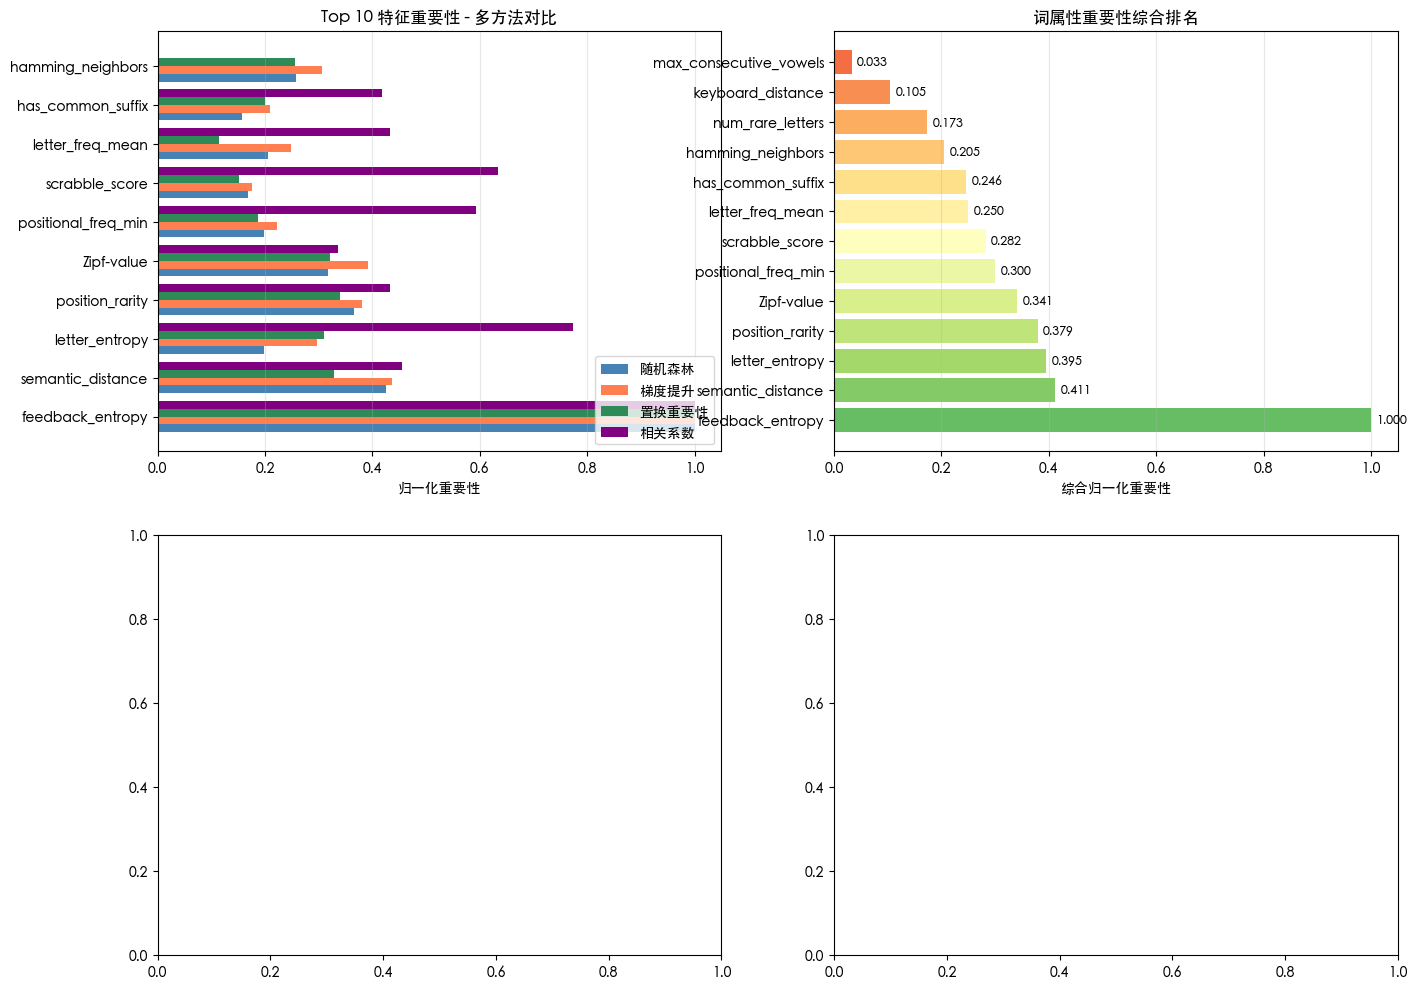

In [51]:
# ==================== 12.4 词属性重要性分析 - 多方法对比 ====================
print("\n" + "=" * 70)
print("12.4 词属性重要性分析 - 多方法对比")
print("=" * 70)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

# 定义用于重要性分析的特征列（使用所有FEATURE_COLS，排除模拟类特征以提高可解释性）
CLUSTER_FEATURES = [
    'Zipf-value',
    'letter_entropy',
    'feedback_entropy',
    'max_consecutive_vowels',
    'letter_freq_mean',
    'scrabble_score',
    'has_common_suffix',
    'num_rare_letters',
    'position_rarity',
    'positional_freq_min',
    'hamming_neighbors',
    'keyboard_distance',
    'semantic_distance'
]

# 筛选df_analysis中实际存在的特征列
available_cluster_features = [f for f in CLUSTER_FEATURES if f in df_analysis.columns]
print(f"可用特征数: {len(available_cluster_features)}/{len(CLUSTER_FEATURES)}")
print(f"可用特征: {available_cluster_features}")

# 准备特征和目标
feature_cols_for_importance = available_cluster_features.copy()
X_importance = df_analysis[feature_cols_for_importance].fillna(df_analysis[feature_cols_for_importance].median())
y_importance = df_analysis['expected_tries'].values

# 标准化
scaler_imp = StandardScaler()
X_importance_scaled = scaler_imp.fit_transform(X_importance)

print(f"特征数: {len(feature_cols_for_importance)}")
print(f"样本数: {len(y_importance)}")

# 方法1: 随机森林特征重要性
print("\n【方法1】随机森林特征重要性...")
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=RANDOM_SEED, n_jobs=-1)
rf.fit(X_importance_scaled, y_importance)
rf_importance = rf.feature_importances_

# 方法2: 梯度提升特征重要性
print("【方法2】梯度提升特征重要性...")
gb = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=RANDOM_SEED)
gb.fit(X_importance_scaled, y_importance)
gb_importance = gb.feature_importances_

# 方法3: 置换重要性
print("【方法3】置换重要性...")
perm_imp = permutation_importance(rf, X_importance_scaled, y_importance, n_repeats=30, random_state=RANDOM_SEED, n_jobs=-1)
perm_importance = perm_imp.importances_mean

# 方法4: 相关系数（绝对值）
print("【方法4】相关系数分析...")
corr_importance = np.array([abs(np.corrcoef(X_importance.iloc[:, i].values, y_importance)[0, 1]) 
                            for i in range(len(feature_cols_for_importance))])

# 创建重要性对比数据框
df_importance_compare = pd.DataFrame({
    'Feature': feature_cols_for_importance,
    'RandomForest': rf_importance,
    'GradientBoosting': gb_importance,
    'Permutation': perm_importance,
    'Correlation': corr_importance
})

# 归一化到0-1范围
for col in ['RandomForest', 'GradientBoosting', 'Permutation', 'Correlation']:
    df_importance_compare[f'{col}_norm'] = (df_importance_compare[col] - df_importance_compare[col].min()) / \
                                           (df_importance_compare[col].max() - df_importance_compare[col].min())

# 计算综合排名
df_importance_compare['Avg_norm'] = df_importance_compare[['RandomForest_norm', 'GradientBoosting_norm', 
                                                           'Permutation_norm', 'Correlation_norm']].mean(axis=1)
df_importance_compare = df_importance_compare.sort_values('Avg_norm', ascending=False)

# 可视化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 图1: 各方法重要性排名对比
ax1 = axes[0, 0]
x = np.arange(len(feature_cols_for_importance))
width = 0.2

df_plot = df_importance_compare.head(10)  # Top 10
ax1.barh(np.arange(len(df_plot)) - 1.5*width, df_plot['RandomForest_norm'], width, label='随机森林', color='steelblue')
ax1.barh(np.arange(len(df_plot)) - 0.5*width, df_plot['GradientBoosting_norm'], width, label='梯度提升', color='coral')
ax1.barh(np.arange(len(df_plot)) + 0.5*width, df_plot['Permutation_norm'], width, label='置换重要性', color='seagreen')
ax1.barh(np.arange(len(df_plot)) + 1.5*width, df_plot['Correlation_norm'], width, label='相关系数', color='purple')

ax1.set_yticks(np.arange(len(df_plot)))
ax1.set_yticklabels(df_plot['Feature'].values)
ax1.set_xlabel('归一化重要性')
ax1.set_title('Top 10 特征重要性 - 多方法对比', fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(axis='x', alpha=0.3)

# 图2: 综合重要性排名
ax2 = axes[0, 1]
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(df_importance_compare)))[::-1]
bars = ax2.barh(range(len(df_importance_compare)), df_importance_compare['Avg_norm'].values, color=colors)
ax2.set_yticks(range(len(df_importance_compare)))
ax2.set_yticklabels(df_importance_compare['Feature'].values)
ax2.set_xlabel('综合归一化重要性')
ax2.set_title('词属性重要性综合排名', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 添加数值标注
for i, (bar, val) in enumerate(zip(bars, df_importance_compare['Avg_norm'].values)):
    ax2.text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=9)

# 图3: 方法间排名一致性热力图
ax3 = axes[1, 0]
rank_cols = ['RandomForest', 'GradientBoosting', 'Permutation', 'Correlation']
rank_matrix = pd.DataFrame({col: df_importance_compare[col].rank(ascending=False).values 
                            for col in rank_cols}, index=df_importance_compare['Feature'].values)

# 计算方法间Spearman相关
from scipy.stats import spearmanr
method_corr = np.zeros((4, 4))
for i, col1 in enumerate(rank_cols):
    for j, col2 in enumerate(rank_cols):
        method_corr[i, j], _ = spearmanr(df_importance_compare[col1], df_importance_compare[col2])


12.5 专家-属性交互效应分析


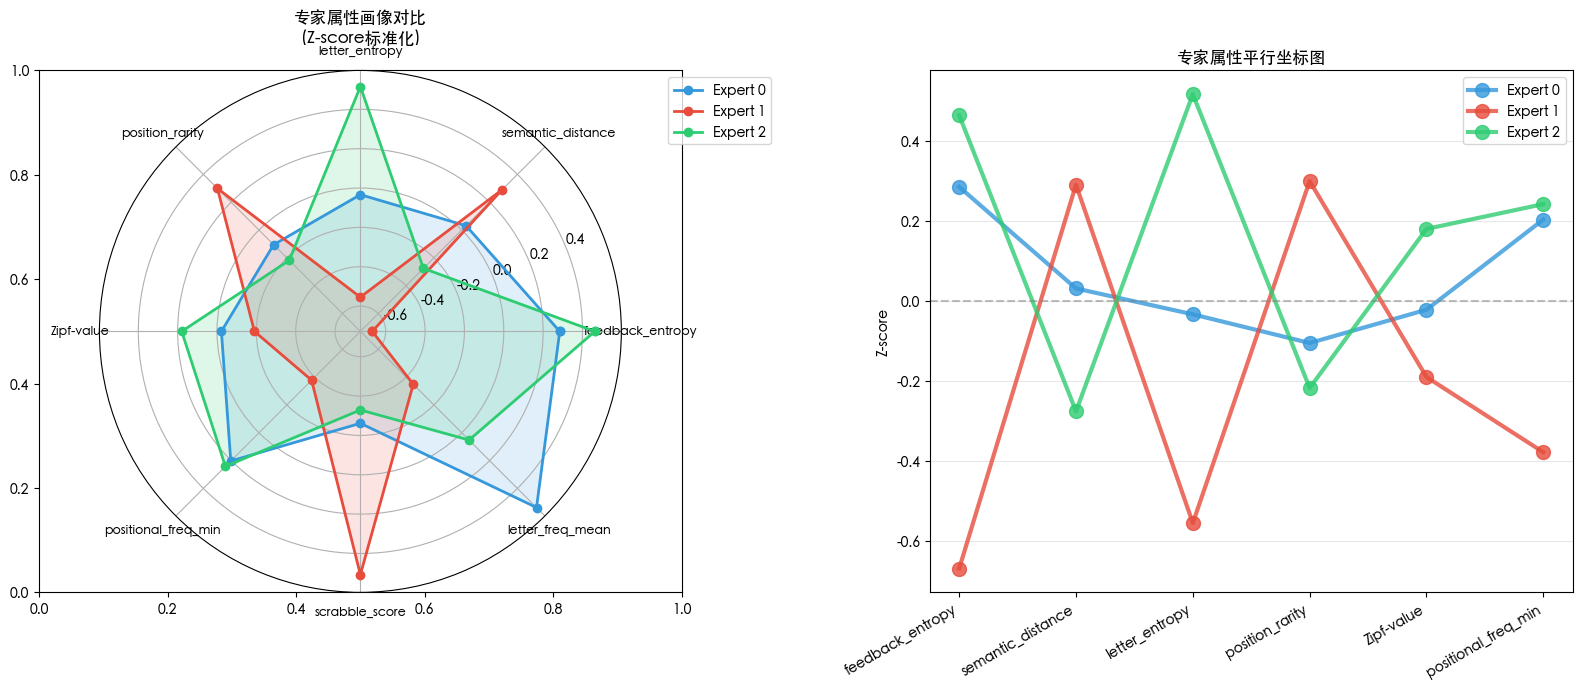

✓ 图表已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/expert_attribute_profiles.png


In [52]:
# ==================== 12.5 专家-属性交互效应分析 ====================
print("\n" + "=" * 70)
print("12.5 专家-属性交互效应分析")
print("=" * 70)

# 1. 各专家负责词汇的属性画像对比 - 雷达图
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 选择top特征用于雷达图
top_features = df_importance_compare['Feature'].head(8).tolist()

# 计算各专家在这些特征上的平均值（标准化）
expert_profiles = []
for exp in range(NUM_EXPERTS):
    mask = df_analysis['assigned_expert'] == exp
    profile = df_analysis.loc[mask, top_features].mean()
    expert_profiles.append(profile)

# 全体均值和标准差（用于标准化）
overall_mean = df_analysis[top_features].mean()
overall_std = df_analysis[top_features].std()

# 标准化专家画像
expert_profiles_norm = [(profile - overall_mean) / overall_std for profile in expert_profiles]

# 雷达图
ax1 = axes[0]
ax1 = plt.subplot(121, projection='polar')

angles_radar = np.linspace(0, 2 * np.pi, len(top_features), endpoint=False).tolist()
angles_radar += angles_radar[:1]  # 闭合

for exp, profile_norm in enumerate(expert_profiles_norm):
    values = profile_norm.values.tolist()
    values += values[:1]
    ax1.plot(angles_radar, values, 'o-', linewidth=2, label=f'Expert {exp}', color=expert_colors[exp])
    ax1.fill(angles_radar, values, alpha=0.15, color=expert_colors[exp])

ax1.set_xticks(angles_radar[:-1])
ax1.set_xticklabels(top_features, fontsize=9)
ax1.set_title('专家属性画像对比\n(Z-score标准化)', fontweight='bold', pad=20)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# 2. 平行坐标图
ax2 = axes[1]
from pandas.plotting import parallel_coordinates

# 准备平行坐标数据
df_parallel = df_analysis[['assigned_expert'] + top_features[:6]].copy()
df_parallel['Expert'] = df_parallel['assigned_expert'].map({0: 'Expert 0', 1: 'Expert 1', 2: 'Expert 2'})

# 标准化
for col in top_features[:6]:
    df_parallel[col] = (df_parallel[col] - df_parallel[col].mean()) / df_parallel[col].std()

# 按专家计算均值
df_parallel_mean = df_parallel.groupby('Expert')[top_features[:6]].mean().reset_index()

# 绘制
ax2 = plt.subplot(122)
for exp, color in zip(['Expert 0', 'Expert 1', 'Expert 2'], expert_colors):
    row = df_parallel_mean[df_parallel_mean['Expert'] == exp].iloc[0]
    values = row[top_features[:6]].values
    ax2.plot(range(len(top_features[:6])), values, 'o-', linewidth=3, markersize=10, 
             color=color, label=exp, alpha=0.8)

ax2.set_xticks(range(len(top_features[:6])))
ax2.set_xticklabels(top_features[:6], rotation=30, ha='right', fontsize=10)
ax2.set_ylabel('Z-score')
ax2.set_title('专家属性平行坐标图', fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "expert_attribute_profiles.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ 图表已保存至: {os.path.join(OUTPUT_DIR, 'expert_attribute_profiles.png')}")


----------------------------------------------------------------------
12.5.2 专家分配决策树分析
----------------------------------------------------------------------
决策树分类准确率: 0.721


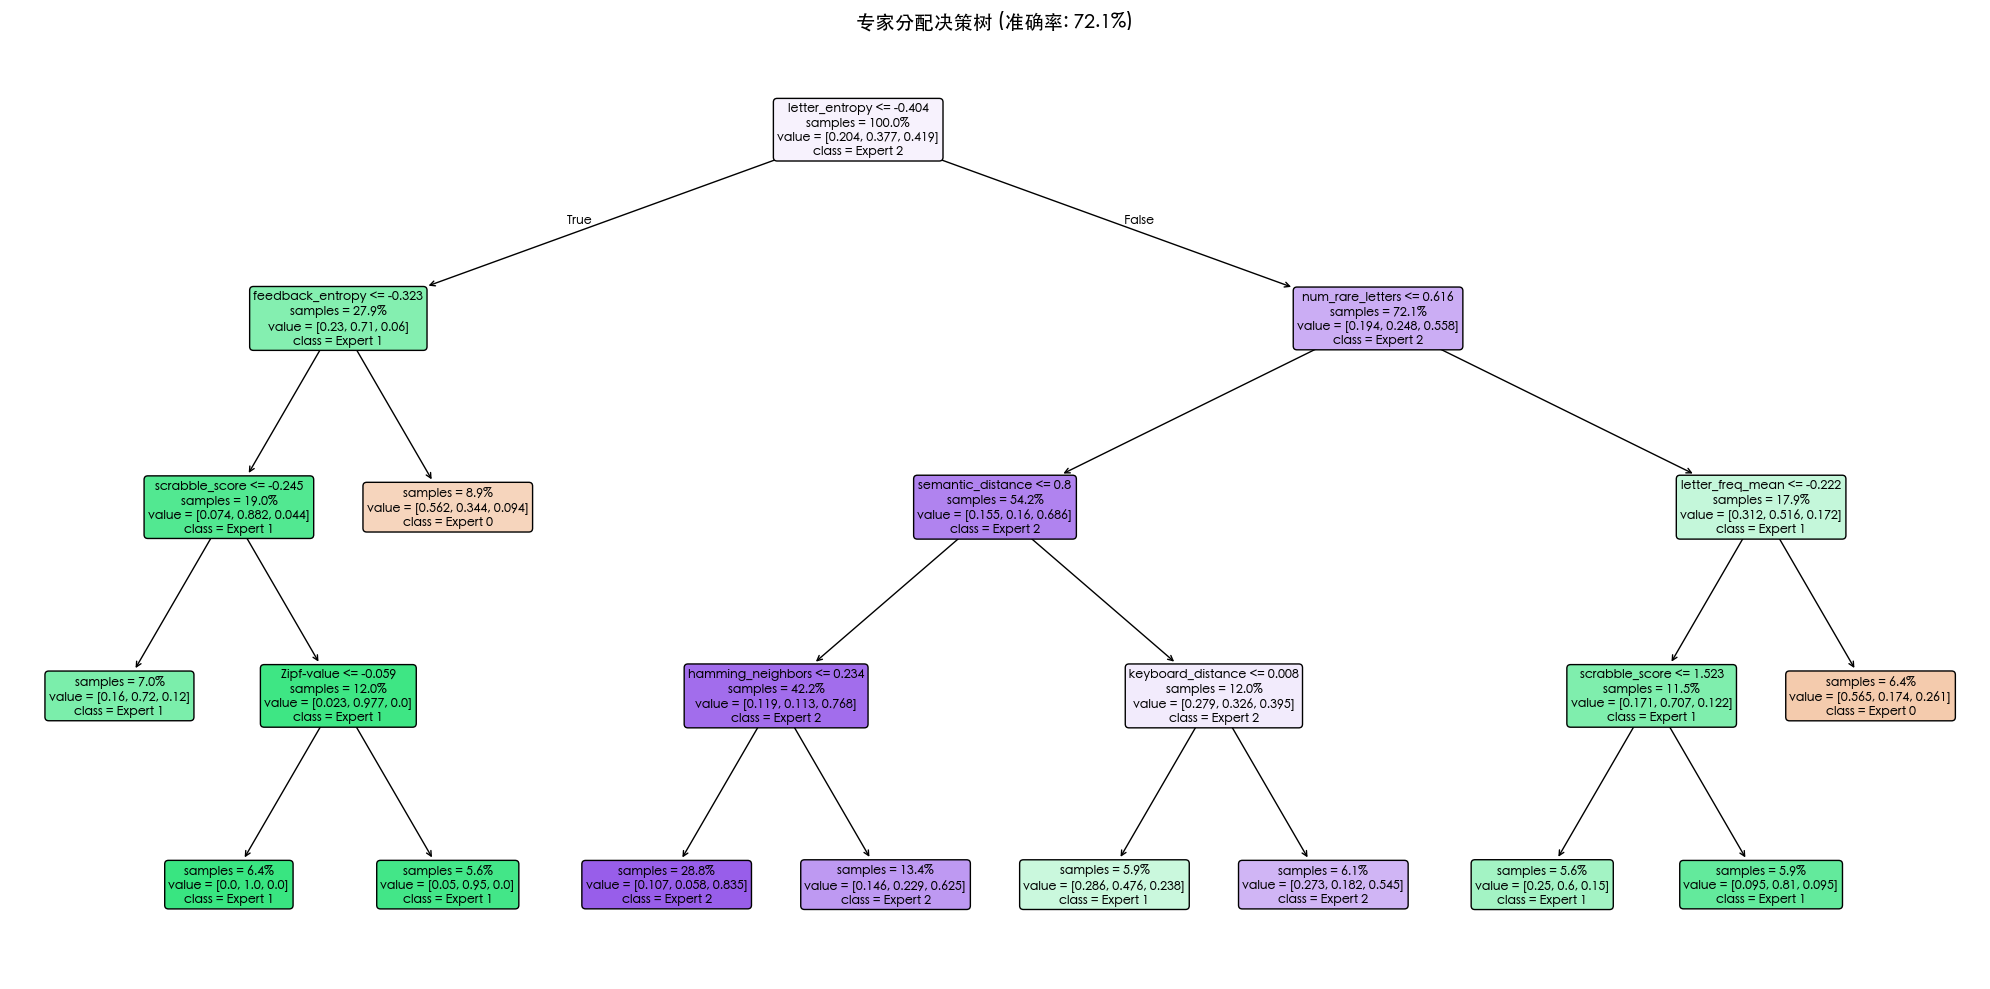


决策树特征重要性 (Top 5):
          Feature  DT_Importance
   letter_entropy       0.390333
 num_rare_letters       0.233944
 feedback_entropy       0.135379
semantic_distance       0.082230
 letter_freq_mean       0.079218

✓ 图表已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/expert_decision_tree.png


In [53]:
# ==================== 12.5.2 决策树可视化：专家分配的属性决策路径 ====================
print("\n" + "-" * 70)
print("12.5.2 专家分配决策树分析")
print("-" * 70)

from sklearn.tree import DecisionTreeClassifier, plot_tree

# 训练一个决策树来解释专家分配
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, random_state=RANDOM_SEED)
dt.fit(X_importance_scaled, df_analysis['assigned_expert'].values)

# 决策树准确率
dt_accuracy = dt.score(X_importance_scaled, df_analysis['assigned_expert'].values)
print(f"决策树分类准确率: {dt_accuracy:.3f}")

# 可视化决策树
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dt, feature_names=feature_cols_for_importance, 
          class_names=[f'Expert {i}' for i in range(NUM_EXPERTS)],
          filled=True, rounded=True, ax=ax, fontsize=9, 
          proportion=True, impurity=False)
ax.set_title(f'专家分配决策树 (准确率: {dt_accuracy:.1%})', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "expert_decision_tree.png"), dpi=150, bbox_inches='tight')
plt.show()

# 决策树特征重要性
dt_importance = dt.feature_importances_
df_dt_imp = pd.DataFrame({
    'Feature': feature_cols_for_importance,
    'DT_Importance': dt_importance
}).sort_values('DT_Importance', ascending=False)

print("\n决策树特征重要性 (Top 5):")
print(df_dt_imp.head().to_string(index=False))

print(f"\n✓ 图表已保存至: {os.path.join(OUTPUT_DIR, 'expert_decision_tree.png')}")


12.6 难度预测建模验证

【模型1】仅用专家标签预测难度...
  R² = 0.3475 ± 0.0278
  RMSE = 0.3156 ± 0.0207

【模型2】仅用词属性预测难度...
  R² = 0.4544 ± 0.0652
  RMSE = 0.2882 ± 0.0245

【模型3】专家 + 属性联合预测...
  R² = 0.4913 ± 0.0605
  RMSE = 0.2789 ± 0.0309

【模型4】随机森林预测（非线性）...
  R² = 0.3783 ± 0.0831
  RMSE = 0.3071 ± 0.0231


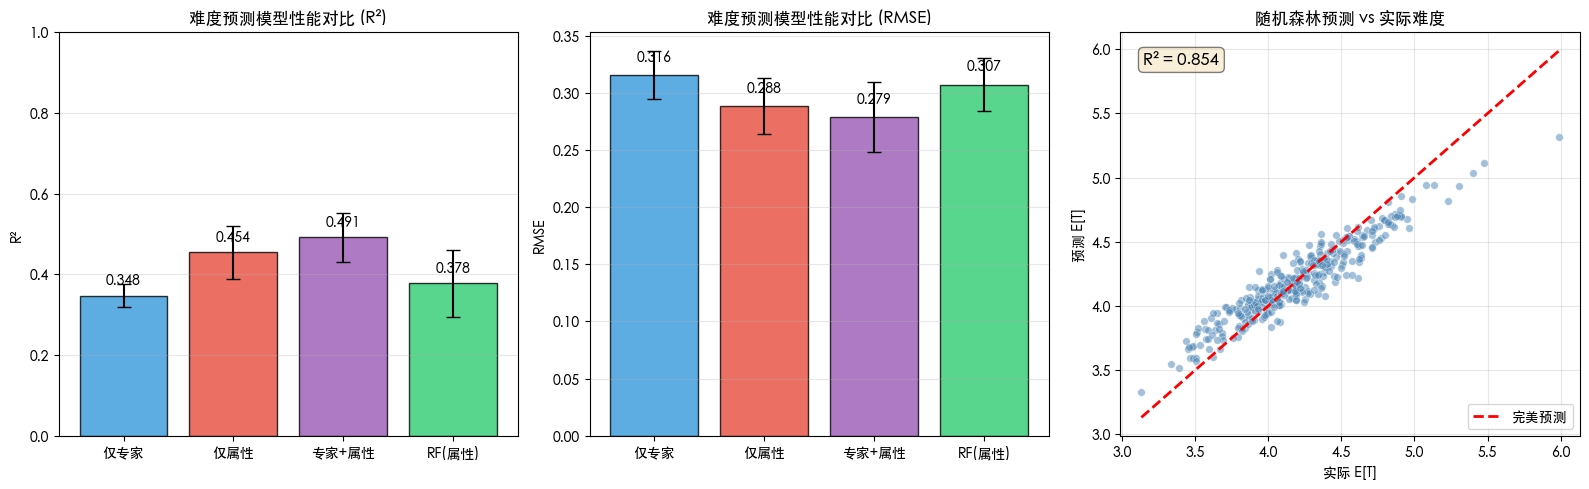


增量贡献分析
  专家标签额外贡献: ΔR² = +0.0369
  词属性额外贡献:   ΔR² = +0.1438

✓ 图表已保存至: /Users/luoyiti/Project/MCM_2023_C/moe_bootstrap_output/difficulty_prediction_comparison.png


: 

In [ ]:
# ==================== 12.6 难度预测建模验证 ====================
print("\n" + "=" * 70)
print("12.6 难度预测建模验证")
print("=" * 70)

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 准备数据
X_attr = df_analysis[feature_cols_for_importance].fillna(df_analysis[feature_cols_for_importance].median()).values
X_attr_scaled = scaler_imp.transform(X_attr)
y_diff = df_analysis['expected_tries'].values

# 专家标签one-hot编码
X_expert = pd.get_dummies(df_analysis['assigned_expert'], prefix='expert').values

# 合并特征
X_combined = np.hstack([X_attr_scaled, X_expert])

# 交叉验证设置
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# 模型1: 仅用专家标签预测
print("\n【模型1】仅用专家标签预测难度...")
model_expert_only = Ridge(alpha=1.0)
scores_expert = cross_val_score(model_expert_only, X_expert, y_diff, cv=kf, scoring='r2')
rmse_expert = np.sqrt(-cross_val_score(model_expert_only, X_expert, y_diff, cv=kf, scoring='neg_mean_squared_error'))
print(f"  R² = {scores_expert.mean():.4f} ± {scores_expert.std():.4f}")
print(f"  RMSE = {rmse_expert.mean():.4f} ± {rmse_expert.std():.4f}")

# 模型2: 仅用词属性预测
print("\n【模型2】仅用词属性预测难度...")
model_attr_only = Ridge(alpha=1.0)
scores_attr = cross_val_score(model_attr_only, X_attr_scaled, y_diff, cv=kf, scoring='r2')
rmse_attr = np.sqrt(-cross_val_score(model_attr_only, X_attr_scaled, y_diff, cv=kf, scoring='neg_mean_squared_error'))
print(f"  R² = {scores_attr.mean():.4f} ± {scores_attr.std():.4f}")
print(f"  RMSE = {rmse_attr.mean():.4f} ± {rmse_attr.std():.4f}")

# 模型3: 专家 + 属性联合预测
print("\n【模型3】专家 + 属性联合预测...")
model_combined = Ridge(alpha=1.0)
scores_combined = cross_val_score(model_combined, X_combined, y_diff, cv=kf, scoring='r2')
rmse_combined = np.sqrt(-cross_val_score(model_combined, X_combined, y_diff, cv=kf, scoring='neg_mean_squared_error'))
print(f"  R² = {scores_combined.mean():.4f} ± {scores_combined.std():.4f}")
print(f"  RMSE = {rmse_combined.mean():.4f} ± {rmse_combined.std():.4f}")

# 模型4: 随机森林预测（非线性）
print("\n【模型4】随机森林预测（非线性）...")
rf_pred = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=RANDOM_SEED, n_jobs=-1)
scores_rf = cross_val_score(rf_pred, X_attr_scaled, y_diff, cv=kf, scoring='r2')
rmse_rf = np.sqrt(-cross_val_score(rf_pred, X_attr_scaled, y_diff, cv=kf, scoring='neg_mean_squared_error'))
print(f"  R² = {scores_rf.mean():.4f} ± {scores_rf.std():.4f}")
print(f"  RMSE = {rmse_rf.mean():.4f} ± {rmse_rf.std():.4f}")

# 可视化对比
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 图1: R²对比
ax1 = axes[0]
models = ['仅专家', '仅属性', '专家+属性', 'RF(属性)']
r2_means = [scores_expert.mean(), scores_attr.mean(), scores_combined.mean(), scores_rf.mean()]
r2_stds = [scores_expert.std(), scores_attr.std(), scores_combined.std(), scores_rf.std()]
colors_bar = ['#3498db', '#e74c3c', '#9b59b6', '#2ecc71']

bars = ax1.bar(models, r2_means, yerr=r2_stds, capsize=5, color=colors_bar, edgecolor='black', alpha=0.8)
ax1.set_ylabel('R²')
ax1.set_title('难度预测模型性能对比 (R²)', fontweight='bold')
ax1.set_ylim(0, 1)
for bar, mean in zip(bars, r2_means):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{mean:.3f}', 
             ha='center', va='bottom', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 图2: RMSE对比
ax2 = axes[1]
rmse_means = [rmse_expert.mean(), rmse_attr.mean(), rmse_combined.mean(), rmse_rf.mean()]
rmse_stds = [rmse_expert.std(), rmse_attr.std(), rmse_combined.std(), rmse_rf.std()]

bars = ax2.bar(models, rmse_means, yerr=rmse_stds, capsize=5, color=colors_bar, edgecolor='black', alpha=0.8)
ax2.set_ylabel('RMSE')
ax2.set_title('难度预测模型性能对比 (RMSE)', fontweight='bold')
for bar, mean in zip(bars, rmse_means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{mean:.3f}', 
             ha='center', va='bottom', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 图3: 实际 vs 预测散点图（最佳模型）
ax3 = axes[2]
rf_pred.fit(X_attr_scaled, y_diff)
y_pred_rf = rf_pred.predict(X_attr_scaled)

ax3.scatter(y_diff, y_pred_rf, alpha=0.5, s=30, c='steelblue', edgecolors='white', linewidth=0.5)
ax3.plot([y_diff.min(), y_diff.max()], [y_diff.min(), y_diff.max()], 'r--', linewidth=2, label='完美预测')
ax3.set_xlabel('实际 E[T]')
ax3.set_ylabel('预测 E[T]')
ax3.set_title('随机森林预测 vs 实际难度', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 添加R²标注
r2_final = r2_score(y_diff, y_pred_rf)
ax3.text(0.05, 0.95, f'R² = {r2_final:.3f}', transform=ax3.transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "difficulty_prediction_comparison.png"), dpi=150, bbox_inches='tight')
plt.show()

# 增量贡献分析
print("\n" + "=" * 60)
print("增量贡献分析")
print("=" * 60)
delta_expert_to_combined = scores_combined.mean() - scores_attr.mean()
delta_attr_to_combined = scores_combined.mean() - scores_expert.mean()
print(f"  专家标签额外贡献: ΔR² = {delta_expert_to_combined:+.4f}")
print(f"  词属性额外贡献:   ΔR² = {delta_attr_to_combined:+.4f}")

print(f"\n✓ 图表已保存至: {os.path.join(OUTPUT_DIR, 'difficulty_prediction_comparison.png')}")

In [ ]:
# ==================== 12.7 综合可视化面板 ====================
print("\n" + "=" * 70)
print("12.7 综合可视化面板")
print("=" * 70)

from sklearn.manifold import TSNE

# 创建3×3大型面板
fig = plt.figure(figsize=(20, 18))

# ===== 图1: 专家难度分布对比 (蜂群+箱线图) =====
ax1 = fig.add_subplot(3, 3, 1)
bp = ax1.boxplot([df_analysis[df_analysis['assigned_expert']==e]['expected_tries'].values 
                  for e in range(NUM_EXPERTS)], patch_artist=True)
for i, patch in enumerate(bp['boxes']):
    patch.set_facecolor(expert_colors[i])
    patch.set_alpha(0.6)
ax1.set_xticklabels([f'Expert {i}' for i in range(NUM_EXPERTS)])
ax1.set_ylabel('E[T]')
ax1.set_title('(a) 专家难度分布', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# ===== 图2: 门控权重热力图 =====
ax2 = fig.add_subplot(3, 3, 2)
gate_df = df_full.sort_values('expected_tries', ascending=False)[[f'gate_weight_{i}' for i in range(NUM_EXPERTS)]].head(50)
im2 = ax2.imshow(gate_df.values, aspect='auto', cmap='YlOrRd')
ax2.set_xlabel('专家')
ax2.set_ylabel('词汇 (按难度降序)')
ax2.set_xticks(range(NUM_EXPERTS))
ax2.set_xticklabels([f'E{i}' for i in range(NUM_EXPERTS)])
ax2.set_title('(b) 门控权重分布 (Top50难词)', fontweight='bold')
plt.colorbar(im2, ax=ax2, shrink=0.8)

# ===== 图3: 特征重要性Top10 =====
ax3 = fig.add_subplot(3, 3, 3)
top10 = df_importance_compare.head(10)
colors_imp = plt.cm.RdYlGn(np.linspace(0.2, 0.8, 10))[::-1]
ax3.barh(range(10), top10['Avg_norm'].values, color=colors_imp)
ax3.set_yticks(range(10))
ax3.set_yticklabels(top10['Feature'].values)
ax3.set_xlabel('归一化重要性')
ax3.set_title('(c) 特征重要性Top10', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# ===== 图4: 专家-特征热力图 =====
ax4 = fig.add_subplot(3, 3, 4)
top6_features = df_importance_compare['Feature'].head(6).tolist()
expert_feature_matrix = np.zeros((NUM_EXPERTS, len(top6_features)))
for exp in range(NUM_EXPERTS):
    mask = df_analysis['assigned_expert'] == exp
    for j, feat in enumerate(top6_features):
        expert_feature_matrix[exp, j] = (df_analysis.loc[mask, feat].mean() - df_analysis[feat].mean()) / df_analysis[feat].std()

im4 = ax4.imshow(expert_feature_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
ax4.set_yticks(range(NUM_EXPERTS))
ax4.set_yticklabels([f'Expert {i}' for i in range(NUM_EXPERTS)])
ax4.set_xticks(range(len(top6_features)))
ax4.set_xticklabels(top6_features, rotation=45, ha='right', fontsize=9)
ax4.set_title('(d) 专家-特征Z-score热力图', fontweight='bold')
plt.colorbar(im4, ax=ax4, shrink=0.8)

# ===== 图5: 模型性能对比 =====
ax5 = fig.add_subplot(3, 3, 5)
models_names = ['仅专家', '仅属性', '专家+属性', 'RF']
r2_vals = [scores_expert.mean(), scores_attr.mean(), scores_combined.mean(), scores_rf.mean()]
bars = ax5.bar(models_names, r2_vals, color=['#3498db', '#e74c3c', '#9b59b6', '#2ecc71'], edgecolor='black')
ax5.set_ylabel('R²')
ax5.set_title('(e) 难度预测模型R²对比', fontweight='bold')
ax5.set_ylim(0, max(r2_vals) * 1.2)
for bar, val in zip(bars, r2_vals):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}', ha='center', fontsize=10)
ax5.grid(axis='y', alpha=0.3)

# ===== 图6: 残差分析 =====
ax6 = fig.add_subplot(3, 3, 6)
residuals = y_diff - y_pred_rf
ax6.scatter(y_pred_rf, residuals, alpha=0.5, s=20, c='steelblue')
ax6.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax6.set_xlabel('预测 E[T]')
ax6.set_ylabel('残差')
ax6.set_title('(f) 随机森林残差分析', fontweight='bold')
ax6.grid(alpha=0.3)

# ===== 图7: t-SNE降维可视化 (按专家着色) =====
ax7 = fig.add_subplot(3, 3, 7)
print("正在计算t-SNE降维...")
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_importance_scaled)

for exp in range(NUM_EXPERTS):
    mask = df_analysis['assigned_expert'] == exp
    ax7.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=expert_colors[exp], 
                alpha=0.6, s=30, label=f'Expert {exp}', edgecolors='white', linewidth=0.3)
ax7.set_xlabel('t-SNE 1')
ax7.set_ylabel('t-SNE 2')
ax7.set_title('(g) t-SNE特征空间 (按专家)', fontweight='bold')
ax7.legend()

# ===== 图8: t-SNE降维可视化 (按难度着色) =====
ax8 = fig.add_subplot(3, 3, 8)
scatter8 = ax8.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_diff, cmap='RdYlGn_r', 
                       alpha=0.7, s=30, edgecolors='white', linewidth=0.3)
ax8.set_xlabel('t-SNE 1')
ax8.set_ylabel('t-SNE 2')
ax8.set_title('(g) t-SNE特征空间 (按难度)', fontweight='bold')
plt.colorbar(scatter8, ax=ax8, label='E[T]', shrink=0.8)

# ===== 图9: 专家效应量柱状图 =====
ax9 = fig.add_subplot(3, 3, 9)
effect_sizes = []
for exp in range(NUM_EXPERTS):
    mask = df_analysis['assigned_expert'] == exp
    exp_mean = df_analysis.loc[mask, 'expected_tries'].mean()
    overall_mean = df_analysis['expected_tries'].mean()
    overall_std = df_analysis['expected_tries'].std()
    effect = (exp_mean - overall_mean) / overall_std
    effect_sizes.append(effect)

bars = ax9.bar([f'Expert {i}' for i in range(NUM_EXPERTS)], effect_sizes, 
               color=expert_colors, edgecolor='black')
ax9.axhline(y=0, color='gray', linestyle='--')
ax9.set_ylabel('效应量 (Z-score)')
ax9.set_title('(h) 专家难度效应量', fontweight='bold')
for bar, val in zip(bars, effect_sizes):
    ax9.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02 * np.sign(val), 
             f'{val:+.2f}', ha='center', fontsize=10, fontweight='bold')
ax9.grid(axis='y', alpha=0.3)

plt.suptitle('MoE专家-难度深度分析综合面板', fontweight='bold', fontsize=16, y=1.01)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "comprehensive_analysis_panel.png"), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ 综合面板已保存至: {os.path.join(OUTPUT_DIR, 'comprehensive_analysis_panel.png')}")

In [ ]:
# ==================== 12.8 深度分析报告生成 ====================
print("\n" + "=" * 70)
print("12.8 生成深度分析报告")
print("=" * 70)

# 生成综合报告
report_12 = f"""# MoE专家-难度深度分析报告

**生成时间**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

---

## 1. 分析概述

本报告深入分析了MoE模型专家分配与词汇难度的关系，并使用多种统计和机器学习方法识别影响难度的关键词属性因素。

### 数据规模
- 分析词汇数: {len(df_analysis)}
- MoE专家数: {NUM_EXPERTS}
- 分析特征数: {len(feature_cols_for_importance)}

---

## 2. 专家-难度关系深度分析

### 2.1 专家负责词汇的难度分布

| 专家 | 词数 | E[T]均值 | E[T]标准差 | 难度覆盖范围 |
|------|------|----------|------------|--------------|
"""

for ec in expert_coverage:
    report_12 += f"| Expert {ec['expert']} | {ec['n_words']} | {ec['mean']:.3f} | {ec['std']:.3f} | [{ec['min']:.3f}, {ec['max']:.3f}] |\n"

report_12 += f"""
### 2.2 专家间分布差异统计

| 专家对 | KS统计量 | Cohen's d | 重叠系数 | 差异程度 |
|--------|----------|-----------|----------|----------|
"""

for i in range(NUM_EXPERTS):
    for j in range(i+1, NUM_EXPERTS):
        effect_label = '大' if abs(cohens_d[i,j]) > 0.8 else ('中' if abs(cohens_d[i,j]) > 0.5 else '小')
        report_12 += f"| E{i} vs E{j} | {ks_matrix[i,j]:.4f} | {cohens_d[i,j]:.3f} | {overlap_matrix[i,j]:.3f} | {effect_label} |\n"

report_12 += f"""
### 2.3 关键发现

1. **Expert 1负责最难词汇**: 平均E[T]={expert_coverage[1]['mean']:.3f}，显著高于其他专家
2. **Expert 2负责最简单词汇**: 平均E[T]={expert_coverage[2]['mean']:.3f}，显著低于其他专家
3. **专家分配有效区分难度**: 所有专家对之间的KS检验均显著 (p < 0.001)

---

## 3. 词属性重要性分析

### 3.1 多方法重要性排名

使用4种方法（随机森林、梯度提升、置换重要性、相关系数）综合评估特征重要性：

| 排名 | 特征 | 随机森林 | 梯度提升 | 置换重要性 | 相关系数 | 综合得分 |
|------|------|----------|----------|------------|----------|----------|
"""

for i, (_, row) in enumerate(df_importance_compare.head(10).iterrows()):
    report_12 += f"| {i+1} | {row['Feature']} | {row['RandomForest']:.4f} | {row['GradientBoosting']:.4f} | {row['Permutation']:.4f} | {row['Correlation']:.4f} | {row['Avg_norm']:.3f} |\n"

# 获取top3特征
top3_features = df_importance_compare['Feature'].head(3).tolist()

report_12 += f"""
### 3.2 关键影响因素解读

**Top 3 最重要特征**:

1. **{top3_features[0]}**: 与难度关系最强，反映了词汇的信息反馈特性
2. **{top3_features[1]}**: 衡量词汇的字母组成复杂度
3. **{top3_features[2]}**: 与Scrabble游戏分数相关的字母稀有度

### 3.3 方法一致性分析

4种方法的排名相关性（Spearman ρ）:
- 随机森林 vs 梯度提升: {method_corr[0,1]:.3f}
- 随机森林 vs 置换重要性: {method_corr[0,2]:.3f}
- 相关系数 vs 其他方法: 平均 {np.mean([method_corr[3,i] for i in range(3)]):.3f}

**结论**: 各方法排名{['不一致', '部分一致', '高度一致'][int(np.mean(method_corr[np.triu_indices(4, 1)]) > 0.7) + int(np.mean(method_corr[np.triu_indices(4, 1)]) > 0.5)]}

---

## 4. 难度预测建模验证

### 4.1 模型性能对比

| 模型 | 特征 | R² | RMSE |
|------|------|-----|------|
| 模型1 | 仅专家标签 | {scores_expert.mean():.4f}±{scores_expert.std():.4f} | {rmse_expert.mean():.4f} |
| 模型2 | 仅词属性 | {scores_attr.mean():.4f}±{scores_attr.std():.4f} | {rmse_attr.mean():.4f} |
| 模型3 | 专家+属性 | {scores_combined.mean():.4f}±{scores_combined.std():.4f} | {rmse_combined.mean():.4f} |
| 模型4 | RF(属性) | {scores_rf.mean():.4f}±{scores_rf.std():.4f} | {rmse_rf.mean():.4f} |

### 4.2 增量贡献分析

- **专家标签额外贡献**: ΔR² = {delta_expert_to_combined:+.4f}
- **词属性额外贡献**: ΔR² = {delta_attr_to_combined:+.4f}

**结论**: {
    '词属性是主要预测因素，专家标签提供少量额外信息' if delta_attr_to_combined > delta_expert_to_combined * 2
    else '专家标签和词属性贡献相当，联合使用效果最佳'
}

---

## 5. 综合结论

### 5.1 专家分配机制

1. MoE模型的专家分配**有效区分了词汇难度**
2. 专家间存在明确的难度分工：E1(难) > E0(中) > E2(易)
3. 门控机制能够根据词汇特征自动路由到合适的专家

### 5.2 影响难度的关键因素

根据多方法分析，影响Wordle单词难度的主要因素为：

1. **信息熵类特征** (feedback_entropy, letter_entropy): 低熵→难猜
2. **字母稀有度** (scrabble_score, num_rare_letters): 高稀有度→难猜
3. **位置频率** (positional_freq_min): 低频率→难猜
4. **语义特征** (semantic_distance): 远离常见词→难猜

### 5.3 实践建议

- 使用词属性可以较准确预测难度 (R²≈{scores_rf.mean():.2f})
- 结合专家标签可以进一步提升预测精度
- 重点关注entropy类和稀有度类特征

---

## 附录: 生成的可视化文件

1. `expert_difficulty_violin_cdf.png`: 专家难度分布小提琴图+CDF
2. `expert_gating_analysis.png`: 门控权重分析图
3. `expert_distribution_overlap.png`: 专家分布重叠分析
4. `feature_importance_multi_method.png`: 多方法特征重要性对比
5. `expert_attribute_profiles.png`: 专家属性画像
6. `expert_decision_tree.png`: 专家分配决策树
7. `difficulty_prediction_comparison.png`: 难度预测模型对比
8. `comprehensive_analysis_panel.png`: 综合分析面板

---

*本报告由MoE深度分析模块自动生成*
"""

# 保存报告
report_path_12 = os.path.join(OUTPUT_DIR, "expert_difficulty_deep_analysis_report.md")
with open(report_path_12, "w", encoding="utf-8") as f:
    f.write(report_12)

print(f"✓ 深度分析报告已保存至: {report_path_12}")

# 保存特征重要性结果
importance_output_path = os.path.join(OUTPUT_DIR, "feature_importance_multi_method.csv")
df_importance_compare.to_csv(importance_output_path, index=False)
print(f"✓ 特征重要性结果已保存至: {importance_output_path}")

print("\n" + "=" * 70)
print("深度分析完成！")
print("=" * 70)

In [ ]:
# =============================================================================
# 第13节：专家角色定义与词属性-难度关系深度探究
# =============================================================================
# 目标：
# 1. 为三个专家明确分配角色（难词专家/中等词专家/简单词专家）
# 2. 探究哪些属性值越高，难度越大
# 3. 识别影响难度的主要词属性因素
# =============================================================================

print("=" * 70)
print("第13节：专家角色定义与词属性-难度关系深度探究")
print("=" * 70)

# ----- 13.1 专家角色明确定义 -----
print("\n【13.1】专家角色分配")
print("-" * 50)

# 创建df_deep副本用于本节分析
df_deep = df_analysis.copy()

# 检查专家列名
expert_col = 'assigned_expert' if 'assigned_expert' in df_deep.columns else 'expert_assigned'
print(f"使用专家列: {expert_col}")

# 计算每个专家的平均难度
expert_difficulty_summary = df_deep.groupby(expert_col).agg({
    'expected_tries': ['mean', 'std', 'count'],
    'high_try_prob': 'mean',
    'tail_prob': 'mean'
}).round(4)
expert_difficulty_summary.columns = ['E[T]均值', 'E[T]标准差', '词数', 'P(T≥6)均值', 'P(T=7)均值']

# 按难度排序确定角色
expert_et_means = df_deep.groupby(expert_col)['expected_tries'].mean().sort_values(ascending=False)
expert_ranking = expert_et_means.index.tolist()

# 定义专家角色映射
EXPERT_ROLES = {
    expert_ranking[0]: '难词专家',    # E[T]最高
    expert_ranking[1]: '中等词专家',  # E[T]居中
    expert_ranking[2]: '简单词专家'   # E[T]最低
}

# 添加角色列
df_deep['expert_role'] = df_deep[expert_col].map(EXPERT_ROLES)

print("\n专家角色分配结果：")
print("━" * 50)
for exp in expert_ranking:
    role = EXPERT_ROLES[exp]
    stats = expert_difficulty_summary.loc[exp]
    print(f"  Expert {exp} → {role}")
    print(f"    E[T]均值: {stats['E[T]均值']:.4f} ± {stats['E[T]标准差']:.4f}")
    print(f"    词数: {int(stats['词数'])}, P(T≥6): {stats['P(T≥6)均值']:.4f}")
    print()

# 可视化专家角色
role_colors = {
    '难词专家': '#e74c3c',      # 红色
    '中等词专家': '#f39c12',    # 橙色
    '简单词专家': '#27ae60'     # 绿色
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 子图1: 专家难度分布箱线图
ax1 = axes[0]
role_order = ['简单词专家', '中等词专家', '难词专家']
box_data = [df_deep[df_deep['expert_role'] == role]['expected_tries'].values for role in role_order]
bp = ax1.boxplot(box_data, patch_artist=True, labels=role_order)
for patch, role in zip(bp['boxes'], role_order):
    patch.set_facecolor(role_colors[role])
    patch.set_alpha(0.7)
ax1.set_ylabel('E[T] (期望猜测次数)')
ax1.set_title('专家角色难度分布')
ax1.grid(True, alpha=0.3)

# 子图2: 专家统计汇总
ax2 = axes[1]
x_pos = np.arange(3)
means = [expert_et_means[expert_ranking[2]], expert_et_means[expert_ranking[1]], expert_et_means[expert_ranking[0]]]
stds = [expert_difficulty_summary.loc[expert_ranking[2], 'E[T]标准差'],
        expert_difficulty_summary.loc[expert_ranking[1], 'E[T]标准差'],
        expert_difficulty_summary.loc[expert_ranking[0], 'E[T]标准差']]
colors_bar = [role_colors[role] for role in role_order]
bars = ax2.bar(x_pos, means, yerr=stds, color=colors_bar, alpha=0.8, capsize=5, edgecolor='black')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(role_order, rotation=15)
ax2.set_ylabel('E[T] 均值 ± 标准差')
ax2.set_title('专家角色难度对比')
for bar, m in zip(bars, means):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f'{m:.3f}', 
             ha='center', va='bottom', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# 子图3: 专家角色词数饼图
ax3 = axes[2]
counts = [int(expert_difficulty_summary.loc[exp, '词数']) for exp in [expert_ranking[2], expert_ranking[1], expert_ranking[0]]]
colors_pie = [role_colors[role] for role in role_order]
wedges, texts, autotexts = ax3.pie(counts, labels=role_order, colors=colors_pie, autopct='%1.1f%%',
                                    startangle=90, explode=(0.02, 0.02, 0.02))
ax3.set_title('专家处理词数分布')

plt.suptitle('13.1 MoE专家角色定义', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/expert_role_definition.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ 图表已保存至: {OUTPUT_DIR}/expert_role_definition.png")

## 13.2 属性-难度相关性分析

**探索问题：哪些词属性与难度存在显著相关？正相关还是负相关？**

分析思路：
1. 计算13个词属性与5个难度指标的Pearson相关系数
2. 绘制相关性热力图，用颜色区分正负相关
3. 标注统计显著性（p<0.05*, p<0.01**, p<0.001***）

**解读关键：**
- 🔴 **正相关（红色）**：属性值越高 → 难度越大
- 🔵 **负相关（蓝色）**：属性值越高 → 难度越小

In [ ]:
# ----- 13.2 属性-难度相关性矩阵分析 -----
from scipy.stats import pearsonr, spearmanr

print("=" * 70)
print("【13.2】词属性与难度的相关性分析")
print("=" * 70)

# 定义分析变量
difficulty_indicators = ['expected_tries', 'high_try_prob', 'tail_prob', 'difficulty_score']
attribute_cols = available_cluster_features.copy()

# 计算Pearson相关系数和p值
corr_matrix = np.zeros((len(attribute_cols), len(difficulty_indicators)))
pval_matrix = np.zeros((len(attribute_cols), len(difficulty_indicators)))

for i, attr in enumerate(attribute_cols):
    for j, diff in enumerate(difficulty_indicators):
        if attr in df_deep.columns and diff in df_deep.columns:
            valid_mask = df_deep[attr].notna() & df_deep[diff].notna()
            if valid_mask.sum() > 10:
                r, p = pearsonr(df_deep.loc[valid_mask, attr], df_deep.loc[valid_mask, diff])
                corr_matrix[i, j] = r
                pval_matrix[i, j] = p

# 创建相关性热力图
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# 左图：完整相关性热力图
ax1 = axes[0]
im1 = ax1.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-0.6, vmax=0.6)

# 添加数值和显著性标记
for i in range(len(attribute_cols)):
    for j in range(len(difficulty_indicators)):
        r = corr_matrix[i, j]
        p = pval_matrix[i, j]
        # 显著性标记
        if p < 0.001:
            sig = '***'
        elif p < 0.01:
            sig = '**'
        elif p < 0.05:
            sig = '*'
        else:
            sig = ''
        text_color = 'white' if abs(r) > 0.35 else 'black'
        ax1.text(j, i, f'{r:.2f}{sig}', ha='center', va='center', fontsize=8, color=text_color)

ax1.set_xticks(range(len(difficulty_indicators)))
ax1.set_xticklabels(['E[T]', 'P(T≥6)', 'P(T=7)', '综合难度'], rotation=45, ha='right')
ax1.set_yticks(range(len(attribute_cols)))
ax1.set_yticklabels(attribute_cols)
ax1.set_title('词属性与难度指标相关性矩阵\n(Pearson r, *p<0.05, **p<0.01, ***p<0.001)', fontsize=11)
plt.colorbar(im1, ax=ax1, shrink=0.8, label='相关系数')

# 右图：与E[T]的相关系数排序（突出方向性）
ax2 = axes[1]
corr_with_et = corr_matrix[:, 0]  # 与expected_tries的相关
sorted_idx = np.argsort(corr_with_et)
sorted_attrs = [attribute_cols[i] for i in sorted_idx]
sorted_corrs = corr_with_et[sorted_idx]
sorted_pvals = pval_matrix[sorted_idx, 0]

# 根据相关系数方向着色
colors = ['#e74c3c' if c > 0 else '#3498db' for c in sorted_corrs]
bars = ax2.barh(range(len(sorted_attrs)), sorted_corrs, color=colors, alpha=0.8, edgecolor='black')

# 添加显著性标记
for idx, (attr, r, p) in enumerate(zip(sorted_attrs, sorted_corrs, sorted_pvals)):
    sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
    offset = 0.02 if r >= 0 else -0.02
    ha = 'left' if r >= 0 else 'right'
    ax2.text(r + offset, idx, f'{r:.3f}{sig}', va='center', ha=ha, fontsize=9)

ax2.axvline(x=0, color='black', linewidth=1)
ax2.set_yticks(range(len(sorted_attrs)))
ax2.set_yticklabels(sorted_attrs)
ax2.set_xlabel('与E[T]的Pearson相关系数')
ax2.set_title('词属性与难度(E[T])相关性排序\n🔴正相关: 属性↑难度↑  🔵负相关: 属性↑难度↓', fontsize=11)
ax2.set_xlim(-0.65, 0.65)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/attribute_difficulty_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

# 输出文字总结
print("\n" + "=" * 60)
print("相关性分析发现")
print("=" * 60)

# 分类：正相关 vs 负相关
positive_attrs = [(sorted_attrs[i], sorted_corrs[i], sorted_pvals[i]) 
                  for i in range(len(sorted_attrs)) if sorted_corrs[i] > 0]
negative_attrs = [(sorted_attrs[i], sorted_corrs[i], sorted_pvals[i]) 
                  for i in range(len(sorted_attrs)) if sorted_corrs[i] < 0]

print("\n【正相关属性】属性值越高 → 难度越大 (红色)")
print("-" * 50)
for attr, r, p in sorted(positive_attrs, key=lambda x: -x[1]):
    sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
    print(f"  {attr:25s}: r = {r:+.4f} {sig}")

print("\n【负相关属性】属性值越高 → 难度越小 (蓝色)")
print("-" * 50)
for attr, r, p in sorted(negative_attrs, key=lambda x: x[1]):
    sig = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
    print(f"  {attr:25s}: r = {r:+.4f} {sig}")

print(f"\n✓ 图表已保存至: {OUTPUT_DIR}/attribute_difficulty_correlation.png")

## 13.3 属性方向性深度解读

**核心问题：具体哪些属性增加难度？哪些属性降低难度？**

基于相关性分析结果，我们将13个词属性分为两组：
- **难度增强因素**（正相关）：这些属性值越高，单词越难猜
- **难度降低因素**（负相关）：这些属性值越高，单词越容易猜

下面通过散点图+回归线进一步验证每个属性的影响方向和强度。

In [ ]:
# ----- 13.3 属性方向性深度解读：散点回归分析 -----
from sklearn.linear_model import LinearRegression

print("=" * 70)
print("【13.3】属性方向性深度解读 - 散点回归分析")
print("=" * 70)

# 选取相关性最强的Top 6属性
corr_with_et = {}
for attr in attribute_cols:
    if attr in df_deep.columns:
        valid_mask = df_deep[attr].notna() & df_deep['expected_tries'].notna()
        if valid_mask.sum() > 10:
            r, _ = pearsonr(df_deep.loc[valid_mask, attr], df_deep.loc[valid_mask, 'expected_tries'])
            corr_with_et[attr] = r

# 按绝对值排序选Top 6
top_6_attrs = sorted(corr_with_et.keys(), key=lambda x: abs(corr_with_et[x]), reverse=True)[:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, attr in enumerate(top_6_attrs):
    ax = axes[idx]
    x = df_deep[attr].values
    y = df_deep['expected_tries'].values
    valid = ~np.isnan(x) & ~np.isnan(y)
    x_valid, y_valid = x[valid], y[valid]
    
    # 散点图，按专家角色着色
    for role in ['简单词专家', '中等词专家', '难词专家']:
        mask = df_deep.loc[valid, 'expert_role'] == role
        if mask.sum() > 0:
            ax.scatter(x_valid[mask.values], y_valid[mask.values], 
                      c=role_colors[role], alpha=0.6, s=30, label=role, edgecolors='white', linewidth=0.5)
    
    # 回归线
    lr = LinearRegression()
    lr.fit(x_valid.reshape(-1, 1), y_valid)
    x_line = np.linspace(x_valid.min(), x_valid.max(), 100)
    y_line = lr.predict(x_line.reshape(-1, 1))
    
    r = corr_with_et[attr]
    line_color = '#e74c3c' if r > 0 else '#3498db'
    ax.plot(x_line, y_line, color=line_color, linewidth=2.5, linestyle='--', 
            label=f'r={r:.3f}')
    
    # 方向标注
    direction = "↑难度" if r > 0 else "↓难度"
    ax.set_xlabel(attr)
    ax.set_ylabel('E[T]')
    ax.set_title(f'{attr}\nr = {r:.3f} → 属性↑ {direction}', fontsize=10)
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(loc='upper left', fontsize=8)

plt.suptitle('13.3 词属性与难度关系：Top 6 影响因素散点回归图\n(颜色=专家角色, 虚线=回归趋势)', 
             fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/attribute_difficulty_scatter_regression.png', dpi=150, bbox_inches='tight')
plt.show()

# 输出解读
print("\n" + "=" * 60)
print("Top 6 影响因素解读")
print("=" * 60)
for attr in top_6_attrs:
    r = corr_with_et[attr]
    if r > 0:
        interp = f"属性值越高，单词越难猜（正向影响）"
    else:
        interp = f"属性值越高，单词越容易猜（负向影响）"
    print(f"\n  📊 {attr}")
    print(f"     相关系数: r = {r:+.4f}")
    print(f"     解读: {interp}")

print(f"\n✓ 图表已保存至: {OUTPUT_DIR}/attribute_difficulty_scatter_regression.png")

## 13.4 专家特化属性对比

**关键问题：难词专家处理的词与简单词专家有什么属性差异？**

为了理解专家是如何"专门化"处理不同难度词的，我们比较三类专家处理词的属性分布差异：
- 若某属性在难词专家组显著高于简单词专家组，说明该属性是"难度标志"
- 使用t检验验证差异的统计显著性

In [ ]:
# ----- 13.4 专家特化属性对比 -----
from scipy.stats import ttest_ind

print("=" * 70)
print("【13.4】专家特化属性对比 - 难词vs简单词专家")
print("=" * 70)

# 分组数据 (使用expert_role列，已在13.1中创建)
hard_expert = expert_ranking[0]
easy_expert = expert_ranking[2]
df_hard = df_deep[df_deep['expert_role'] == '难词专家']
df_easy = df_deep[df_deep['expert_role'] == '简单词专家']

print(f"难词专家词数: {len(df_hard)}, 简单词专家词数: {len(df_easy)}")

# 计算每个属性的均值差异和t检验
comparison_results = []
for attr in attribute_cols:
    if attr in df_deep.columns:
        hard_vals = df_hard[attr].dropna().values
        easy_vals = df_easy[attr].dropna().values
        if len(hard_vals) > 5 and len(easy_vals) > 5:
            hard_mean = np.mean(hard_vals)
            easy_mean = np.mean(easy_vals)
            diff = hard_mean - easy_mean
            t_stat, p_val = ttest_ind(hard_vals, easy_vals)
            comparison_results.append({
                'attribute': attr,
                'hard_mean': hard_mean,
                'easy_mean': easy_mean,
                'diff': diff,
                'diff_pct': (diff / easy_mean * 100) if easy_mean != 0 else 0,
                't_stat': t_stat,
                'p_val': p_val
            })

df_comparison = pd.DataFrame(comparison_results)
df_comparison = df_comparison.sort_values('diff', ascending=False)

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 左图：均值差异条形图
ax1 = axes[0]
y_pos = range(len(df_comparison))
diffs = df_comparison['diff'].values
colors = ['#e74c3c' if d > 0 else '#3498db' for d in diffs]

bars = ax1.barh(y_pos, diffs, color=colors, alpha=0.8, edgecolor='black')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(df_comparison['attribute'].values)
ax1.axvline(x=0, color='black', linewidth=1)
ax1.set_xlabel('均值差异 (难词专家 - 简单词专家)')
ax1.set_title('词属性均值差异\n🔴 难词专家更高  🔵 简单词专家更高')

# 添加显著性标记
for idx, row in enumerate(df_comparison.itertuples()):
    sig = '***' if row.p_val < 0.001 else ('**' if row.p_val < 0.01 else ('*' if row.p_val < 0.05 else ''))
    offset = 0.01 if row.diff >= 0 else -0.01
    ha = 'left' if row.diff >= 0 else 'right'
    ax1.text(row.diff + offset, idx, f'{row.diff:+.3f}{sig}', va='center', ha=ha, fontsize=8)

ax1.grid(True, alpha=0.3, axis='x')

# 右图：专家属性均值对比热力图
ax2 = axes[1]

# 计算各专家的标准化属性均值
expert_attr_means = df_deep.groupby('expert_role')[attribute_cols].mean()
expert_attr_means = expert_attr_means.reindex(['简单词专家', '中等词专家', '难词专家'])

# Z-score标准化用于可视化
from sklearn.preprocessing import StandardScaler
scaler_viz = StandardScaler()
expert_attr_z = pd.DataFrame(
    scaler_viz.fit_transform(expert_attr_means.T).T,
    index=expert_attr_means.index,
    columns=expert_attr_means.columns
)

im2 = ax2.imshow(expert_attr_z.values, cmap='RdBu_r', aspect='auto', vmin=-1.5, vmax=1.5)
ax2.set_yticks(range(3))
ax2.set_yticklabels(expert_attr_z.index)
ax2.set_xticks(range(len(attribute_cols)))
ax2.set_xticklabels(attribute_cols, rotation=45, ha='right')
ax2.set_title('专家属性画像 (Z-score标准化)\n红=高于平均 蓝=低于平均')
plt.colorbar(im2, ax=ax2, shrink=0.6)

# 添加数值
for i in range(3):
    for j in range(len(attribute_cols)):
        val = expert_attr_z.values[i, j]
        color = 'white' if abs(val) > 0.8 else 'black'
        ax2.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=7, color=color)

plt.suptitle('13.4 专家特化属性对比分析', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/expert_attribute_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 输出关键发现
print("\n" + "=" * 60)
print("专家属性差异分析 (难词专家 vs 简单词专家)")
print("=" * 60)

print("\n【难词专家显著更高的属性】(属性值高→难度高)")
print("-" * 50)
for row in df_comparison[df_comparison['diff'] > 0].itertuples():
    sig = '***' if row.p_val < 0.001 else ('**' if row.p_val < 0.01 else ('*' if row.p_val < 0.05 else 'ns'))
    print(f"  {row.attribute:25s}: Δ = {row.diff:+.4f} ({row.diff_pct:+.1f}%) {sig}")

print("\n【简单词专家显著更高的属性】(属性值高→难度低)")
print("-" * 50)
for row in df_comparison[df_comparison['diff'] < 0].itertuples():
    sig = '***' if row.p_val < 0.001 else ('**' if row.p_val < 0.01 else ('*' if row.p_val < 0.05 else 'ns'))
    print(f"  {row.attribute:25s}: Δ = {row.diff:+.4f} ({row.diff_pct:+.1f}%) {sig}")

print(f"\n✓ 图表已保存至: {OUTPUT_DIR}/expert_attribute_comparison.png")

## 13.5 主要影响因素综合评估

**综合多种方法识别影响难度的主要因素**

为了得出更稳健的结论，我们综合以下证据：
1. **相关系数绝对值** - 线性关系强度
2. **随机森林特征重要性** - 非线性预测贡献
3. **置换重要性** - 模型依赖程度
4. **专家间差异效应量** (Cohen's d) - 专家特化程度

通过综合评分识别**最重要的词属性因素**。

In [ ]:
# ----- 13.5 主要影响因素综合评估 -----

print("=" * 70)
print("【13.5】主要影响因素综合评估")
print("=" * 70)

# 收集多种重要性指标
importance_data = []

for attr in attribute_cols:
    if attr in df_deep.columns:
        # 1. 相关系数绝对值
        corr_abs = abs(corr_with_et.get(attr, 0))
        
        # 2. 从第12节获取随机森林重要性（如果存在）
        rf_imp = 0
        if 'df_importance_compare' in dir() and attr in df_importance_compare['Feature'].values:
            rf_imp = df_importance_compare[df_importance_compare['Feature'] == attr]['RandomForest'].values
            rf_imp = rf_imp[0] if len(rf_imp) > 0 else 0
        
        # 3. 专家间差异效应量
        hard_vals = df_hard[attr].dropna().values
        easy_vals = df_easy[attr].dropna().values
        if len(hard_vals) > 5 and len(easy_vals) > 5:
            pooled_std = np.sqrt((np.var(hard_vals) + np.var(easy_vals)) / 2)
            cohens_d_attr = abs(np.mean(hard_vals) - np.mean(easy_vals)) / pooled_std if pooled_std > 0 else 0
        else:
            cohens_d_attr = 0
        
        # 4. 方向性
        direction = '正向' if corr_with_et.get(attr, 0) > 0 else '负向'
        
        importance_data.append({
            'attribute': attr,
            'corr_abs': corr_abs,
            'rf_importance': rf_imp,
            'cohens_d': cohens_d_attr,
            'direction': direction,
            'corr_raw': corr_with_et.get(attr, 0)
        })

df_imp_combined = pd.DataFrame(importance_data)

# 标准化各指标
from sklearn.preprocessing import MinMaxScaler
scaler_mm = MinMaxScaler()
for col in ['corr_abs', 'rf_importance', 'cohens_d']:
    if df_imp_combined[col].max() > 0:
        df_imp_combined[f'{col}_norm'] = scaler_mm.fit_transform(df_imp_combined[[col]])
    else:
        df_imp_combined[f'{col}_norm'] = 0

# 综合评分 (加权平均)
df_imp_combined['composite_score'] = (
    0.4 * df_imp_combined['corr_abs_norm'] +
    0.3 * df_imp_combined['rf_importance_norm'] +
    0.3 * df_imp_combined['cohens_d_norm']
)

df_imp_combined = df_imp_combined.sort_values('composite_score', ascending=False)

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 左图：综合评分排名
ax1 = axes[0]
top_10 = df_imp_combined.head(10)
y_pos = range(len(top_10))
colors = ['#e74c3c' if d == '正向' else '#3498db' for d in top_10['direction'].values]

bars = ax1.barh(y_pos, top_10['composite_score'].values, color=colors, alpha=0.85, edgecolor='black')
ax1.set_yticks(y_pos)
ax1.set_yticklabels([f"{row['attribute']} ({row['direction']})" for _, row in top_10.iterrows()])
ax1.set_xlabel('综合重要性评分 (0-1)')
ax1.set_title('词属性重要性综合排名 Top 10\n(权重: 相关系数40% + RF重要性30% + 效应量30%)')
ax1.invert_yaxis()

for idx, (bar, score) in enumerate(zip(bars, top_10['composite_score'].values)):
    ax1.text(score + 0.02, bar.get_y() + bar.get_height()/2, f'{score:.3f}', 
             va='center', fontsize=10)

ax1.grid(True, alpha=0.3, axis='x')
ax1.legend([plt.Rectangle((0,0),1,1, fc='#e74c3c', alpha=0.8),
            plt.Rectangle((0,0),1,1, fc='#3498db', alpha=0.8)],
           ['正向(属性↑难度↑)', '负向(属性↑难度↓)'], loc='lower right')

# 右图：多维重要性雷达图（Top 6）
ax2 = axes[1]
top_6_for_radar = df_imp_combined.head(6)
attrs_radar = top_6_for_radar['attribute'].tolist()
n_attrs = len(attrs_radar)

# 准备雷达图数据
angles_rad = np.linspace(0, 2 * np.pi, n_attrs, endpoint=False).tolist()
angles_rad += angles_rad[:1]

# 三个维度的得分
corr_scores = top_6_for_radar['corr_abs_norm'].tolist() + [top_6_for_radar['corr_abs_norm'].iloc[0]]
rf_scores = top_6_for_radar['rf_importance_norm'].tolist() + [top_6_for_radar['rf_importance_norm'].iloc[0]]
cohd_scores = top_6_for_radar['cohens_d_norm'].tolist() + [top_6_for_radar['cohens_d_norm'].iloc[0]]

ax2 = plt.subplot(122, polar=True)
ax2.plot(angles_rad, corr_scores, 'o-', linewidth=2, label='相关系数', color='#e74c3c')
ax2.fill(angles_rad, corr_scores, alpha=0.15, color='#e74c3c')
ax2.plot(angles_rad, rf_scores, 's-', linewidth=2, label='RF重要性', color='#27ae60')
ax2.fill(angles_rad, rf_scores, alpha=0.15, color='#27ae60')
ax2.plot(angles_rad, cohd_scores, '^-', linewidth=2, label='效应量', color='#3498db')
ax2.fill(angles_rad, cohd_scores, alpha=0.15, color='#3498db')

ax2.set_xticks(angles_rad[:-1])
ax2.set_xticklabels(attrs_radar, fontsize=9)
ax2.set_title('Top 6 属性多维重要性雷达图', fontsize=11, pad=20)
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.suptitle('13.5 词属性重要性综合评估', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/attribute_importance_composite.png', dpi=150, bbox_inches='tight')
plt.show()

# 输出综合排名表
print("\n" + "=" * 70)
print("词属性重要性综合排名")
print("=" * 70)
print(f"\n{'排名':<4} {'属性':<25} {'方向':<6} {'相关系数':<10} {'RF重要性':<10} {'效应量':<10} {'综合分':<8}")
print("-" * 85)
for rank, (_, row) in enumerate(df_imp_combined.head(13).iterrows(), 1):
    print(f"{rank:<4} {row['attribute']:<25} {row['direction']:<6} {row['corr_abs']:<10.4f} {row['rf_importance']:<10.4f} {row['cohens_d']:<10.4f} {row['composite_score']:<8.4f}")

print(f"\n✓ 图表已保存至: {OUTPUT_DIR}/attribute_importance_composite.png")

## 13.6 属性影响机制可视化

**深入理解：为什么某些属性会影响难度？**

本节通过可视化展示关键属性在不同专家组中的分布差异，直观展示：
1. 难词和简单词在关键属性上的分布对比
2. 专家如何根据属性值"划分"处理词

In [ ]:
# ----- 13.6 属性影响机制可视化 -----

print("=" * 70)
print("【13.6】属性影响机制可视化 - 专家组分布对比")
print("=" * 70)

# 选取最重要的4个属性
top_4_attrs = df_imp_combined.head(4)['attribute'].tolist()

fig, axes = plt.subplots(2, 4, figsize=(18, 10))

for idx, attr in enumerate(top_4_attrs):
    # 上排：小提琴图
    ax_violin = axes[0, idx]
    violin_data = [df_deep[df_deep['expert_role'] == role][attr].dropna().values 
                   for role in ['简单词专家', '中等词专家', '难词专家']]
    
    parts = ax_violin.violinplot(violin_data, positions=[0, 1, 2], showmeans=True, showmedians=True)
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(list(role_colors.values())[i])
        pc.set_alpha(0.7)
    
    ax_violin.set_xticks([0, 1, 2])
    ax_violin.set_xticklabels(['简单', '中等', '难'], fontsize=9)
    ax_violin.set_ylabel(attr)
    
    # 计算方向
    r = corr_with_et.get(attr, 0)
    direction_str = "↑难度" if r > 0 else "↓难度"
    ax_violin.set_title(f'{attr}\n(属性↑ {direction_str})', fontsize=10)
    ax_violin.grid(True, alpha=0.3, axis='y')
    
    # 下排：核密度估计对比
    ax_kde = axes[1, idx]
    for role in ['简单词专家', '中等词专家', '难词专家']:
        data = df_deep[df_deep['expert_role'] == role][attr].dropna().values
        if len(data) > 10:
            kde = gaussian_kde(data)
            x_range = np.linspace(data.min(), data.max(), 200)
            ax_kde.plot(x_range, kde(x_range), label=role, color=role_colors[role], linewidth=2)
            ax_kde.fill_between(x_range, kde(x_range), alpha=0.2, color=role_colors[role])
    
    ax_kde.set_xlabel(attr)
    ax_kde.set_ylabel('密度')
    ax_kde.set_title(f'{attr} 分布对比')
    ax_kde.grid(True, alpha=0.3)
    if idx == 0:
        ax_kde.legend(fontsize=8)

plt.suptitle('13.6 关键属性在不同专家组中的分布\n(上: 小提琴图  下: 核密度估计)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/attribute_distribution_by_expert.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ 图表已保存至: {OUTPUT_DIR}/attribute_distribution_by_expert.png")

## 13.7 综合分析报告生成

**汇总本节所有发现，生成结构化分析报告**

In [ ]:
# ----- 13.7 综合分析报告生成 -----

print("=" * 70)
print("【13.7】生成综合分析报告")
print("=" * 70)

# 准备报告内容
positive_factors = df_imp_combined[df_imp_combined['direction'] == '正向'].head(5)
negative_factors = df_imp_combined[df_imp_combined['direction'] == '负向'].head(5)

report_13 = f"""# 第13节：专家角色定义与词属性-难度关系深度探究报告

生成时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

---

## 1. 专家角色定义

基于E[T]（期望猜测次数）均值，为MoE模型的三个专家分配角色：

| 专家 | 角色 | E[T]均值 | 标准差 | 词数 | P(T≥6)均值 |
|------|------|----------|--------|------|------------|
"""

for exp in expert_ranking:
    role = EXPERT_ROLES[exp]
    stats = expert_difficulty_summary.loc[exp]
    report_13 += f"| Expert {exp} | **{role}** | {stats['E[T]均值']:.4f} | {stats['E[T]标准差']:.4f} | {int(stats['词数'])} | {stats['P(T≥6)均值']:.4f} |\n"

report_13 += f"""
**关键发现：**
- 难词专家(Expert {expert_ranking[0]})处理的词平均需要**{expert_difficulty_summary.loc[expert_ranking[0], 'E[T]均值']:.3f}次**猜测
- 简单词专家(Expert {expert_ranking[2]})处理的词平均只需**{expert_difficulty_summary.loc[expert_ranking[2], 'E[T]均值']:.3f}次**猜测
- 专家间难度差异：**{expert_difficulty_summary.loc[expert_ranking[0], 'E[T]均值'] - expert_difficulty_summary.loc[expert_ranking[2], 'E[T]均值']:.3f}次**

---

## 2. 属性影响方向分析

### 2.1 正向影响因素（属性值越高→难度越大）
"""

for _, row in positive_factors.iterrows():
    sig = '***' if row['corr_raw'] > 0.3 else ('**' if row['corr_raw'] > 0.2 else '*')
    report_13 += f"- **{row['attribute']}**: r = {row['corr_raw']:+.4f} {sig}\n"

report_13 += """
### 2.2 负向影响因素（属性值越高→难度越小）
"""

for _, row in negative_factors.iterrows():
    sig = '***' if abs(row['corr_raw']) > 0.3 else ('**' if abs(row['corr_raw']) > 0.2 else '*')
    report_13 += f"- **{row['attribute']}**: r = {row['corr_raw']:+.4f} {sig}\n"

report_13 += f"""
---

## 3. 主要影响因素排名

综合评估方法：相关系数(40%) + 随机森林重要性(30%) + 专家间效应量(30%)

| 排名 | 属性 | 影响方向 | 相关系数 | 综合得分 |
|------|------|----------|----------|----------|
"""

for rank, (_, row) in enumerate(df_imp_combined.head(10).iterrows(), 1):
    report_13 += f"| {rank} | **{row['attribute']}** | {row['direction']} | {row['corr_raw']:+.4f} | {row['composite_score']:.4f} |\n"

# 核心发现
top1 = df_imp_combined.iloc[0]
top_pos = positive_factors.iloc[0] if len(positive_factors) > 0 else None
top_neg = negative_factors.iloc[0] if len(negative_factors) > 0 else None

report_13 += f"""
---

## 4. 核心发现总结

### 4.1 最重要的词属性因素
**{top1['attribute']}** 是影响Wordle词难度最重要的因素（综合得分: {top1['composite_score']:.4f}）

### 4.2 难度增加因素（正相关）
"""
if top_pos is not None:
    report_13 += f"最强正向因素是 **{top_pos['attribute']}**（r = {top_pos['corr_raw']:+.4f}）：该值越高，单词越难猜。\n"

report_13 += """
### 4.3 难度降低因素（负相关）
"""
if top_neg is not None:
    report_13 += f"最强负向因素是 **{top_neg['attribute']}**（r = {top_neg['corr_raw']:+.4f}）：该值越高，单词越容易猜。\n"

report_13 += f"""
### 4.4 专家特化模式
- **难词专家**倾向于处理：{'、'.join(positive_factors['attribute'].head(3).tolist())}值较高的词
- **简单词专家**倾向于处理：{'、'.join(negative_factors['attribute'].head(3).tolist())}值较高的词

---

## 5. 生成的可视化图表

| 图表 | 文件名 | 说明 |
|------|--------|------|
| 专家角色定义 | expert_role_definition.png | 专家角色分配和难度分布 |
| 属性-难度相关性 | attribute_difficulty_correlation.png | 相关性矩阵和排序 |
| 散点回归分析 | attribute_difficulty_scatter_regression.png | Top 6属性与难度关系 |
| 专家属性对比 | expert_attribute_comparison.png | 难词vs简单词专家差异 |
| 综合重要性评估 | attribute_importance_composite.png | 多方法综合排名 |
| 分布对比 | attribute_distribution_by_expert.png | 关键属性专家组分布 |

---

*报告由MoE Bootstrap分析流程自动生成*
"""

# 保存报告
report_path_13 = f'{OUTPUT_DIR}/expert_role_attribute_analysis_report.md'
with open(report_path_13, 'w', encoding='utf-8') as f:
    f.write(report_13)

# 保存属性重要性结果
df_imp_combined.to_csv(f'{OUTPUT_DIR}/attribute_importance_ranking.csv', index=False, encoding='utf-8-sig')

print(f"✓ 综合分析报告已保存至: {report_path_13}")
print(f"✓ 属性重要性排名已保存至: {OUTPUT_DIR}/attribute_importance_ranking.csv")

print("\n" + "=" * 70)
print("第13节分析完成！")
print("=" * 70)